# Libraries

In [1]:
#pip install pytrends
#!pip install tensorflow

In [1]:

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import time
from sklearn.preprocessing import MinMaxScaler
from scipy.stats import zscore
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from scipy import stats
from scipy.stats import boxcox
from statsmodels.tsa.stattools import adfuller
from scipy.signal import savgol_filter
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import TimeSeriesSplit
from tensorflow.keras import regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense, Bidirectional, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.layers import LSTM
import plotly.graph_objects as go
from scipy.stats import skew
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from tensorflow.keras import regularizers
from statsmodels.tsa.statespace.sarimax import SARIMAX
import itertools
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from plotly.subplots import make_subplots

In [3]:
data = pd.read_excel('E-Commerce Transactions Value.xlsx')

# PREPROCESSING  

In [4]:
data.head()

Date  E-Commerce Transactions: Value
0 2018-12-30                    48229.459312
1 2018-12-31                    68629.143788
2 2019-01-01                    52162.890120
3 2019-01-02                    66311.844346
4 2019-01-03                    95740.128026

In [5]:
data.rename(columns={'E-Commerce Transactions: Value': 'Value'}, inplace=True)

# Verify
data.head()

Date         Value
0 2018-12-30  48229.459312
1 2018-12-31  68629.143788
2 2019-01-01  52162.890120
3 2019-01-02  66311.844346
4 2019-01-03  95740.128026

In [6]:
data.shape

(2365, 2)

In [7]:
data.isna().sum().sum()

0

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2365 entries, 0 to 2364
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    2365 non-null   datetime64[ns]
 1   Value   2365 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 37.1 KB


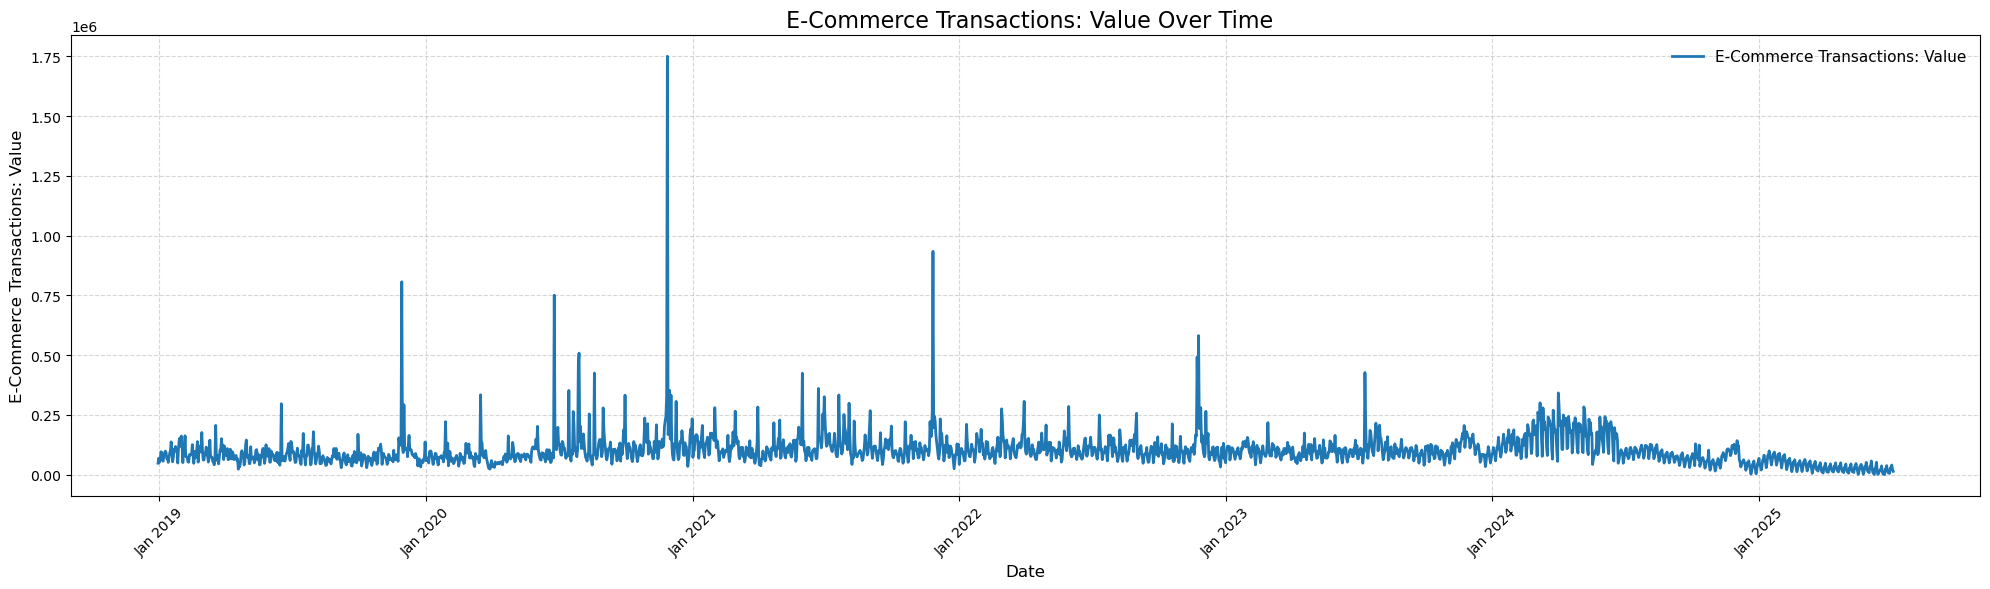

In [9]:
# Plot 
plt.figure(figsize=(20, 6))

plt.plot(data['Date'], data['Value'], linewidth=2, label='E-Commerce Transactions: Value')

# Format x-axis 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))  
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator()) 
plt.xticks(rotation=45)
# Styling
plt.title(" E-Commerce Transactions: Value Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("E-Commerce Transactions: Value", fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(frameon=False, fontsize=11)
plt.tight_layout()


plt.show()

In [10]:
#Convert Date to datetime, set date as index
data['Date'] = pd.to_datetime(data['Date'], errors='coerce')  
data = data.sort_values('Date')  
data = data.set_index('Date')

In [11]:
describe = data.describe()
describe.style.background_gradient(cmap='Greens')

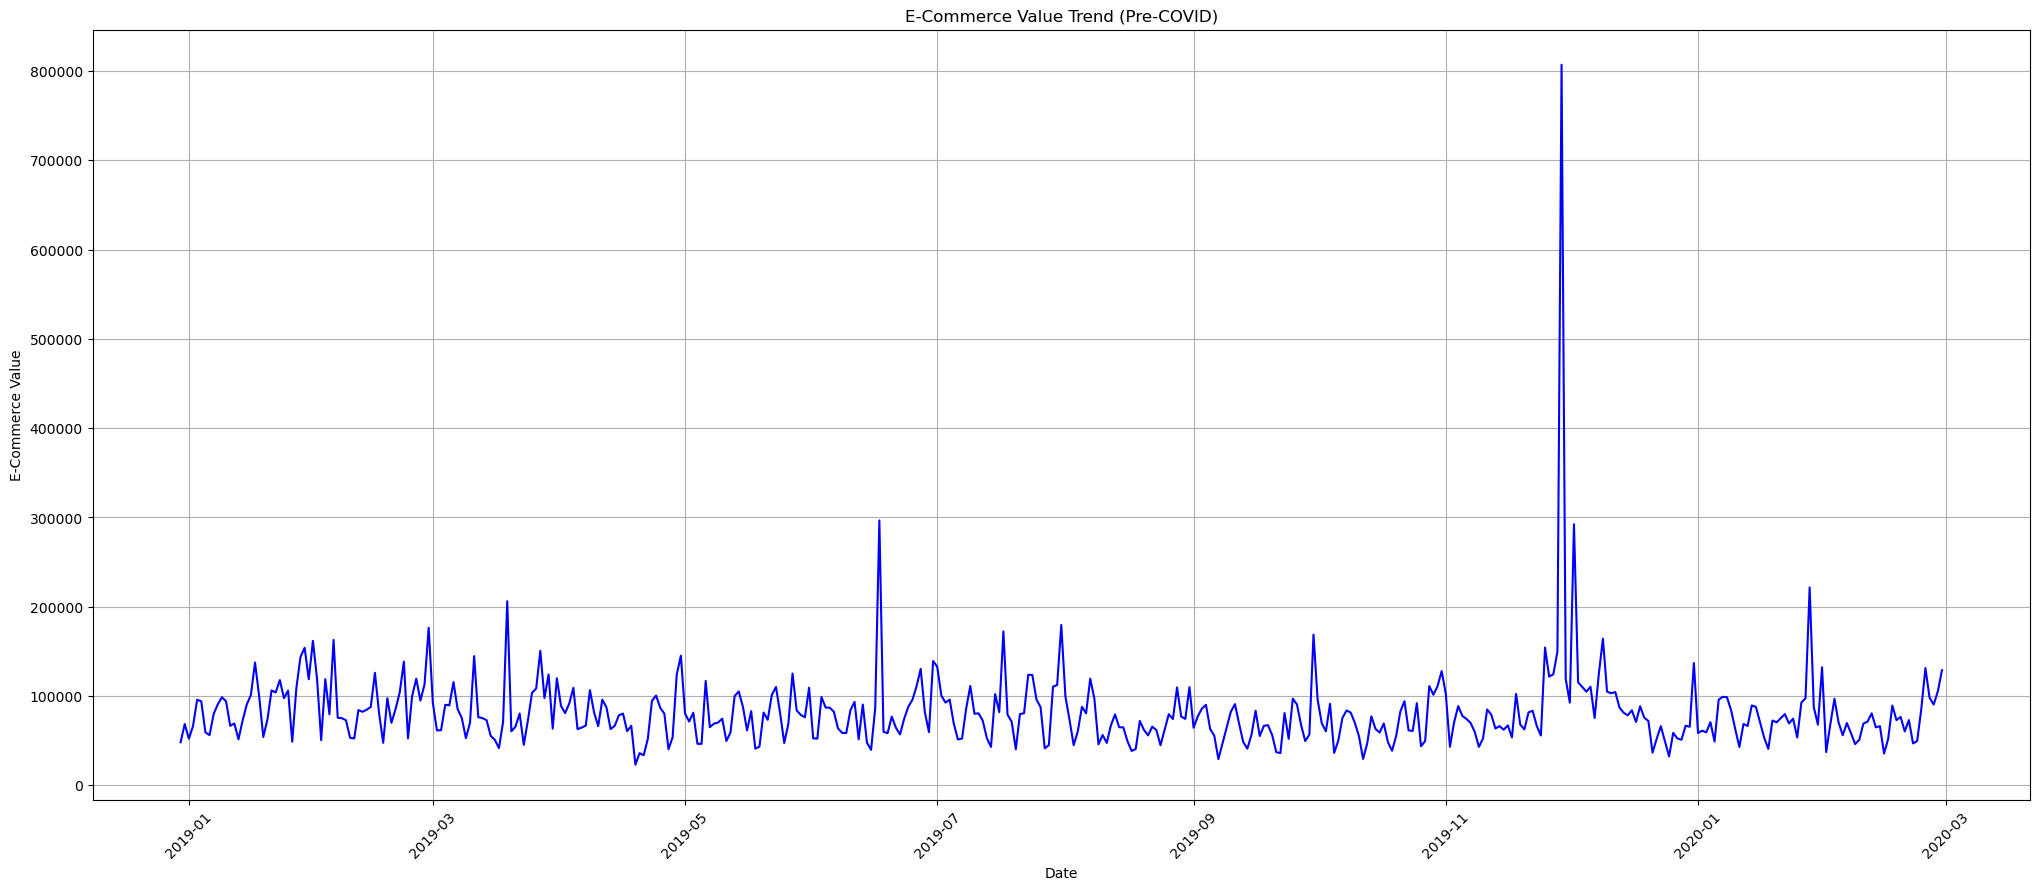

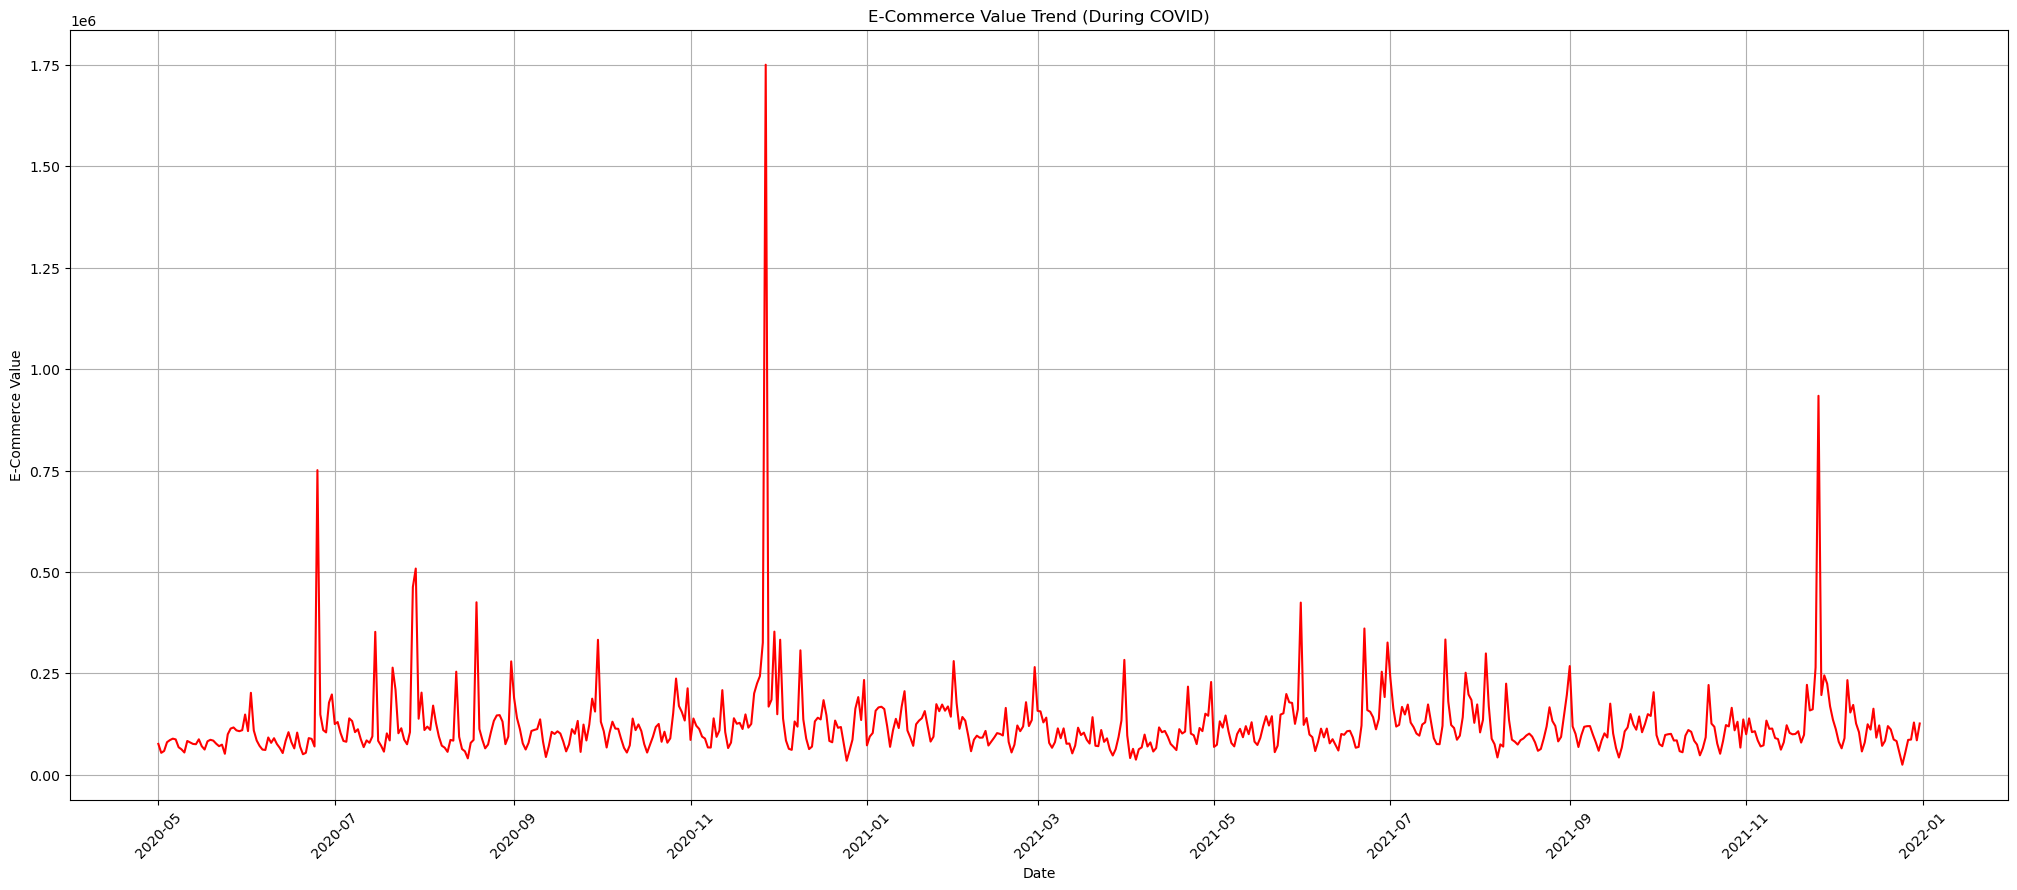

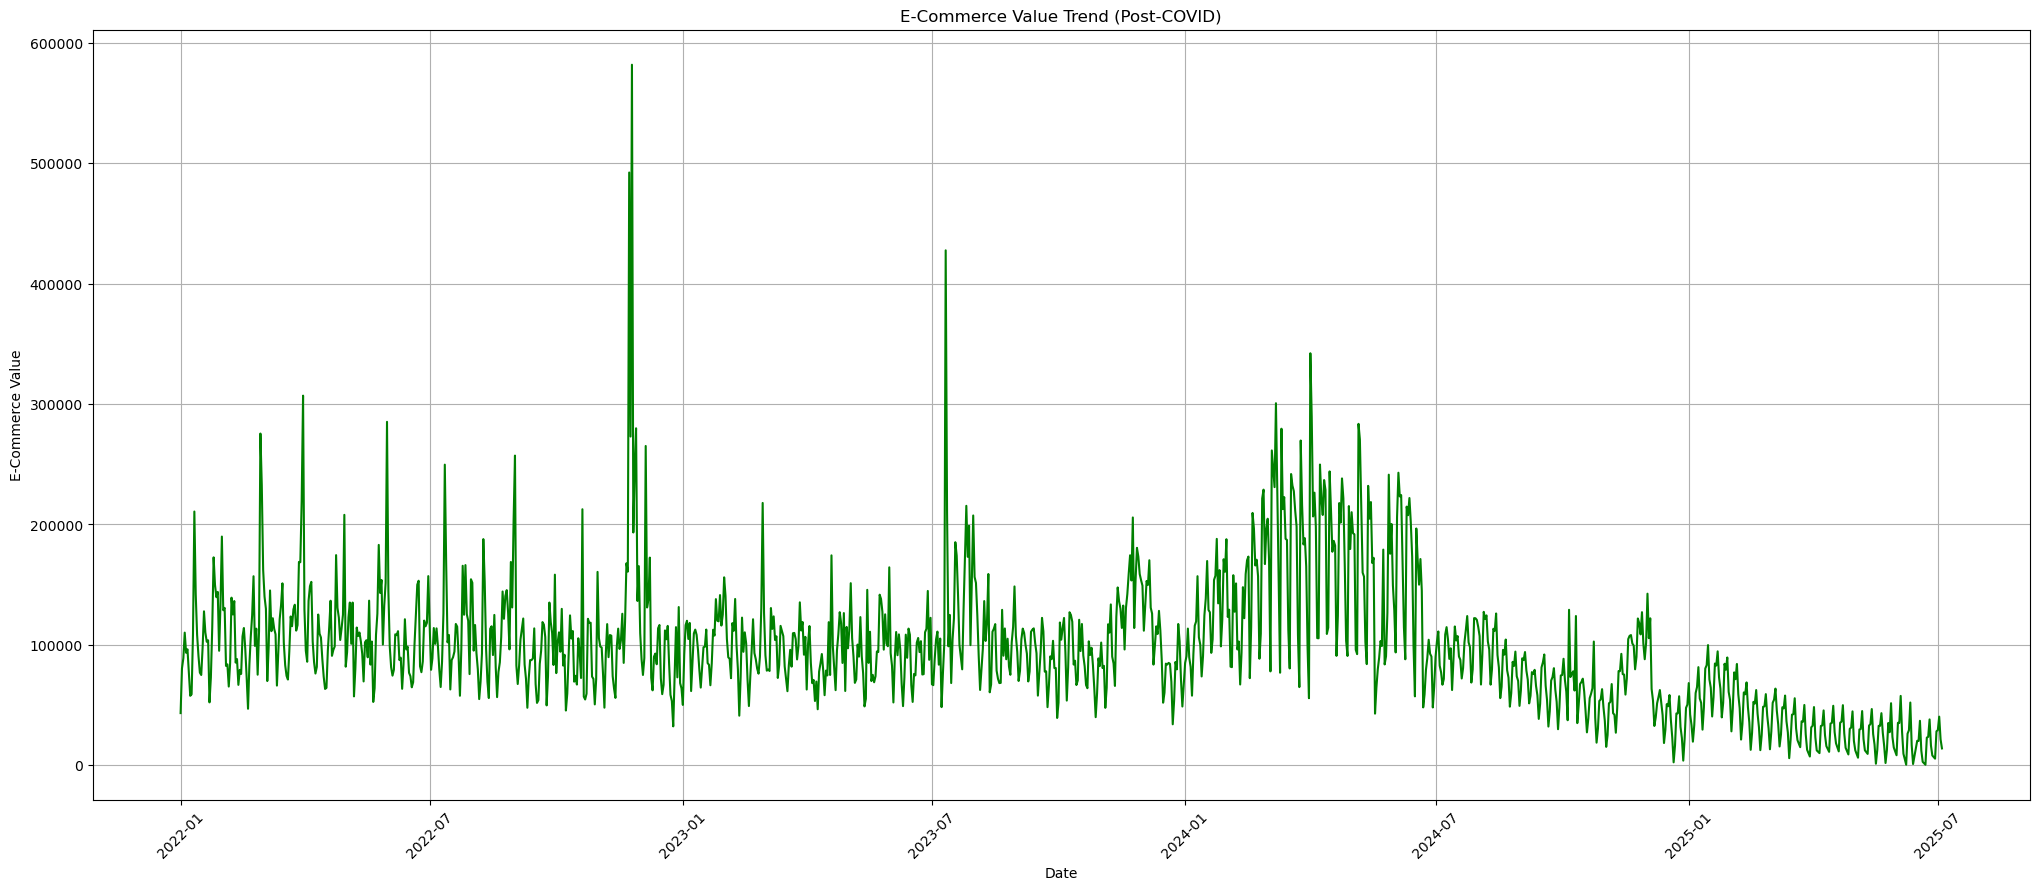

In [12]:
# Define periods
pre_covid_end = '2020-02-29'
covid_start = '2020-05-01'
covid_end = '2021-12-31'
post_covid_start = '2022-01-01'

# Split data
data_pre_covid = data[data.index <= pre_covid_end]
data_covid = data[(data.index >= covid_start) & (data.index <= covid_end)]
data_post_covid = data[data.index >= post_covid_start]

# Plot 1: Pre-COVID
plt.figure(figsize=(25,10))
plt.plot(data_pre_covid.index, data_pre_covid['Value'], color='blue')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (Pre-COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 2: During COVID
plt.figure(figsize=(25,10))
plt.plot(data_covid.index, data_covid['Value'], color='red')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (During COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

# Plot 3: Post-COVID
plt.figure(figsize=(25,10))
plt.plot(data_post_covid.index, data_post_covid['Value'], color='green')
plt.xlabel('Date')
plt.ylabel('E-Commerce Value')
plt.title('E-Commerce Value Trend (Post-COVID)')
plt.grid(True)
plt.xticks(rotation=45)
plt.show()

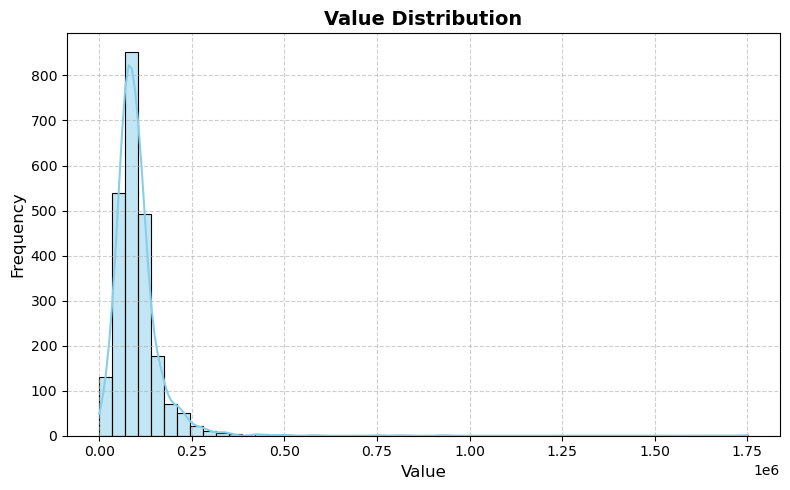

In [13]:
plt.figure(figsize=(8, 5))
sns.histplot(data['Value'], bins=50, kde=True, color="skyblue", edgecolor="black")

plt.title("Value Distribution", fontsize=14, weight='bold')
plt.xlabel("Value", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [14]:
# Preview data
data.head(10)


Value
Date                    
2018-12-30  48229.459312
2018-12-31  68629.143788
2019-01-01  52162.890120
2019-01-02  66311.844346
2019-01-03  95740.128026
2019-01-04  94094.655988
2019-01-05  59335.755374
2019-01-06  56144.974790
2019-01-07  79886.473677
2019-01-08  90733.267888

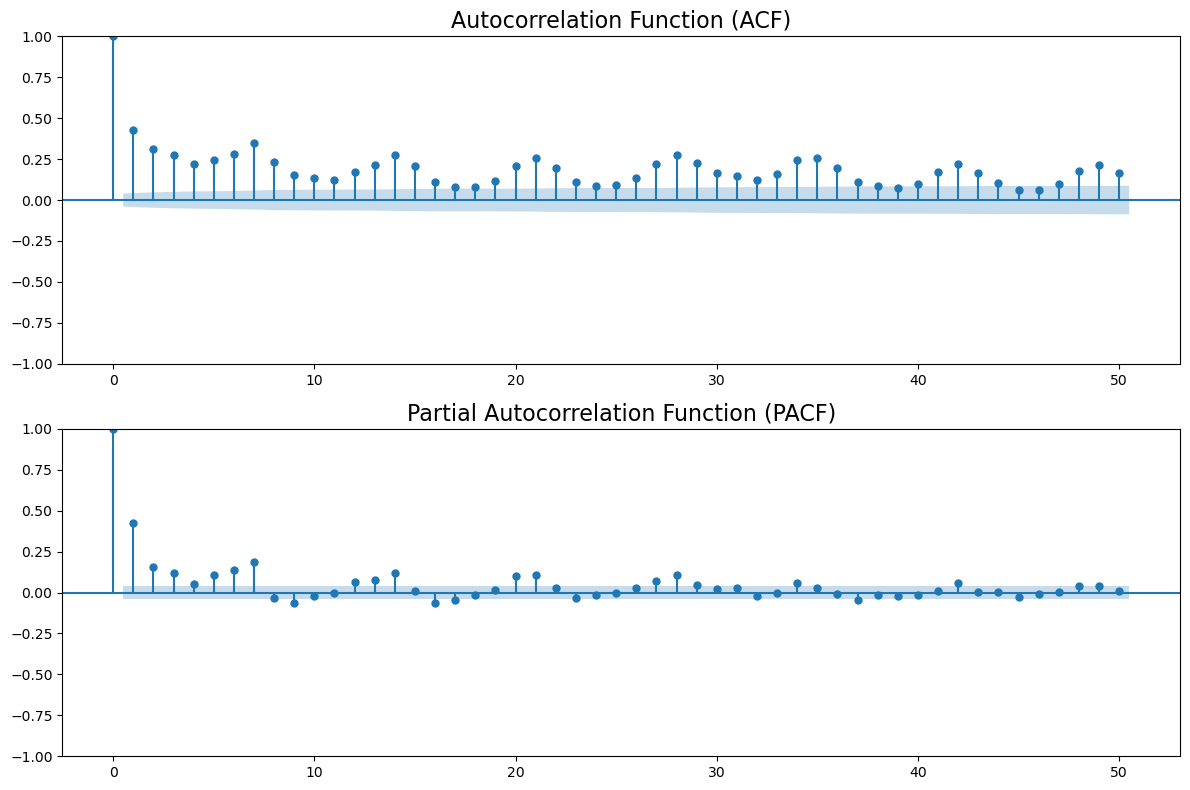

In [15]:

plt.figure(figsize=(12, 8))

# ACF plot
plt.subplot(2, 1, 1)
plot_acf(data['Value'], lags=50, ax=plt.gca(), alpha=0.05)  # alpha=0.05 for 95% CI
plt.title('Autocorrelation Function (ACF)', fontsize=16)

# PACF plot
plt.subplot(2, 1, 2)
plot_pacf(data['Value'], lags=50, ax=plt.gca(), alpha=0.05, method='ywm')  # method='ywm' avoids warnings
plt.title('Partial Autocorrelation Function (PACF)', fontsize=16)

plt.tight_layout()
plt.show()

###  FEATURE ENGENEERING

In [16]:
data['Value_lag1'] = data['Value'].shift(1)
data['Value_lag2'] = data['Value'].shift(2)

In [17]:
data.head()

Value    Value_lag1    Value_lag2
Date                                                
2018-12-30  48229.459312           NaN           NaN
2018-12-31  68629.143788  48229.459312           NaN
2019-01-01  52162.890120  68629.143788  48229.459312
2019-01-02  66311.844346  52162.890120  68629.143788
2019-01-03  95740.128026  66311.844346  52162.890120

In [18]:
data.isna().sum()

Value         0
Value_lag1    1
Value_lag2    2
dtype: int64

In [19]:
# Drop missing values inplace
data.dropna(inplace=True)

# Check for missing values
print("Missing values after dropping:")
print(data.isna().sum())

Missing values after dropping:
Value         0
Value_lag1    0
Value_lag2    0
dtype: int64


In [20]:
data.head()

Value    Value_lag1    Value_lag2
Date                                                
2019-01-01  52162.890120  68629.143788  48229.459312
2019-01-02  66311.844346  52162.890120  68629.143788
2019-01-03  95740.128026  66311.844346  52162.890120
2019-01-04  94094.655988  95740.128026  66311.844346
2019-01-05  59335.755374  94094.655988  95740.128026

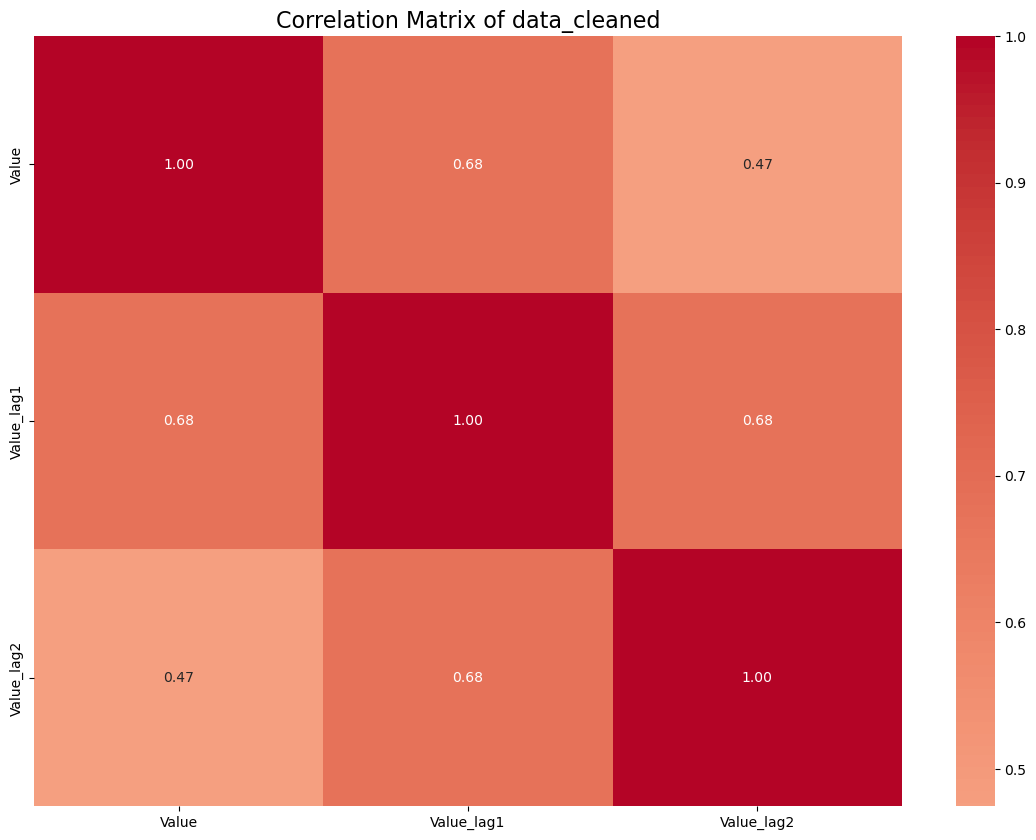

In [21]:
# Compute correlation matrix
corr_matrix = data.corr(method='spearman', numeric_only=True)  # Pearson correlation for numeric columns

# Plot heatmap
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix of data_cleaned", fontsize=16)
plt.show()

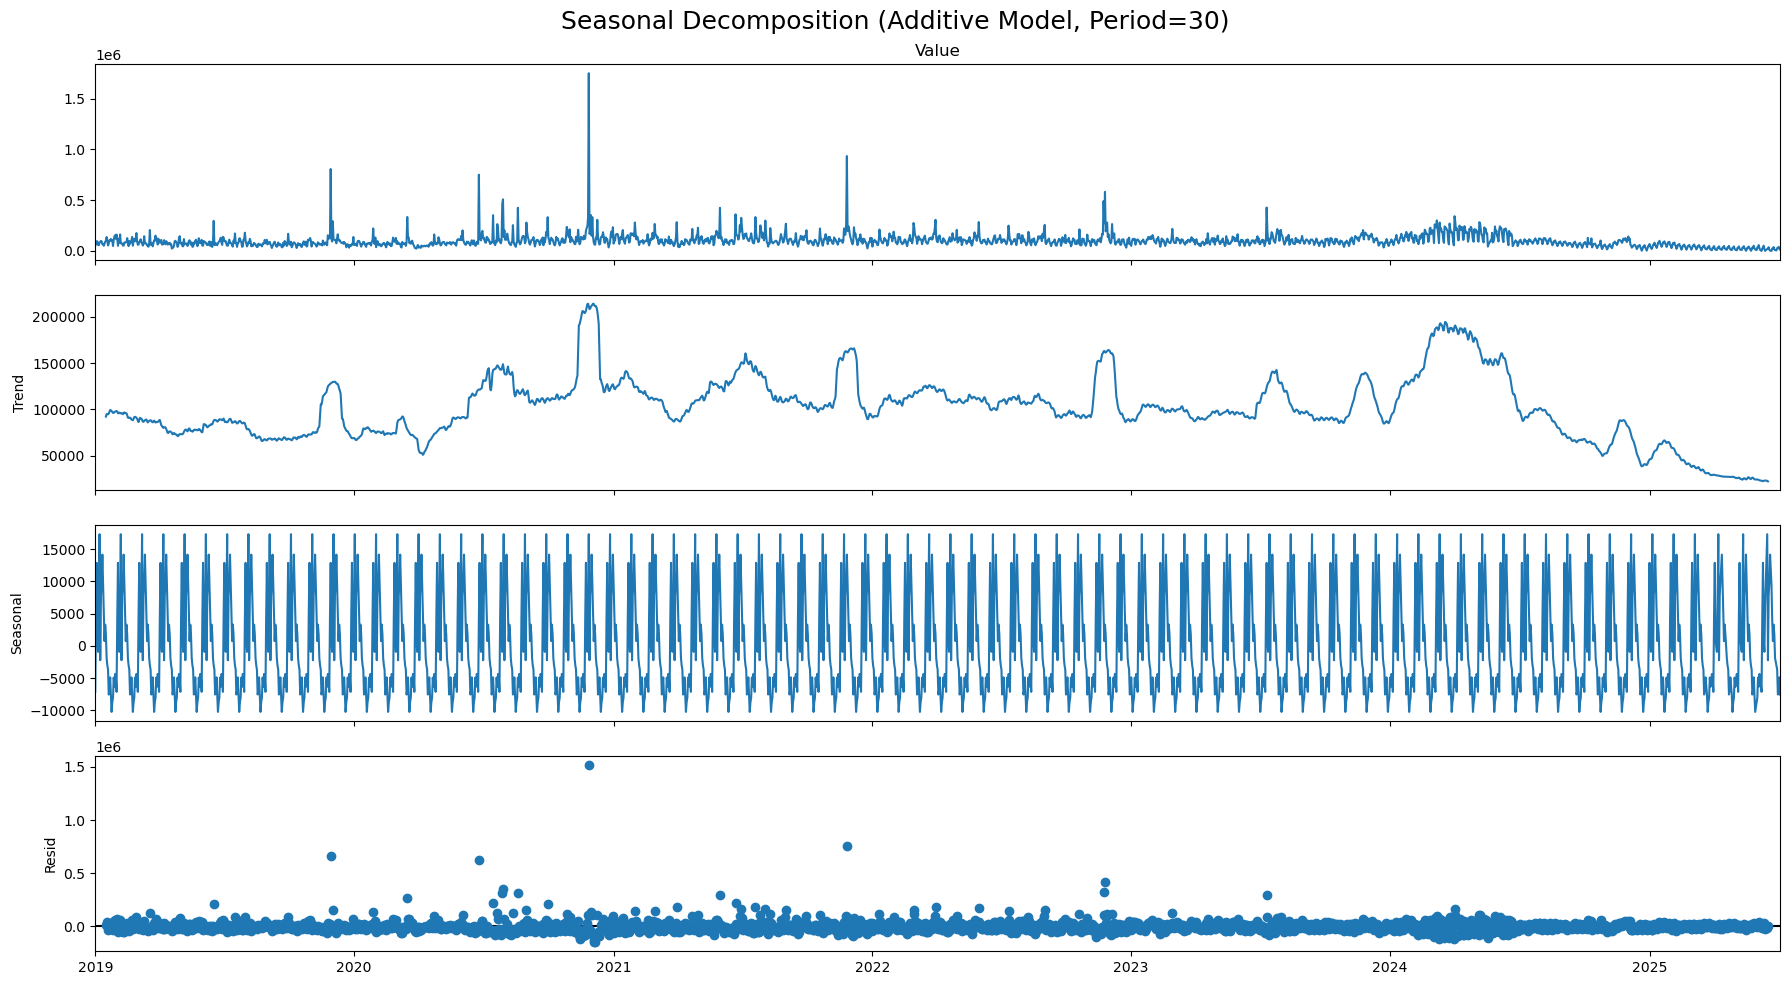

In [22]:
# Seasonal Decomposition
decomp = seasonal_decompose(data['Value'], model='additive', period=30)

# Plot decomposition
fig = decomp.plot()
fig.set_size_inches(18, 10)   # set size directly on figure
fig.suptitle("Seasonal Decomposition (Additive Model, Period=30)", fontsize=18)

plt.tight_layout()
plt.show()

In [23]:
# Drop NaNs from trend to align all components
T = decomp.trend.dropna().values
S = decomp.seasonal[decomp.trend.notna()].values
R = decomp.resid[decomp.trend.notna()].values

# Compute Trend Strength
var_R = np.var(R)
var_T_plus_R = np.var(T + R)
F_T = max(0, 1 - var_R / var_T_plus_R)

# Compute Seasonality Strength
var_S_plus_R = np.var(S + R)
F_S = max(0, 1 - var_R / var_S_plus_R)

print(f"Trend Strength : {F_T:.4f}")
print(f"Seasonality Strength : {F_S:.4f}")

Trend Strength : 0.2832
Seasonality Strength : 0.0158


### spliting data

In [24]:
# --- Define target and features ---
target = 'Value'
features = [col for col in data.columns if col != target]

# --- Chronological splits ---
train_size = int(len(data) * 0.8)  # 80% for train+val
test_size = len(data) - train_size

# Train + Test split (chronologically)
train = data.iloc[:train_size]     # first 80% for training+validation
test = data.iloc[train_size:]      # last 20% for testing

# --- Validation split from within the training set ---
val_split = 0.1
val_size = int(len(train) * val_split)

val = train.iloc[-val_size:]       # last 10% of training data as validation
train = train.iloc[:-val_size]     # remaining 90% as actual training set

# --- Check shapes ---
print(f"Train shape: {train.shape}")
print(f"Validation shape: {val.shape}")
print(f"Test shape: {test.shape}")


Train shape: (1701, 3)
Validation shape: (189, 3)
Test shape: (473, 3)


In [25]:
train.columns


Index(['Value', 'Value_lag1', 'Value_lag2'], dtype='object')

In [26]:
train_skew = skew(train['Value'])
val_skew = skew(val['Value'])
test_skew = skew(test['Value'])

print(f"Train skewness: {train_skew:.4f}")
print(f"Validation skewness: {val_skew:.4f}")
print(f"Test skewness: {test_skew:.4f}")


Train skewness: 9.9628
Validation skewness: 0.7422
Test skewness: 1.3008


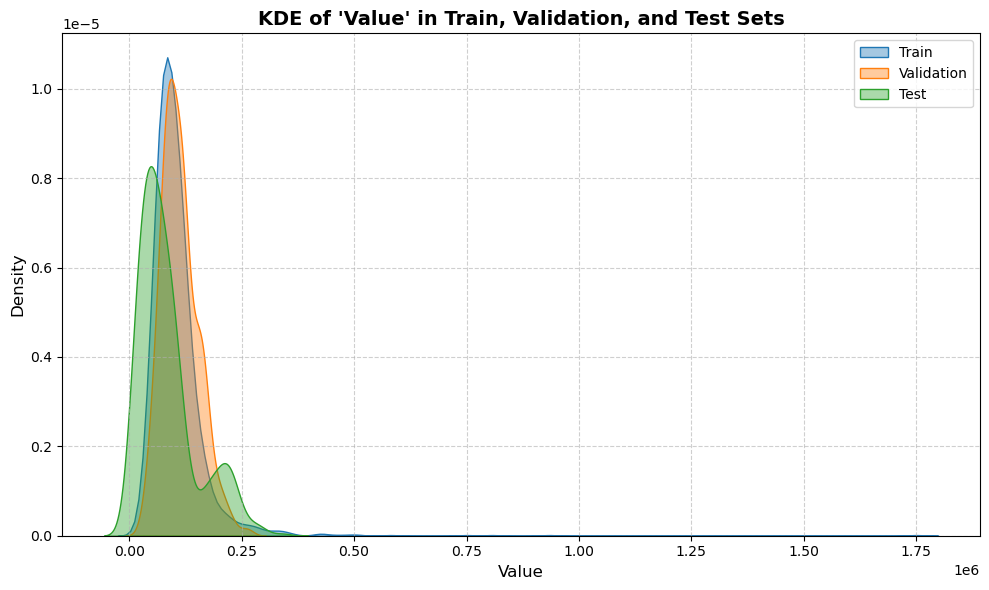

In [27]:
plt.figure(figsize=(10, 6))

# KDE plots for each dataset
sns.kdeplot(train['Value'], label='Train', fill=True, alpha=0.4)
sns.kdeplot(val['Value'], label='Validation', fill=True, alpha=0.4)
sns.kdeplot(test['Value'], label='Test', fill=True, alpha=0.4)

# Titles and labels
plt.title("KDE of 'Value' in Train, Validation, and Test Sets", fontsize=14, weight='bold')
plt.xlabel("Value", fontsize=12)
plt.ylabel("Density", fontsize=12)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [28]:
# --- Causal Winsorization Functions ---

def causal_winsorize(s: pd.Series, window=7, z_thresh=6.0):
    roll_med = s.rolling(window=window, min_periods=1).median()
    roll_mad = (s - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (s - roll_med) / roll_mad
    return s.where(z.abs() < z_thresh, roll_med)


def causal_from_history(future_df, history_df, cols, window=7, z_thresh=6.0):
    out = {}
    for c in cols:
        joined = pd.concat([history_df[c], future_df[c]])
        capped = causal_winsorize(joined, window=window, z_thresh=z_thresh)
        out[c] = capped.iloc[len(history_df):]  # only take future_df portion
    return pd.DataFrame(out, index=future_df.index)


def safe_target_winsorize(train_series, future_series=None, window=7, z_thresh=6.0):
    roll_med = train_series.rolling(window=window, min_periods=1).median()
    roll_mad = (train_series - roll_med).abs().rolling(window=window, min_periods=1).median() + 1e-9
    z = (train_series - roll_med) / roll_mad
    
    capped_train = train_series.where(z.abs() < z_thresh, roll_med)
    
    capped_future = None
    if future_series is not None:
        last_med = roll_med.iloc[-1]
        last_mad = roll_mad.iloc[-1]
        z_future = (future_series - last_med) / last_mad
        capped_future = future_series.where(z_future.abs() < z_thresh, last_med)
    
    return capped_train, capped_future


In [29]:
# Applies the causal_winsorize function to each predictor column

cols = [c for c in train.columns if c != 	'Value']  # target separate
train_exog = train[cols].apply(causal_winsorize)


# apply causal winsorization to validation and test sets
val_exog   = causal_from_history(val, train, cols)
test_exog  = causal_from_history(test, pd.concat([train, val]), cols)


# --- Verify shapes ---
print("Train exogenous shape:", train_exog.shape)
print("Validation exogenous shape:", val_exog.shape)
print("Test exogenous shape:", test_exog.shape)

Train exogenous shape: (1701, 2)
Validation exogenous shape: (189, 2)
Test exogenous shape: (473, 2)


In [ ]:
# causal winsorization on the target column

# Train target
train_target = train['Value']

# Validation target
val_target = val['Value']

# Test target
test_target = test['Value']

# Apply causal winsorization
train_capped, val_capped = safe_target_winsorize(
    train_series=train_target,
    future_series=val_target,
    window=7,
    z_thresh=6.0
)

# For test, use the last training + validation as history
test_capped = causal_from_history(
    future_df=test[['Value']],
    history_df=pd.concat([train[['Value']], val[['Value']]]),
    cols=['Value'],
    window=7,
    z_thresh=6.0
)['Value']


train['Value_capped'] = train_capped
val['Value_capped']   = val_capped
test['Value_capped']  = test_capped


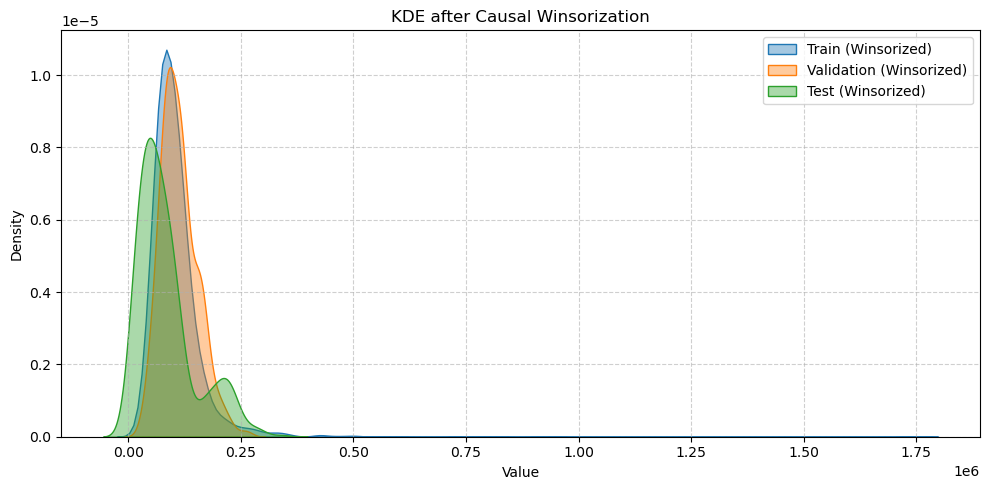

In [31]:

plt.figure(figsize=(10, 5))
sns.kdeplot(train['Value'], label='Train (Winsorized)', fill=True, alpha=0.4)
sns.kdeplot(val['Value'], label='Validation (Winsorized)', fill=True, alpha=0.4)
sns.kdeplot(test['Value'], label='Test (Winsorized)', fill=True, alpha=0.4)

plt.title("KDE after Causal Winsorization")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [32]:
# ---------------------------
# Rolling mean smoothing (causal)
# ---------------------------

window = 7

# Apply rolling mean on the capped/winsorized 'Value' column
train['Value_denoised'] = train['Value_capped'].rolling(window=window, min_periods=1).mean()
val['Value_denoised']   = val['Value_capped'].rolling(window=window, min_periods=1).mean()
test['Value_denoised']  = test['Value'].rolling(window=window, min_periods=1).mean()

#  quick check
print(train[['Value', 'Value_denoised']].head(10))


                   Value  Value_denoised
Date                                    
2019-01-01  52162.890120    52162.890120
2019-01-02  66311.844346    59237.367233
2019-01-03  95740.128026    71404.954164
2019-01-04  94094.655988    77077.379620
2019-01-05  59335.755374    73529.054771
2019-01-06  56144.974790    70631.708107
2019-01-07  79886.473677    71953.817474
2019-01-08  90733.267888    77463.871441
2019-01-09  98659.823073    82085.011259
2019-01-10  94060.269599    81845.031484


In [33]:
# Skewness
print(f"Skewness - Train: {train['Value_denoised'].skew():.4f}")
print(f"Skewness - Validation: {val['Value_denoised'].skew():.4f}")
print(f"Skewness - Test: {test['Value_denoised'].skew():.4f}")

Skewness - Train: 0.6398
Skewness - Validation: 0.6057
Skewness - Test: 0.8979


In [34]:
# --- Extract predictors from each split ---
train_exog = train[cols]
val_exog   = val[cols]
test_exog  = test[cols]

In [35]:
# ------------------------------------
# Rolling mean smoothing (predictors)
# ------------------------------------

window = 7  # rolling window size

# --- Denoise training predictors ---
train_exog_denoised = train_exog.rolling(window=window, min_periods=1).mean()

# --- Denoise validation predictors using past history (train + val) ---
val_exog_denoised = pd.concat([train_exog, val_exog]).rolling(window=window, min_periods=1).mean()
val_exog_denoised = val_exog_denoised.iloc[len(train_exog):]  # only keep val portion

# --- Denoise test predictors using past history (train + val + test) ---
test_exog_denoised = pd.concat([train_exog, val_exog, test_exog]).rolling(window=window, min_periods=1).mean()
test_exog_denoised = test_exog_denoised.iloc[len(train_exog) + len(val_exog):]  # only keep test portion

# --- Convert back to DataFrames with original column names ---
train_exog_denoised = pd.DataFrame(train_exog_denoised, index=train.index, columns=cols)
val_exog_denoised   = pd.DataFrame(val_exog_denoised, index=val.index, columns=cols)
test_exog_denoised  = pd.DataFrame(test_exog_denoised, index=test.index, columns=cols)

# --- Quick check ---
print("Train predictors denoised shape:", train_exog_denoised.shape)
print("Validation predictors denoised shape:", val_exog_denoised.shape)
print("Test predictors denoised shape:", test_exog_denoised.shape)


Train predictors denoised shape: (1701, 2)
Validation predictors denoised shape: (189, 2)
Test predictors denoised shape: (473, 2)


In [36]:
test.head()

Value     Value_lag1     Value_lag2  Value_denoised
Date                                                                   
2024-03-05  245641.948115  261409.730450   77947.906135   245641.948115
2024-03-06  230941.089398  245641.948115  261409.730450   238291.518757
2024-03-07  300603.793923  230941.089398  245641.948115   259062.277145
2024-03-08  228114.868896  300603.793923  230941.089398   251325.425083
2024-03-09  152031.207480  228114.868896  300603.793923   231466.581562

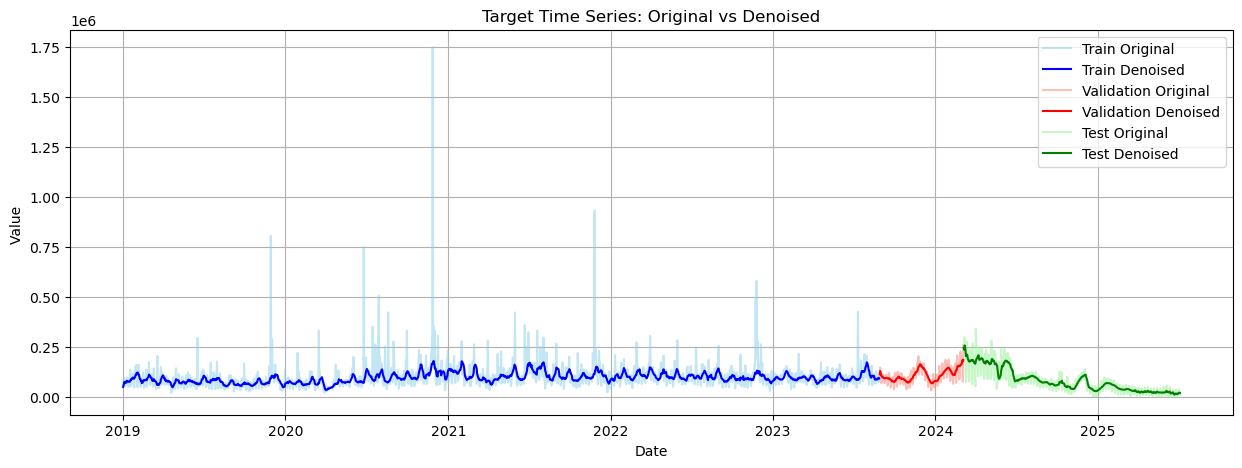

In [ ]:
plt.figure(figsize=(15,5))
plt.plot(train.index, train['Value'], label='Train Original', color='skyblue', alpha=0.5)
plt.plot(train.index, train['Value_denoised'], label='Train Denoised', color='blue')

plt.plot(val.index, val['Value'], label='Validation Original', color='salmon', alpha=0.5)
plt.plot(val.index, val['Value_denoised'], label='Validation Denoised', color='red')

plt.plot(test.index, test['Value'], label='Test Original', color='lightgreen', alpha=0.5)
plt.plot(test.index, test['Value_denoised'], label='Test Denoised', color='green')

plt.title('Target Time Series: Original vs Denoised')
plt.xlabel('Date')
plt.ylabel('Value ')
plt.legend()
plt.grid(True)
plt.show()

In [38]:
cols_to_drop = ['Value','Value_capped']

train = train.drop(columns=[c for c in cols_to_drop if c in train.columns])
val   = val.drop(columns=[c for c in cols_to_drop if c in val.columns])
test  = test.drop(columns=[c for c in cols_to_drop if c in test.columns])

# Verify
print("Train columns:", train.columns)
print("Validation columns:", val.columns)
print("Test columns:", test.columns)

Train columns: Index(['Value_lag1', 'Value_lag2', 'Value_denoised'], dtype='object')
Validation columns: Index(['Value_lag1', 'Value_lag2', 'Value_denoised'], dtype='object')
Test columns: Index(['Value_lag1', 'Value_lag2', 'Value_denoised'], dtype='object')


In [39]:
# Function to check stationarity
def check_stationarity(series, series_name='Series'):
    result = adfuller(series.dropna())
    print(f"ADF Test for {series_name}:")
    print(f"ADF Statistic: {result[0]}")
    #print(f"p-value: {result[1]}")
    #print("Critical Values:")
    for key, value in result[4].items():
       print(f"   {key}: {value}")
    if result[1] < 0.05:
        print(f"Result: {series_name} is stationary \n")
    else:
        print(f"Result: {series_name} is non-stationary \n")

# Check stationarity for train, validation, and test sets
datasets = [('Train', train), ('Validation', val), ('Test', test)]

for name, df in datasets:
    check_stationarity(df['Value_denoised'], f"{name} Denoised")

ADF Test for Train Denoised:
ADF Statistic: -3.115834841436152
   1%: -3.4342507300744147
   5%: -2.863262951722777
   10%: -2.5676872561165305
Result: Train Denoised is stationary 

ADF Test for Validation Denoised:
ADF Statistic: -1.4014355098137137
   1%: -3.4685016947910636
   5%: -2.8782983668563396
   10%: -2.57570415906989
Result: Validation Denoised is non-stationary 

ADF Test for Test Denoised:
ADF Statistic: -1.9678831721033243
   1%: -3.444836032925901
   5%: -2.8679272692747415
   10%: -2.5701721745036776
Result: Test Denoised is non-stationary 



In [40]:
# --- Initialize MinMaxScalers ---
scaler_X = MinMaxScaler().fit(train_exog_denoised)
scaler_y = MinMaxScaler().fit(train[['Value_denoised']])

# --- Transform predictors ---
X_train = scaler_X.transform(train_exog_denoised)
X_val   = scaler_X.transform(val_exog_denoised)
X_test  = scaler_X.transform(test_exog_denoised)

# --- Transform target ---
y_train = scaler_y.transform(train[['Value_denoised']])
y_val   = scaler_y.transform(val[['Value_denoised']])
y_test  = scaler_y.transform(test[['Value_denoised']])

# --- Print shapes ---
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1701, 2)
y_train shape: (1701, 1)
X_val shape: (189, 2)
y_val shape: (189, 1)
X_test shape: (473, 2)
y_test shape: (473, 1)


In [41]:
X_train_df = pd.DataFrame(X_train, index=train.index, columns=cols)
X_val_df   = pd.DataFrame(X_val,   index=val.index,   columns=cols)
X_test_df  = pd.DataFrame(X_test,  index=test.index,  columns=cols)

y_train_df = pd.DataFrame(y_train, index=train.index, columns=['Value_denoised'])
y_val_df   = pd.DataFrame(y_val,   index=val.index,   columns=['Value_denoised'])
y_test_df  = pd.DataFrame(y_test,  index=test.index,  columns=['Value_denoised'])


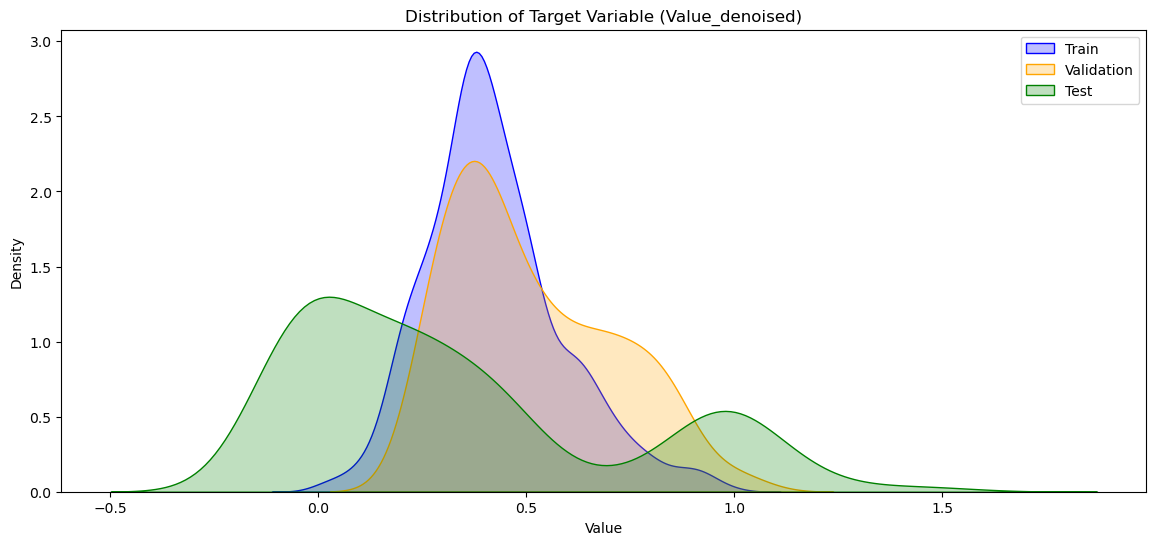

Skewness - Train: 0.6398
Skewness - Validation: 0.6057
Skewness - Test: 0.8979


In [42]:

plt.figure(figsize=(14,6))

sns.kdeplot(y_train_df['Value_denoised'], color='blue', label='Train', fill=True)
sns.kdeplot(y_val_df['Value_denoised'], color='orange', label='Validation', fill=True)
sns.kdeplot(y_test_df['Value_denoised'], color='green', label='Test', fill=True)

plt.title("Distribution of Target Variable (Value_denoised)")
plt.xlabel("Value")
plt.ylabel("Density")
plt.legend()
plt.show()

# Skewness
print(f"Skewness - Train: {y_train_df['Value_denoised'].skew():.4f}")
print(f"Skewness - Validation: {y_val_df['Value_denoised'].skew():.4f}")
print(f"Skewness - Test: {y_test_df['Value_denoised'].skew():.4f}")

In [43]:
# Create sequences using past seq_length steps to predict current step


def create_sequences(X, y, seq_length=7):
    """
    Create LSTM sequences using past seq_length steps to predict current step.
    Keeps original indices for alignment.

    Parameters:
    X : pd.DataFrame, features
    y : pd.DataFrame or Series, target
    seq_length : int, number of past timesteps

    Returns:
    X_seq : np.array, shape (num_sequences, seq_length, n_features)
    y_seq : np.array, shape (num_sequences, 1)
    seq_index : np.array, indices of y corresponding to each sequence
    """
    X_seq, y_seq, seq_index = [], [], []

    for i in range(seq_length, len(X)):
        # Take past seq_length steps of features
        X_seq.append(X.iloc[i-seq_length:i].values)

        # Take target at current time step
        y_seq.append(y.iloc[i].values if y.ndim > 1 else y.iloc[i])

        # Store the corresponding index
        seq_index.append(X.index[i])

    return np.array(X_seq), np.array(y_seq), np.array(seq_index)


In [44]:
SEQ_LENGTH = 7  # Using past 7 days to predict next day

X_train_seq, y_train_seq, idx_train_seq = create_sequences(X_train_df, y_train_df, SEQ_LENGTH)
X_val_seq, y_val_seq, idx_val_seq       = create_sequences(X_val_df, y_val_df, SEQ_LENGTH)
X_test_seq, y_test_seq, idx_test_seq    = create_sequences(X_test_df, y_test_df, SEQ_LENGTH)

# Print shapes
print("X_train_seq shape:", X_train_seq.shape)
print("y_train_seq shape:", y_train_seq.shape)
print("Number of indices:", len(idx_train_seq))

X_train_seq shape: (1694, 7, 2)
y_train_seq shape: (1694, 1)
Number of indices: 1694


In [45]:
# HELPING FUCTIONS

# training history ploting function
def plot_history(histories, names):
    plt.figure(figsize=(18,6))
    for i, history in enumerate(histories):
        plt.plot(history.history['loss'], label=f'{names[i]} Train Loss')
        plt.plot(history.history['val_loss'], label=f'{names[i]} Val Loss', linestyle='--')
    plt.title('Deep Learning Model Training History (MSE Loss)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# orediction ploting function
def plot_predictions(idx_val, y_val_true, y_val_pred,
                     idx_test, y_test_true, y_test_pred,
                     title='Model Predictions vs True Values'):
    plt.figure(figsize=(16,6))

    # Validation
    plt.plot(idx_val, y_val_true, label='Validation True', color='blue')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')

    # Test
    plt.plot(idx_test, y_test_true, label='Test True', color='green')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')

    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True   )
    plt.legend()
    plt.show()
   
# evaluation fuction
def evaluate_predictions(y_true, y_pred, set_name='Test'):
    print(f"Evaluation Metrics for {set_name} Set:")
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)

    # Print metrics 
    print(f"MAE: {mae:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R2: {r2:.4f}")
    
    metrics_dict = {'MAE': mae, 'RMSE': rmse, 'R2': r2}
    return metrics_dict


# EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',    
    patience=10,            
    restore_best_weights=True 
)



# Hyperparameters
n_features = X_train_seq.shape[2]   # number of features in input
SEQ_LENGTH = X_train_seq.shape[1]   # timesteps
Epochs = 100
Batch_size = 64


In [46]:
def plot_predictions_full(idx_train, y_train, 
                          idx_val, y_val_true, y_val_pred,
                          idx_test, y_test_true, y_test_pred,
                          title='Model Predictions vs True Values'):
    plt.figure(figsize=(18,6))
    
    # --- Training ---
    plt.plot(idx_train, y_train, label='Train True', color='blue')
    
    # --- Validation ---
    plt.plot(idx_val, y_val_true, label='Validation True', color='green')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')
    
    # --- Test ---
    plt.plot(idx_test, y_test_true, label='Test True', color='purple')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')
    
    # Optional: shade validation and test regions for clarity
    plt.axvspan(idx_val[0], idx_val[-1], color='green', alpha=0.1)
    plt.axvspan(idx_test[0], idx_test[-1], color='red', alpha=0.1)
    
    plt.xlabel('Index / Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# ARIMAX FORECASTING


In [ ]:
# Define ARIMAX model
arimax_model = SARIMAX(
    endog=y_train_df,        # target
    exog=X_train_df,         # exogenous features
    order=(2,0,2),           # ARIMA order (p,d,q)
    enforce_stationarity=False,
    enforce_invertibility=False
)

# Fit the model
arimax_result = arimax_model.fit(disp=False)

# Print model summary
print(arimax_result.summary())

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:         Value_denoised   No. Observations:                 1701
Model:               SARIMAX(3, 0, 2)   Log Likelihood                3307.648
Date:                Mon, 10 Nov 2025   AIC                          -6599.295
Time:                        22:33:10   BIC                          -6555.797
Sample:                    01-01-2019   HQIC                         -6583.191
                         - 08-28-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Value_lag1     0.2483      0.019     12.782      0.000       0.210       0.286
Value_lag2     0.0577      0.019      3.043      0.002       0.021       0.095
ar.L1          1.6322      0.368      4.435      0.0

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


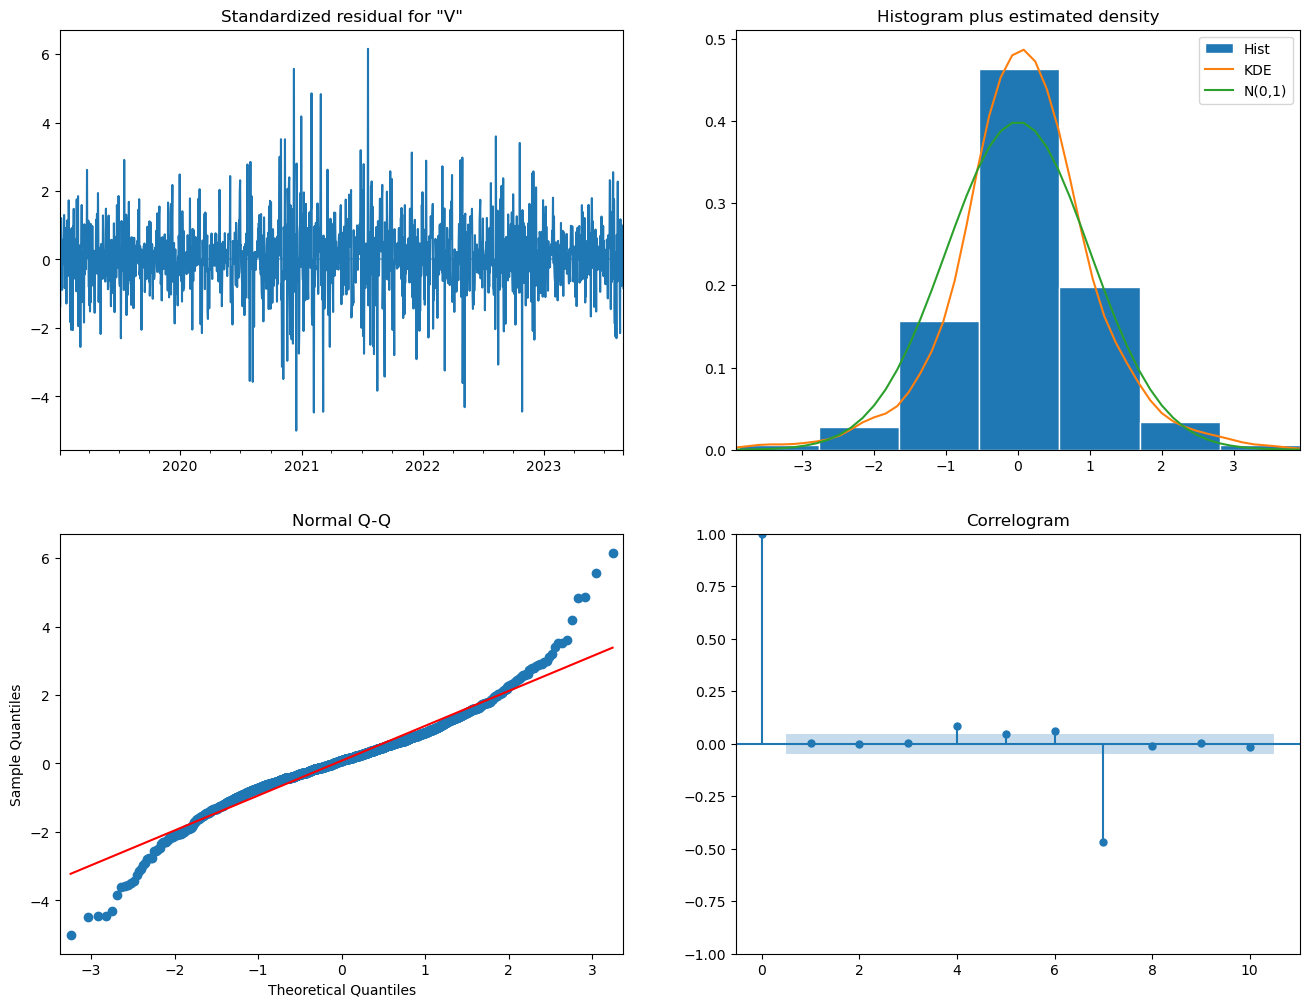

In [48]:
arimax_result.plot_diagnostics(figsize=(16, 12))
plt.show()

In [49]:
# --- Validation predictions ---
y_val_pred_arimax = arimax_result.get_forecast(steps=len(X_val_df), exog=X_val_df).predicted_mean
y_val_pred_arimax_scaled = scaler_y.transform(y_val_pred_arimax.values.reshape(-1, 1))  #  scale predictions
y_val_true_arimax = y_val_df.values  

# --- Test predictions ---
y_test_pred_arimax = arimax_result.get_forecast(steps=len(X_test_df), exog=X_test_df).predicted_mean
y_test_pred_arimax_scaled = scaler_y.transform(y_test_pred_arimax.values.reshape(-1, 1))  #  scale predictions
y_test_true_arimax = y_test_df.values  


In [50]:

# --- Evaluate predictions on scaled data ---
metrics_val_arimax = evaluate_predictions(
    y_val_true_arimax, 
    y_val_pred_arimax.values.reshape(-1, 1), 
    set_name='Validation'
)

metrics_test_arimax = evaluate_predictions(
    y_test_true_arimax, 
    y_test_pred_arimax.values.reshape(-1, 1), 
    set_name='Test'
)


# Extract RMSE, MAE, R² for Validation set
rmse_arimax_val = metrics_val_arimax['RMSE']
mae_arimax_val  = metrics_val_arimax['MAE']
r2_arimax_val   = metrics_val_arimax['R2']

# Extract RMSE, MAE, R² for comparison
rmse_arimax = metrics_test_arimax['RMSE']
mae_arimax  = metrics_test_arimax['MAE']
r2_arimax   = metrics_test_arimax['R2']

Evaluation Metrics for Validation Set:
MAE: 0.3254
RMSE: 0.3964
R2: -3.1248
Evaluation Metrics for Test Set:
MAE: 0.2660
RMSE: 0.3672
R2: 0.1236


In [51]:
# Inverse-transform
y_val_true_arimax = scaler_y.inverse_transform(y_val_df)
y_val_pred_arimax_rescaled = scaler_y.inverse_transform(y_val_pred_arimax.values.reshape(-1,1))


# Inverse-transform
y_test_true_arimax = scaler_y.inverse_transform(y_test_df)
y_test_pred_arimax_rescaled = scaler_y.inverse_transform(y_test_pred_arimax.values.reshape(-1,1))



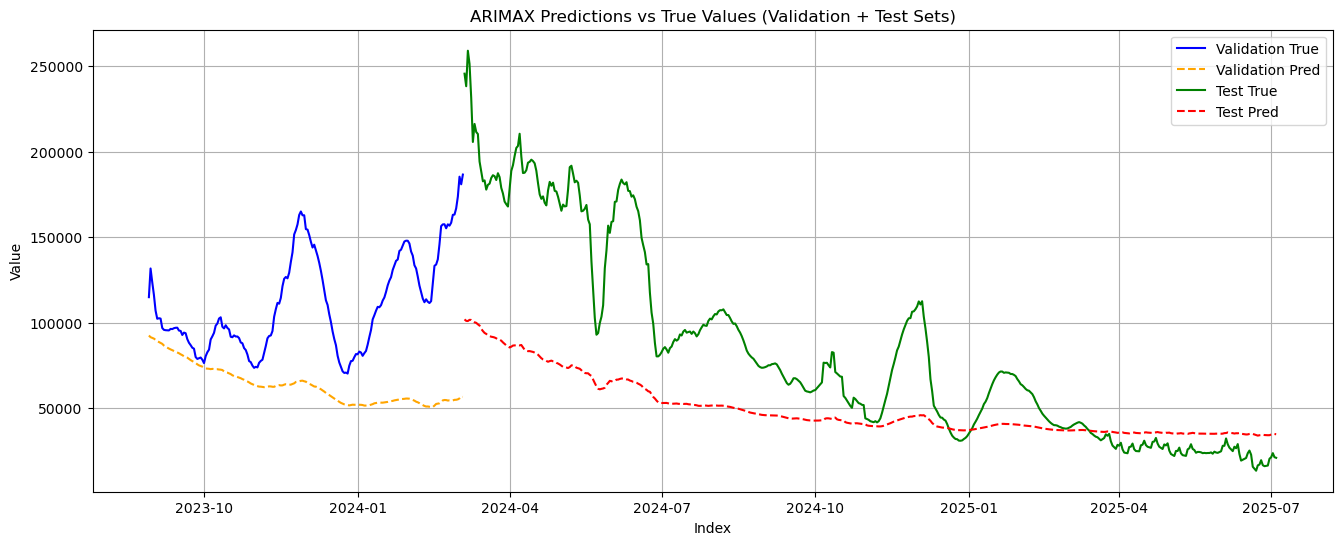

In [52]:
# Validation indices
idx_val_arimax = X_val_df.index
# Test indices
idx_test_arimax = X_test_df.index

# Plot ARIMAX predictions
plot_predictions(
    idx_val_arimax, y_val_true_arimax, y_val_pred_arimax_rescaled,
    idx_test_arimax, y_test_true_arimax, y_test_pred_arimax_rescaled,
    title='ARIMAX Predictions vs True Values (Validation + Test Sets)'
)

# DEEP LEARNING NOWCASTING

In [53]:
def plot_predictions_full(idx_train, y_train, 
                          idx_val, y_val_true, y_val_pred,
                          idx_test, y_test_true, y_test_pred,
                          title='Model Predictions vs True Values'):
    plt.figure(figsize=(18,6))
    
    # --- Training ---
    plt.plot(idx_train, y_train, label='Train True', color='blue')
    
    # --- Validation ---
    plt.plot(idx_val, y_val_true, label='Validation True', color='green')
    plt.plot(idx_val, y_val_pred, label='Validation Pred', color='orange', linestyle='--')
    
    # --- Test ---
    plt.plot(idx_test, y_test_true, label='Test True', color='purple')
    plt.plot(idx_test, y_test_pred, label='Test Pred', color='red', linestyle='--')
    
    # Shade validation and test regions
    plt.axvspan(idx_val[0], idx_val[-1], color='green', alpha=0.05)
    plt.axvspan(idx_test[0], idx_test[-1], color='red', alpha=0.05)
    
    plt.xlabel('Index / Time')
    plt.ylabel('Value')
    plt.title(title)
    plt.grid(True)
    plt.legend()
    plt.show()


# A. LSTM

In [54]:
def build_lstm(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First LSTM layer
        LSTM(64, activation='tanh', return_sequences=True, 
             kernel_regularizer=l2(l2_reg), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second LSTM layer
        LSTM(32, kernel_regularizer=l2(l2_reg)),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate model
lstm_model = build_lstm(SEQ_LENGTH, n_features, l2_reg=0.0001)
lstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 7, 64)          │        17,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 29,601 (115.63 KB)

 Trainable params: 29,601 (115.63 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history_lstm = lstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 9s 61ms/step - loss: 0.1309 - mae: 0.2948 - val_loss: 0.0387 - val_mae: 0.1304
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0284 - mae: 0.1066 - val_loss: 0.0328 - val_mae: 0.1229
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0251 - mae: 0.1040 - val_loss: 0.0349 - val_mae: 0.1270
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0249 - mae: 0.1053 - val_loss: 0.0361 - val_mae: 0.1305
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0261 - mae: 0.1089 - val_loss: 0.0342 - val_mae: 0.1279
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0236 - mae: 0.1038 - val_loss: 0.0353 - val_mae: 0.1309
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0224 - mae: 0.1022 - val_loss: 0.0289 - val_mae: 0.1195
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0226 - mae: 0.1056 - val_loss: 0.0281 - val_mae: 0.1185
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - lo

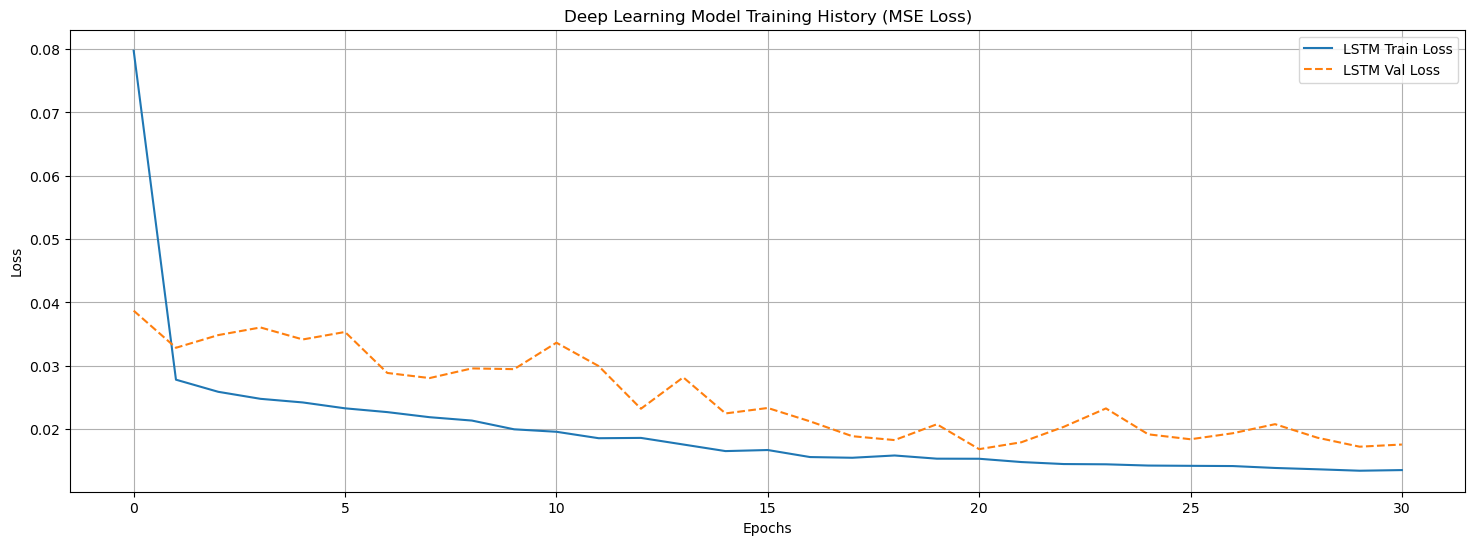

In [56]:
# Call the function
plot_history(
    histories=[history_lstm],
    names=['LSTM']
)

In [57]:
# Validation predictions
y_val_pred = lstm_model.predict(X_val_seq)
# Test predictions
y_test_pred = lstm_model.predict(X_test_seq)

# Validation DataFrame
val_pred_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred.flatten(),
}, index=idx_val_seq)

# Test DataFrame
test_pred_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred.flatten(),
}, index=idx_test_seq)


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


In [58]:
y_val_pred_lstm_rescaled = scaler_y.inverse_transform(val_pred_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_df[['y_true']])

y_test_pred_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_pred']])
y_test_true_lstm_rescaled = scaler_y.inverse_transform(test_pred_df[['y_true']])


# --- Evaluate metrics 
metrics_val_lstm  = evaluate_predictions(
    y_true=val_pred_df ['y_true'],
    y_pred=val_pred_df ['y_pred'],
    set_name='Validation'
)

metrics_test_lstm = evaluate_predictions(
    y_true=test_pred_df['y_true'],
    y_pred=test_pred_df['y_pred'],
    set_name='Test'
)


# Extract RMSE, MAE, R² for test set
rmse_lstm = metrics_test_lstm['RMSE']
mae_lstm  = metrics_test_lstm['MAE']
r2_lstm   = metrics_test_lstm['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_lstm_val = metrics_val_lstm['RMSE']
mae_lstm_val  = metrics_val_lstm['MAE']
r2_lstm_val   = metrics_val_lstm['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0931
RMSE: 0.1212
R2: 0.6270
Evaluation Metrics for Test Set:
MAE: 0.1061
RMSE: 0.1580
R2: 0.8213


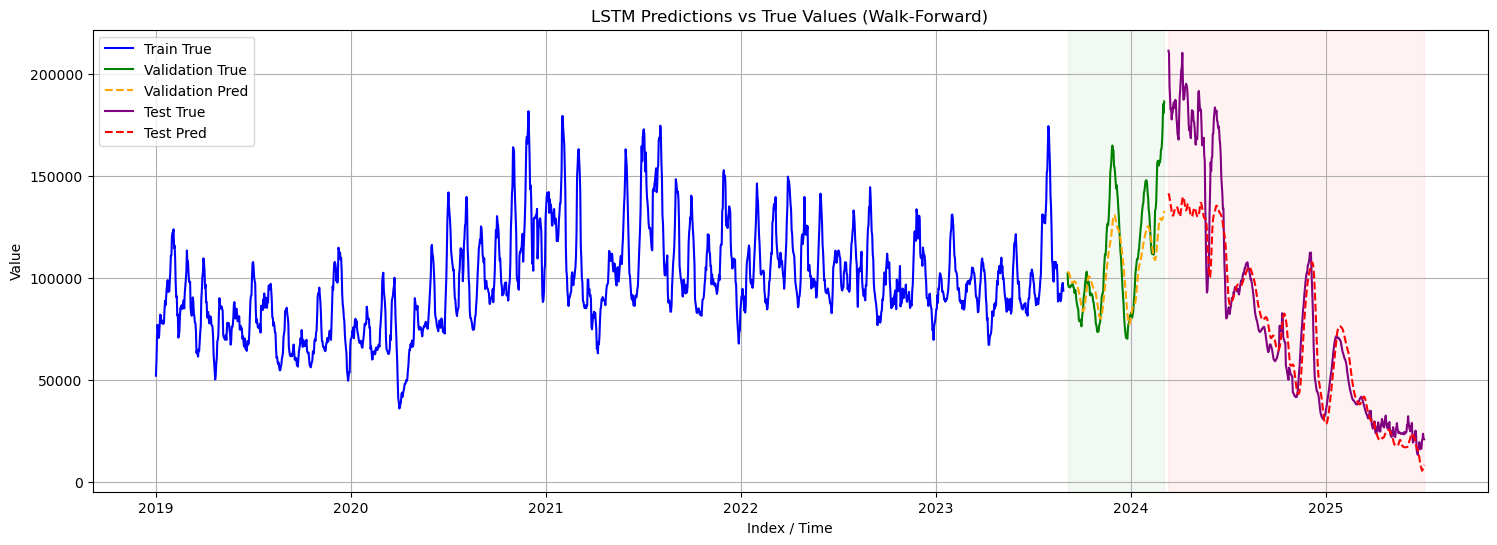

In [59]:
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_lstm_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_lstm_rescaled, y_test_pred=y_test_pred_lstm_rescaled,
    title='LSTM Predictions vs True Values (Walk-Forward)'
)


In [60]:
n_display = 10

# Take first n_display predictions and actuals
actual = y_test_true_lstm_rescaled[:n_display].flatten()
predicted = y_test_pred_lstm_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df)

        date         Actual      Predicted
0 2024-03-12  211520.485703  141581.703125
1 2024-03-13  210333.857493  140879.687500
2 2024-03-14  194247.388252  139506.843750
3 2024-03-15  188390.754843  137953.593750
4 2024-03-16  182694.630506  136295.906250
5 2024-03-17  183201.054548  134551.343750
6 2024-03-18  177825.201690  132658.640625
7 2024-03-19  180609.199936  131237.062500
8 2024-03-20  181316.293263  130598.046875
9 2024-03-21  184640.662739  130809.320312


# Bi-LSTM

In [61]:
def build_bilstm(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First Bi-LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg)),
                      input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second Bi-LSTM layer
        Bidirectional(LSTM(32, kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # single output
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate model
bilstm_model = build_bilstm(SEQ_LENGTH, n_features, l2_reg=0.0001)
bilstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 7, 128)         │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 75,585 (295.25 KB)

 Trainable params: 75,585 (295.25 KB)

 Non-trainable params: 0 (0.00 B)

In [2]:
history_bilstm = bilstm_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop]
)


NameError: name 'bilstm_model' is not defined

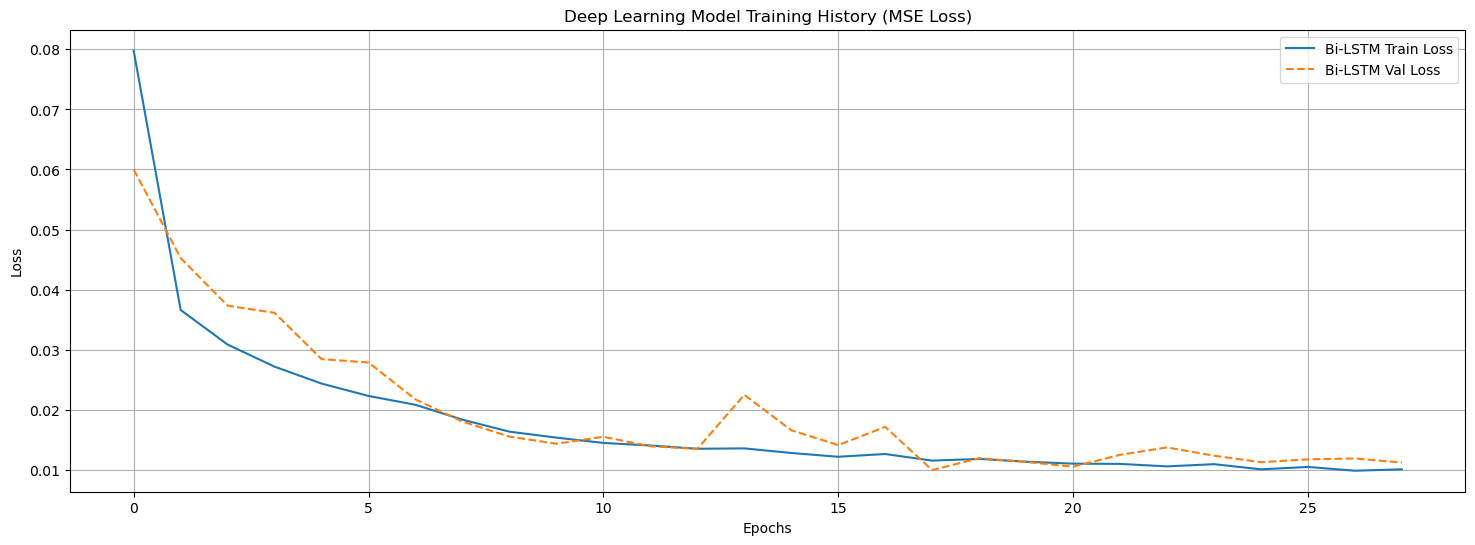

In [63]:
# plot training history
plot_history(
    histories=[history_bilstm],
    names=['Bi-LSTM']
)

In [64]:
# Validation predictions
y_val_pred_bi = bilstm_model.predict(X_val_seq)
# Test predictions
y_test_pred_bi = bilstm_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bi_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bi.flatten()
}, index=idx_val_seq)

test_pred_bi_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bi.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bi_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bi_df[['y_true']])

y_test_pred_bi_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bi_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 5s 627ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


In [65]:

# --- Evaluate metrics 
metrics_val_bilstm = evaluate_predictions(
    y_true=val_pred_bi_df ['y_true'],
    y_pred=val_pred_bi_df ['y_pred'],
    set_name='Validation'
)

metrics_test_bilstm  = evaluate_predictions(
    y_true=test_pred_bi_df['y_true'],
    y_pred=test_pred_bi_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_bilstm = metrics_test_bilstm['RMSE']
mae_bilstm  = metrics_test_bilstm['MAE']
r2_bilstm   = metrics_test_bilstm['R2']

#Extract RMSE, MAE, R² for Validation set
rmse_bilstm_val = metrics_val_bilstm['RMSE']
mae_bilstm_val  = metrics_val_bilstm['MAE']
r2_bilstm_val   = metrics_val_bilstm['R2']

Evaluation Metrics for Validation Set:
MAE: 0.0637
RMSE: 0.0843
R2: 0.8195
Evaluation Metrics for Test Set:
MAE: 0.0853
RMSE: 0.1291
R2: 0.8807


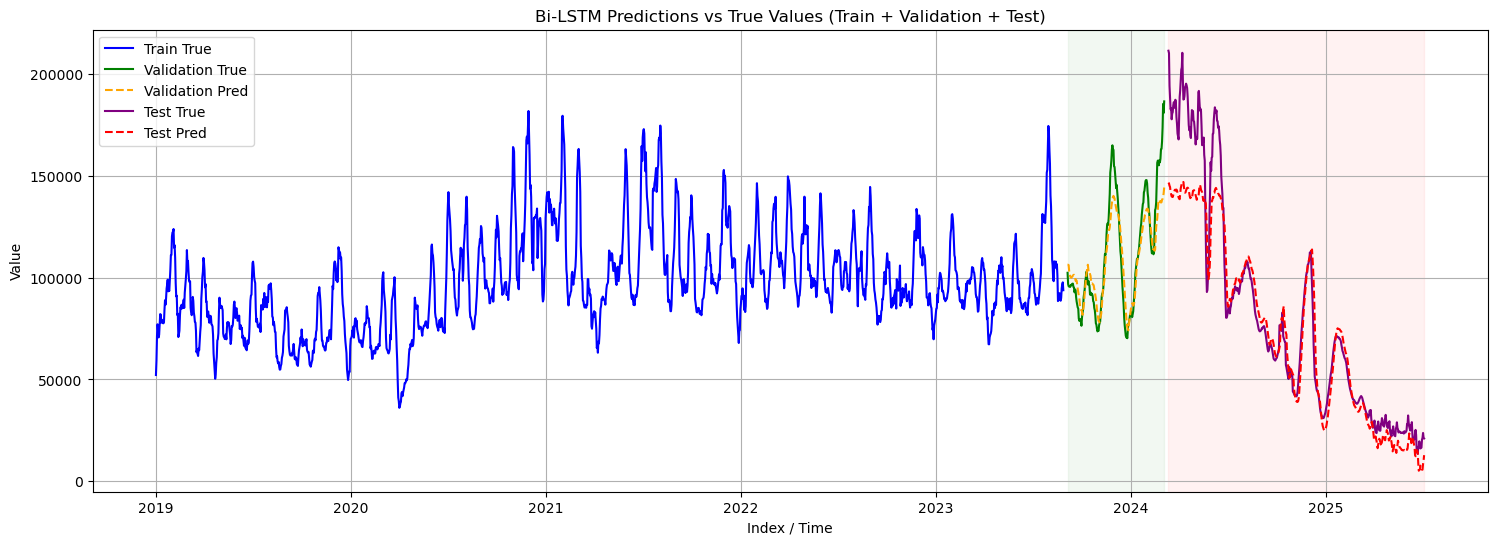

In [66]:
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_bi_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_bi_rescaled,
    title='Bi-LSTM Predictions vs True Values (Train + Validation + Test)'
)


In [67]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_bi_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_bi = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_bi)

        date         Actual      Predicted
0 2024-03-12  211520.485703  146721.281250
1 2024-03-13  210333.857493  146285.281250
2 2024-03-14  194247.388252  145161.484375
3 2024-03-15  188390.754843  144547.984375
4 2024-03-16  182694.630506  142182.656250
5 2024-03-17  183201.054548  140937.109375
6 2024-03-18  177825.201690  139907.546875
7 2024-03-19  180609.199936  140117.187500
8 2024-03-20  181316.293263  139631.203125
9 2024-03-21  184640.662739  140581.906250


# B.  GRU

In [68]:
def build_gru(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First GRU layer
        GRU(64, activation='tanh', return_sequences=True,
            kernel_regularizer=l2(l2_reg), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # Second GRU layer
        GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg)),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the GRU model
gru_model = build_gru(SEQ_LENGTH, n_features, l2_reg=0.0001)
gru_model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 7, 64)          │        13,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,497 (87.88 KB)

 Trainable params: 22,497 (87.88 KB)

 Non-trainable params: 0 (0.00 B)

In [69]:
history_gru = gru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 74ms/step - loss: 0.1055 - mae: 0.2558 - val_loss: 0.0503 - val_mae: 0.1579
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0259 - mae: 0.1029 - val_loss: 0.0300 - val_mae: 0.1169
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0261 - mae: 0.1045 - val_loss: 0.0289 - val_mae: 0.1165
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0230 - mae: 0.1020 - val_loss: 0.0316 - val_mae: 0.1227
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0218 - mae: 0.0976 - val_loss: 0.0304 - val_mae: 0.1211
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0205 - mae: 0.0966 - val_loss: 0.0287 - val_mae: 0.1179
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0212 - mae: 0.0995 - val_loss: 0.0245 - val_mae: 0.1103
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0202 - mae: 0.0990 - val_loss: 0.0251 - val_mae: 0.1110
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - l

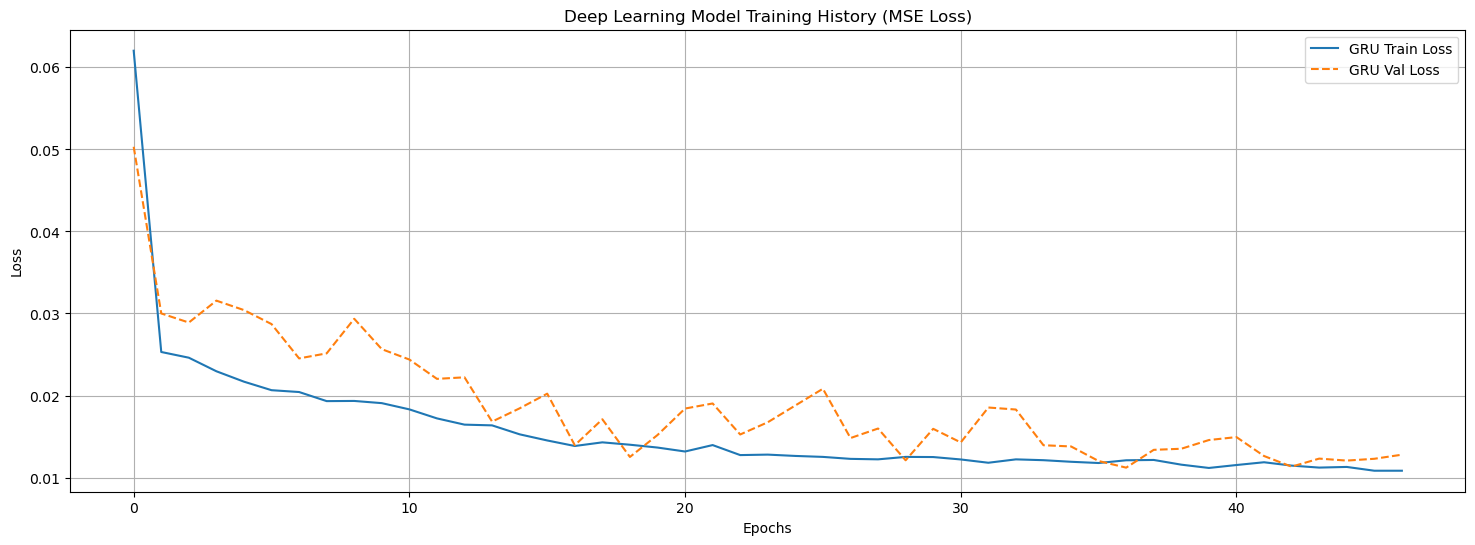

In [70]:
# Call the function
plot_history(
    histories=[history_gru],
    names=[ 'GRU']
)

In [71]:
# Validation predictions
y_val_pred_gru = gru_model.predict(X_val_seq)
# Test predictions
y_test_pred_gru = gru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_gru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_gru.flatten()
}, index=idx_val_seq)

test_pred_gru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_gru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_gru_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_gru_df[['y_true']])

y_test_pred_gru_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_gru_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 29s 3s/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


In [72]:
# --- Evaluate metrics 
metrics_val_gru = evaluate_predictions(
    y_true=val_pred_gru_df ['y_true'],
    y_pred=val_pred_gru_df ['y_pred'],
    set_name='Validation'
)

metrics_test_gru = evaluate_predictions(
    y_true=test_pred_gru_df['y_true'],
    y_pred=test_pred_gru_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_gru = metrics_test_gru['RMSE']
mae_gru  = metrics_test_gru['MAE']
r2_gru   = metrics_test_gru['R2']

# Extract RMSE, MAE, R² for Validation set
rmse_gru_val = metrics_val_gru['RMSE']
mae_gru_val  = metrics_val_gru['MAE']
r2_gru_val   = metrics_val_gru['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0732
RMSE: 0.0974
R2: 0.7588
Evaluation Metrics for Test Set:
MAE: 0.0959
RMSE: 0.1317
R2: 0.8759


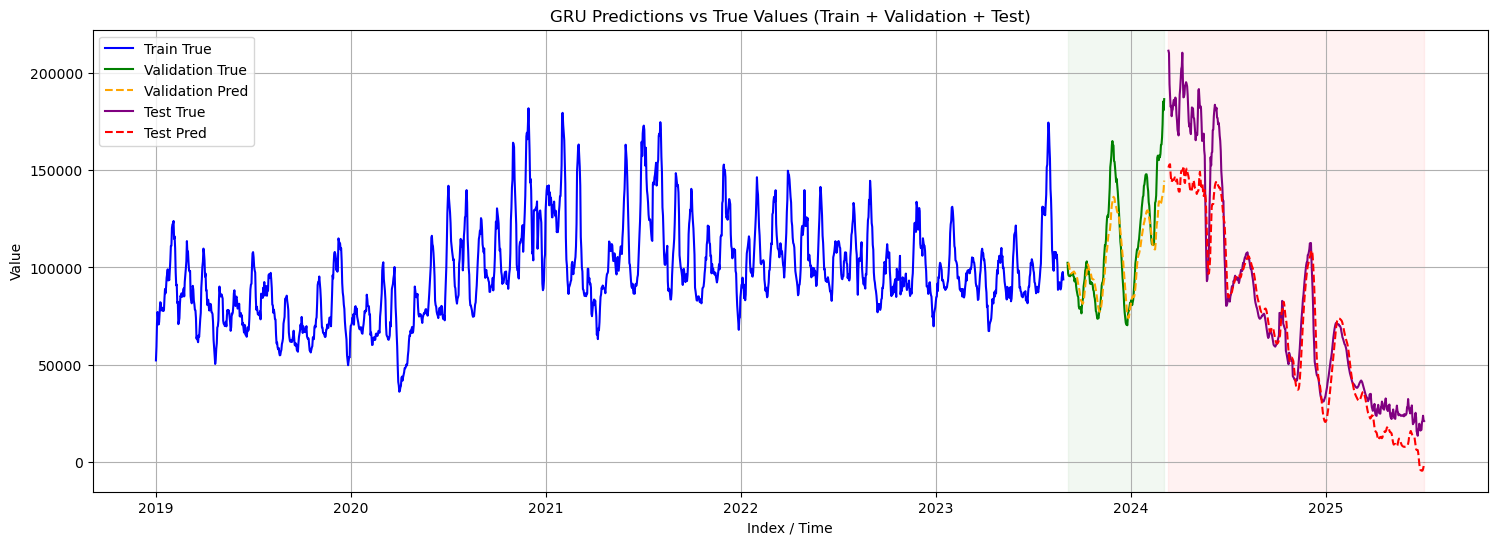

In [73]:
# Plot GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_gru_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_gru_rescaled,
    title='GRU Predictions vs True Values (Train + Validation + Test)'
)

In [74]:
n_display = 10

# Take first n_display predictions and actuals for Bi-LSTM
actual = y_test_true_rescaled[:n_display].flatten()
predicted = y_test_pred_gru_rescaled[:n_display].flatten()
indices = idx_test_seq[:n_display]  # original indices

# Create a DataFrame for comparison
comparison_df_gru = pd.DataFrame({
    'date': indices,
    'Actual': actual,
    'Predicted': predicted
})

print(comparison_df_gru)

        date         Actual      Predicted
0 2024-03-12  211520.485703  151382.531250
1 2024-03-13  210333.857493  152416.062500
2 2024-03-14  194247.388252  152948.906250
3 2024-03-15  188390.754843  153091.921875
4 2024-03-16  182694.630506  148358.187500
5 2024-03-17  183201.054548  144965.343750
6 2024-03-18  177825.201690  143906.015625
7 2024-03-19  180609.199936  145285.062500
8 2024-03-20  181316.293263  144905.625000
9 2024-03-21  184640.662739  144976.890625


# C. Bi-GRU

In [75]:
def build_bigru(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # First Bi-GRU layer
        Bidirectional(GRU(64, activation='tanh', return_sequences=True,
                          kernel_regularizer=l2(l2_reg)),
                      input_shape=(seq_length, n_features)),
        Dropout(0.2),
        
        # Second Bi-GRU layer
        Bidirectional(GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),
        
        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))  # predicting single value
    ])
    
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

# Instantiate the Bi-GRU model
bigru_model = build_bigru(SEQ_LENGTH, n_features, l2_reg=0.0001)
bigru_model.summary()


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ (None, 7, 128)         │        26,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 57,281 (223.75 KB)

 Trainable params: 57,281 (223.75 KB)

 Non-trainable params: 0 (0.00 B)

In [76]:
history_bigru = bigru_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 166s 778ms/step - loss: 0.1011 - mae: 0.2247 - val_loss: 0.0556 - val_mae: 0.1460
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 200ms/step - loss: 0.0350 - mae: 0.1036 - val_loss: 0.0438 - val_mae: 0.1286
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 11s 214ms/step - loss: 0.0301 - mae: 0.0966 - val_loss: 0.0362 - val_mae: 0.1184
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 170ms/step - loss: 0.0277 - mae: 0.0993 - val_loss: 0.0352 - val_mae: 0.1194
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 7s 238ms/step - loss: 0.0260 - mae: 0.0967 - val_loss: 0.0330 - val_mae: 0.1172
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 258ms/step - loss: 0.0227 - mae: 0.0922 - val_loss: 0.0297 - val_mae: 0.1110
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 8s 264ms/step - loss: 0.0208 - mae: 0.0863 - val_loss: 0.0315 - val_mae: 0.1159
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 198ms/step - loss: 0.0202 - mae: 0.0866 - val_loss: 0.0262 - val_mae: 0.1039
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 33

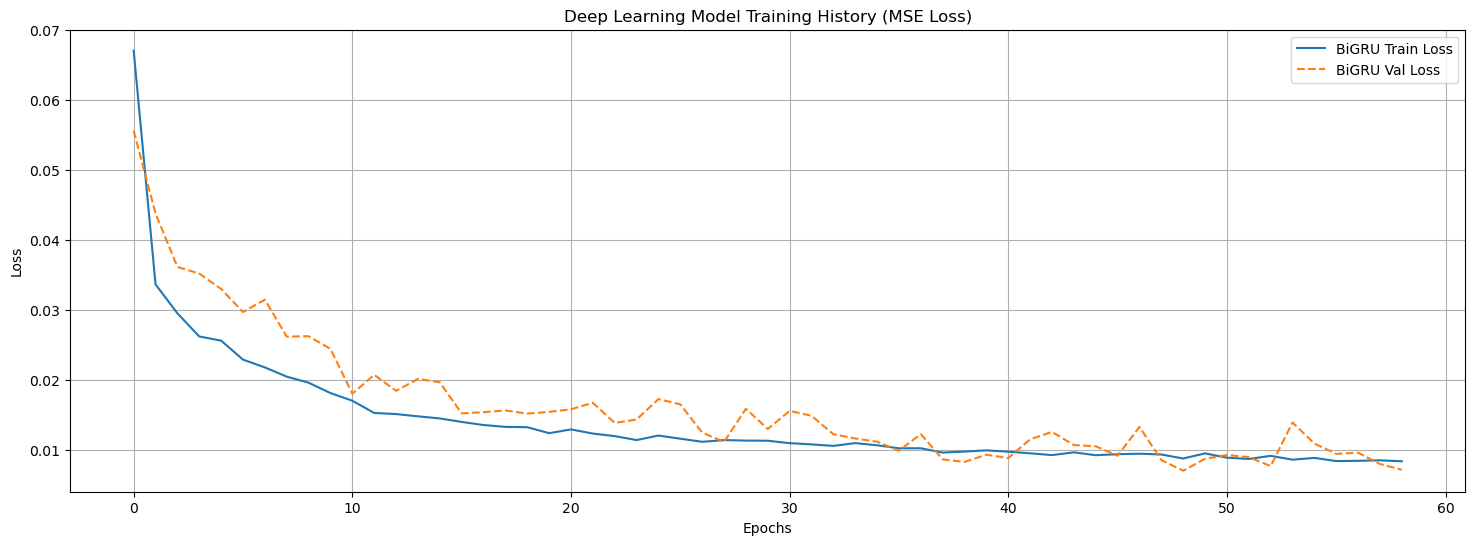

In [77]:
# Call the function
plot_history(
    histories=[history_bigru],
    names=['BiGRU']
)

In [78]:
# Validation predictions
y_val_pred_bigru = bigru_model.predict(X_val_seq)
# Test predictions
y_test_pred_bigru = bigru_model.predict(X_test_seq)

# Map to DataFrame with original indices
val_pred_bigru_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_bigru.flatten()
}, index=idx_val_seq)

test_pred_bigru_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_bigru.flatten()
}, index=idx_test_seq)

# Inverse scaling
y_val_pred_bigru_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_pred']])
y_val_true_rescaled = scaler_y.inverse_transform(val_pred_bigru_df[['y_true']])

y_test_pred_bigru_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_pred']])
y_test_true_rescaled = scaler_y.inverse_transform(test_pred_bigru_df[['y_true']])


6/6 ━━━━━━━━━━━━━━━━━━━━ 7s 651ms/step
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


In [79]:
# --- Evaluate metrics 
metrics_val_bigru = evaluate_predictions(
    y_true=val_pred_bigru_df['y_true'],
    y_pred=val_pred_bigru_df['y_pred'],
    set_name='Validation'
)

metrics_test_bigru = evaluate_predictions(
    y_true=test_pred_bigru_df['y_true'],
    y_pred=test_pred_bigru_df['y_pred'],
    set_name='Test'
)

# Extract RMSE, MAE, R² for test set
rmse_bigru= metrics_test_bigru['RMSE']
mae_bigru  = metrics_test_bigru['MAE']
r2_bigru  = metrics_test_bigru['R2']


# Extract metrics for Validation set
rmse_bigru_val = metrics_val_bigru['RMSE']
mae_bigru_val  = metrics_val_bigru['MAE']
r2_bigru_val   = metrics_val_bigru['R2']


Evaluation Metrics for Validation Set:
MAE: 0.0528
RMSE: 0.0743
R2: 0.8597
Evaluation Metrics for Test Set:
MAE: 0.0770
RMSE: 0.1097
R2: 0.9139


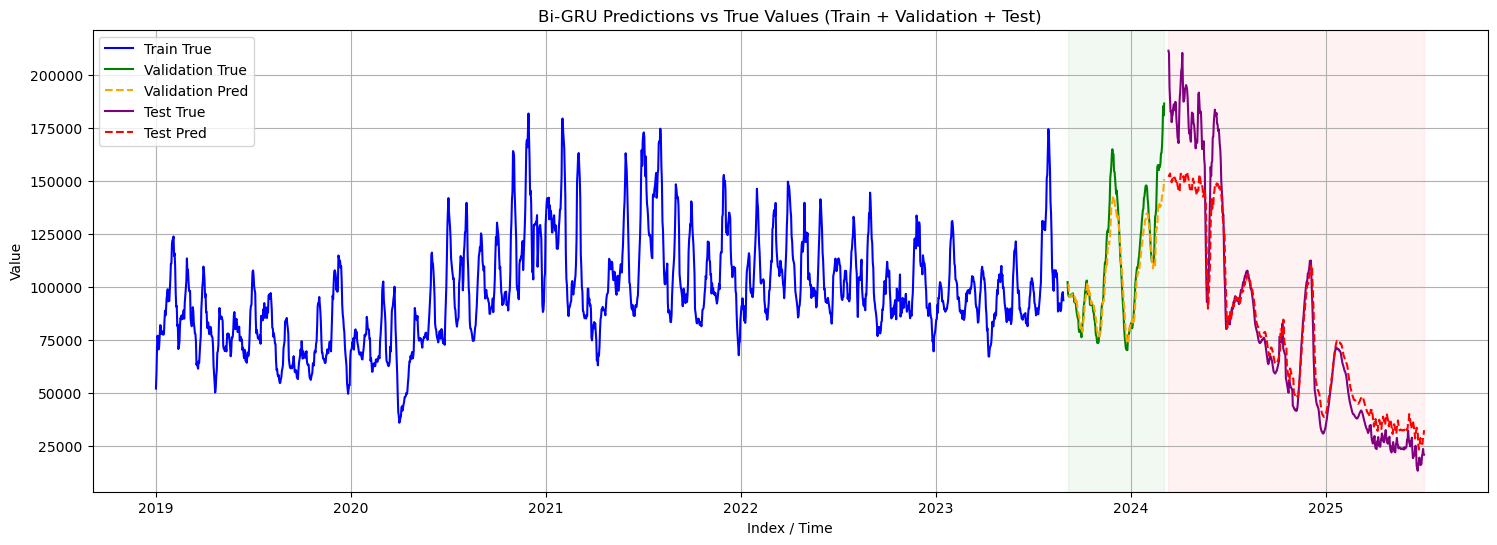

In [80]:
# Plot Bi-GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_bigru_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_bigru_rescaled,
    title='Bi-GRU Predictions vs True Values (Train + Validation + Test)'
)

# Hybrid model

In [81]:
def build_bilstm_bigru_hybrid(seq_length, n_features, l2_reg=0.0001):
    model = Sequential([
        # 1st Bi-LSTM layer
        Bidirectional(LSTM(64, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg)), input_shape=(seq_length, n_features)),
        Dropout(0.2),

        # 2nd Bi-LSTM layer
        Bidirectional(LSTM(32, activation='tanh', return_sequences=True,
                           kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # 1st Bi-GRU layer
        Bidirectional(GRU(64, activation='tanh', return_sequences=True,
                          kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # 2nd Bi-GRU layer
        Bidirectional(GRU(32, activation='tanh', kernel_regularizer=l2(l2_reg))),
        Dropout(0.2),

        # Output layer
        Dense(1, kernel_regularizer=l2(l2_reg))
    ])

    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model


# Instantiate 4-layer hybrid model
hybrid_model = build_bilstm_bigru_hybrid(SEQ_LENGTH, n_features, l2_reg=0.0001)
hybrid_model.summary()


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ (None, 7, 128)         │        34,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_5 (Bidirectional) │ (None, 7, 64)          │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 7, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_6 (Bidirectional) │ (None, 7, 128)         │        49,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 7, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_7 (Bidirectional) │ (None, 64)             │        31,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 156,609 (611.75 KB)

 Trainable params: 156,609 (611.75 KB)

 Non-trainable params: 0 (0.00 B)

In [82]:
history_hybrid= hybrid_model.fit(
    X_train_seq, y_train_seq,
    validation_data=(X_val_seq, y_val_seq),
    epochs=Epochs,
    batch_size=Batch_size,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 56s 293ms/step - loss: 0.1510 - mae: 0.2333 - val_loss: 0.0744 - val_mae: 0.1256
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 102ms/step - loss: 0.0652 - mae: 0.1123 - val_loss: 0.0672 - val_mae: 0.1327
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 93ms/step - loss: 0.0495 - mae: 0.0989 - val_loss: 0.0536 - val_mae: 0.1217
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 0.0417 - mae: 0.0962 - val_loss: 0.0364 - val_mae: 0.0970
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0346 - mae: 0.0892 - val_loss: 0.0396 - val_mae: 0.1079
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0301 - mae: 0.0856 - val_loss: 0.0284 - val_mae: 0.0865
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0260 - mae: 0.0787 - val_loss: 0.0275 - val_mae: 0.0842
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - loss: 0.0235 - mae: 0.0737 - val_loss: 0.0226 - val_mae: 0.0742
Epoch 9/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step -

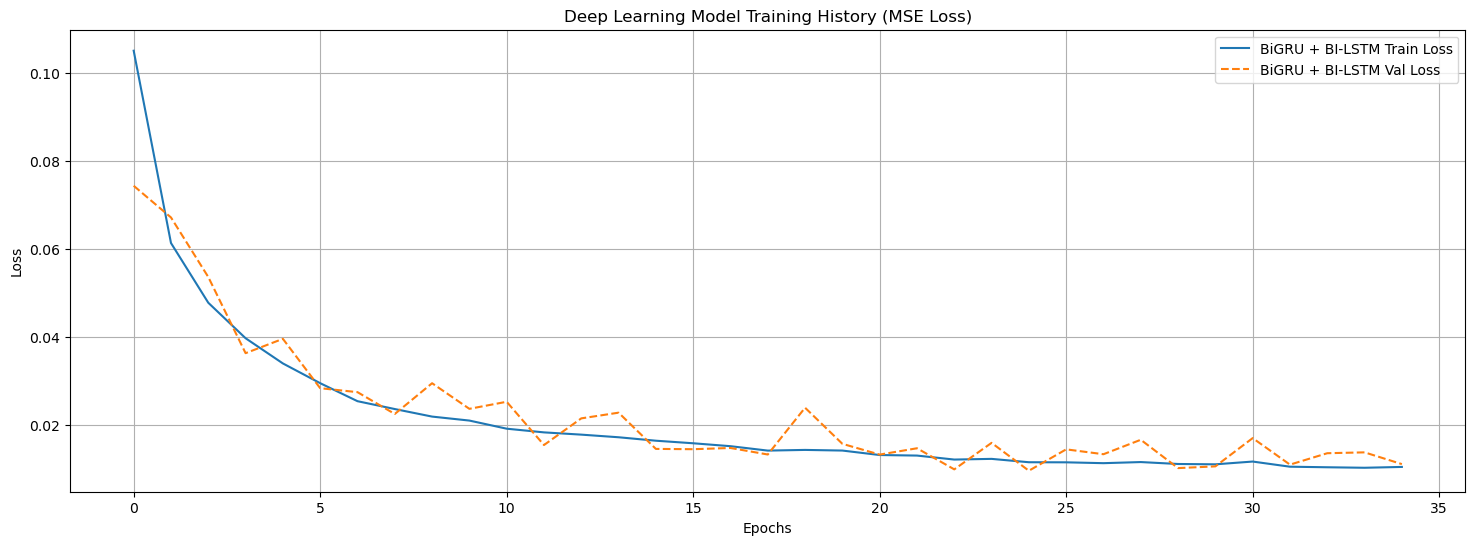

In [83]:
# Call the function
plot_history(
    histories=[history_hybrid],
    names=['BiGRU + BI-LSTM']
)

In [84]:
# --- Predictions ---
# Validation
y_val_pred_hybrid = hybrid_model.predict(X_val_seq, verbose=0)
# Test
y_test_pred_hybrid = hybrid_model.predict(X_test_seq, verbose=0)

# --- Map predictions to DataFrames using original indices ---
val_pred_hybrid_df = pd.DataFrame({
    'y_true': y_val_seq.flatten(),
    'y_pred': y_val_pred_hybrid.flatten()
}, index=idx_val_seq)

test_pred_hybrid_df = pd.DataFrame({
    'y_true': y_test_seq.flatten(),
    'y_pred': y_test_pred_hybrid.flatten()
}, index=idx_test_seq)

# --- Inverse scaling if target was scaled ---
y_val_pred_hybrid_rescaled = scaler_y.inverse_transform(val_pred_hybrid_df[['y_pred']])
y_val_true_hybrid_rescaled = scaler_y.inverse_transform(val_pred_hybrid_df[['y_true']])

y_test_pred_hybrid_rescaled = scaler_y.inverse_transform(test_pred_hybrid_df[['y_pred']])
y_test_true_hybrid_rescaled = scaler_y.inverse_transform(test_pred_hybrid_df[['y_true']])


In [85]:
# --- Evaluate metrics 
metrics_val_hybrid = evaluate_predictions(
    y_true=val_pred_hybrid_df['y_true'],
    y_pred=val_pred_hybrid_df['y_pred'],
    set_name='Validation'
)

metrics_test_hybrid = evaluate_predictions(
    y_true=test_pred_hybrid_df['y_true'],
    y_pred=test_pred_hybrid_df['y_pred'],
    set_name='Test'
)

# --- Extract metrics for Test set ---
rmse_hybrid = metrics_test_hybrid['RMSE']
mae_hybrid  = metrics_test_hybrid['MAE']
r2_hybrid   = metrics_test_hybrid['R2']

# --- Extract metrics for Validation set ---
rmse_hybrid_val = metrics_val_hybrid['RMSE']
mae_hybrid_val  = metrics_val_hybrid['MAE']
r2_hybrid_val   = metrics_val_hybrid['R2']



Evaluation Metrics for Validation Set:
MAE: 0.0530
RMSE: 0.0757
R2: 0.8544
Evaluation Metrics for Test Set:
MAE: 0.0808
RMSE: 0.1242
R2: 0.8896


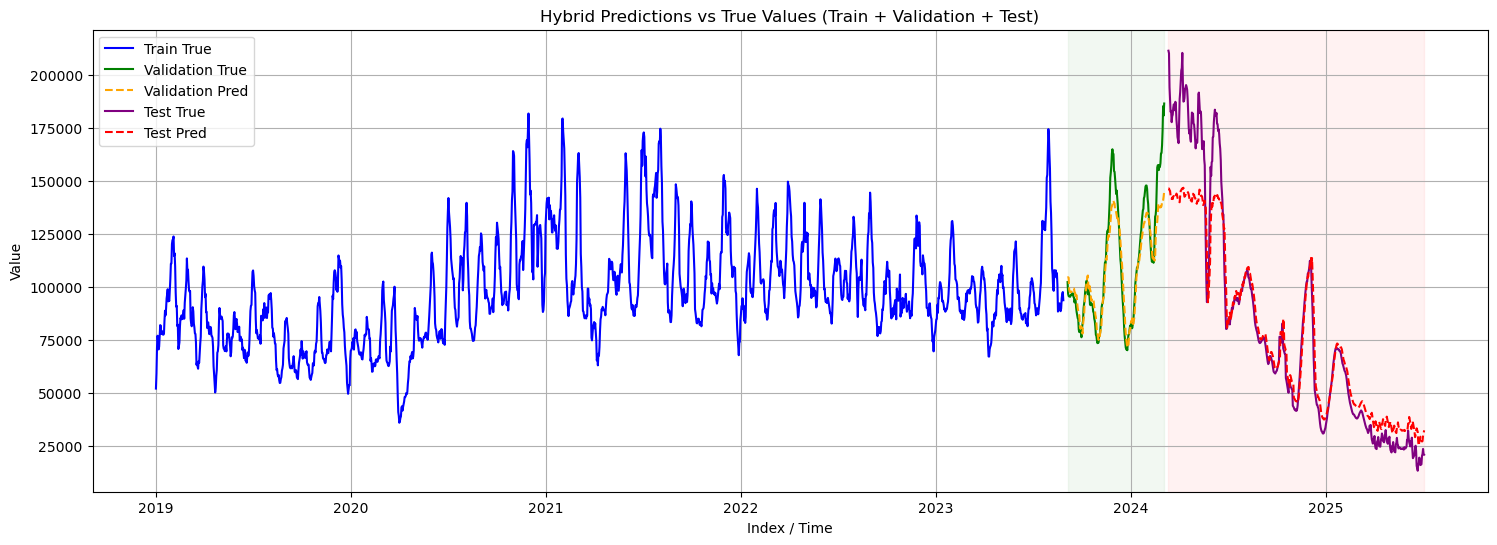

In [86]:
# Plot Bi-GRU predictions with full timeline
plot_predictions_full(
    idx_train=train.index, y_train=train['Value_denoised'],  # training true values
    idx_val=idx_val_seq, y_val_true=y_val_true_rescaled, y_val_pred=y_val_pred_hybrid_rescaled,
    idx_test=idx_test_seq, y_test_true=y_test_true_rescaled, y_test_pred=y_test_pred_hybrid_rescaled,
    title='Hybrid Predictions vs True Values (Train + Validation + Test)'
)

# RESULTS

In [87]:
# --- Plot actual values ---
fig = go.Figure()

# Actual series
fig.add_trace(go.Scatter(x=train.index, y=scaler_y.inverse_transform(y_train_df).flatten(),
                         mode='lines', name='Train Actual', line=dict(color='black')))
fig.add_trace(go.Scatter(x=val.index, y=scaler_y.inverse_transform(y_val_df).flatten(),
                         mode='lines', name='Val Actual', line=dict(color='gray')))
fig.add_trace(go.Scatter(x=test.index, y=scaler_y.inverse_transform(y_test_df).flatten(),
                         mode='lines', name='Test Actual', line=dict(color='darkgray')))

# --- Validation predictions (lighter, same color as test) ---
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Val Pred', line=dict(color='rgba(0,0,255,0.4)')))       # blue
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Val Pred', line=dict(color='rgba(255,165,0,0.4)')))  # orange
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Val Pred', line=dict(color='rgba(0,128,0,0.4)')))       # green
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Val Pred', line=dict(color='rgba(128,0,128,0.4)')))   # purple
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_hybrid_rescaled.flatten(),
                         mode='lines', name='Hybrid Val Pred', line=dict(color='rgba(165,42,42,0.4)')))   # brown
fig.add_trace(go.Scatter(x=val.index, y=y_val_pred_arimax_rescaled.flatten(),
                         mode='lines', name='SARIMAX Val Pred', line=dict(color='rgba(255,0,0,0.4)')))     # red

# --- Test predictions (solid, same color) ---
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_lstm_rescaled.flatten(),
                         mode='lines', name='LSTM Test Pred', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_bi_rescaled.flatten(),
                         mode='lines', name='Bi-LSTM Test Pred', line=dict(color='orange')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_gru_rescaled.flatten(),
                         mode='lines', name='GRU Test Pred', line=dict(color='green')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_bigru_rescaled.flatten(),
                         mode='lines', name='Bi-GRU Test Pred', line=dict(color='purple')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_hybrid_rescaled.flatten(),
                         mode='lines', name='Hybrid Test Pred', line=dict(color='brown')))
fig.add_trace(go.Scatter(x=test.index, y=y_test_pred_arimax_rescaled.flatten(),
                         mode='lines', name='SARIMAX Test Pred', line=dict(color='red')))

# --- Layout ---
fig.update_layout(
    title='Train, Validation, and Test Predictions: SARIMAX & DL Models',
    xaxis_title='Index',
    yaxis_title='Value',
    template='plotly_white',
    hovermode='x unified',
    legend=dict(x=0.01, y=0.99)
)

fig.show()


In [88]:
# --- Metrics for Validation set ---
metrics_val_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Hybrid'],
    'Dataset': 'Validation',
    'RMSE': [rmse_arimax_val, rmse_lstm_val, rmse_bilstm_val, rmse_gru_val, rmse_bigru_val, rmse_hybrid_val],
    'MAE':  [mae_arimax_val, mae_lstm_val, mae_bilstm_val, mae_gru_val, mae_bigru_val, mae_hybrid_val],
    'R²':   [r2_arimax_val, r2_lstm_val, r2_bilstm_val, r2_gru_val, r2_bigru_val, r2_hybrid_val]
})

# Display
metrics_val_df

Model     Dataset      RMSE       MAE        R²
0   ARIMAX  Validation  0.396418  0.325417 -3.124780
1     LSTM  Validation  0.121159  0.093118  0.627029
2  Bi-LSTM  Validation  0.084280  0.063657  0.819525
3      GRU  Validation  0.097430  0.073184  0.758815
4   Bi-GRU  Validation  0.074318  0.052778  0.859667
5   Hybrid  Validation  0.075699  0.052977  0.854406

In [89]:
# --- Metrics for Testing set ---
metrics_df = pd.DataFrame({
    'Model': ['ARIMAX', 'LSTM', 'Bi-LSTM', 'GRU', 'Bi-GRU', 'Hybrid'],
    'Dataset': 'Test',
    'RMSE': [rmse_arimax, rmse_lstm, rmse_bilstm, rmse_gru, rmse_bigru, rmse_hybrid],
    'MAE':  [mae_arimax, mae_lstm, mae_bilstm, mae_gru, mae_bigru, mae_hybrid],
    'R²':   [r2_arimax, r2_lstm, r2_bilstm, r2_gru, r2_bigru, r2_hybrid]
})

metrics_df

Model Dataset      RMSE       MAE        R²
0   ARIMAX    Test  0.367215  0.265956  0.123630
1     LSTM    Test  0.157977  0.106080  0.821315
2  Bi-LSTM    Test  0.129089  0.085313  0.880691
3      GRU    Test  0.131681  0.095892  0.875851
4   Bi-GRU    Test  0.109656  0.077049  0.913908
5   Hybrid    Test  0.124190  0.080798  0.889575

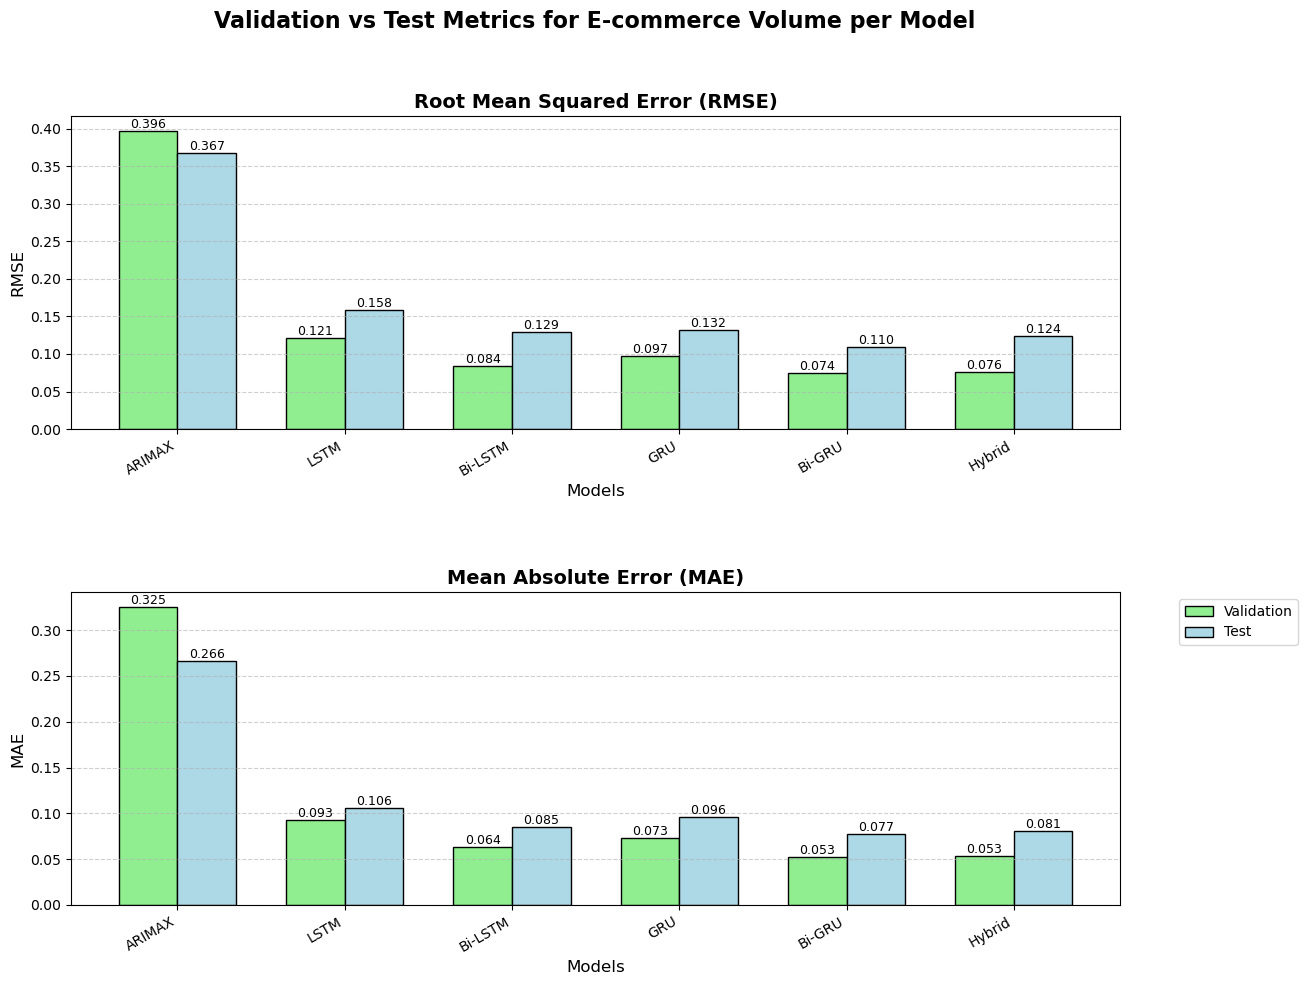

In [90]:
def plot_metrics(metrics_val_df, metrics_test_df):
    models = metrics_val_df['Model']
    metrics_names = ['RMSE', 'MAE']  # remove R²
    titles = ['Root Mean Squared Error (RMSE)', 
              'Mean Absolute Error (MAE)']
    
    width = 0.35
    x = np.arange(len(models))
    
    plt.figure(figsize=(12, 10))  # slightly shorter since only 2 plots
    plt.suptitle('Validation vs Test Metrics for E-commerce Volume per Model', fontsize=16, weight='bold')
    
    for i, metric in enumerate(metrics_names):
        plt.subplot(2, 1, i + 1)
        
        val_values = metrics_val_df[metric]
        test_values = metrics_test_df[metric]
        
        bars_val = plt.bar(x - width/2, val_values, width, label='Validation', color='lightgreen', edgecolor='black')
        bars_test = plt.bar(x + width/2, test_values, width, label='Test', color='lightblue', edgecolor='black')
        
        # Annotate bars
        for bar in bars_val + bars_test:
            height = bar.get_height()
            plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)
        
        plt.title(titles[i], fontsize=14, weight='bold')
        plt.xlabel('Models', fontsize=12)
        plt.ylabel(metric, fontsize=12)
        plt.xticks(x, models, rotation=30, ha='right')
        plt.grid(axis='y', linestyle='--', alpha=0.6)
    
    plt.tight_layout(rect=[0, 0, 0.95, 0.95], h_pad=5)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.show()

# Call the function
plot_metrics(metrics_val_df, metrics_df)


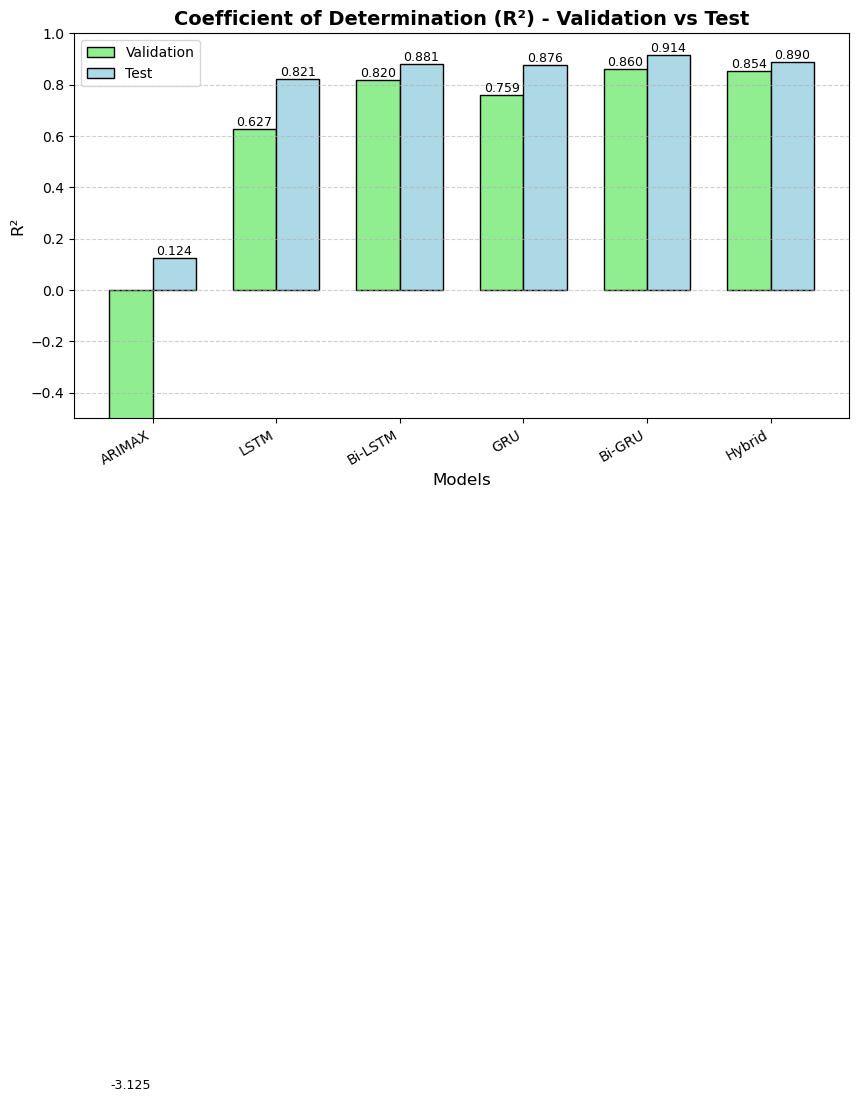

In [91]:
# Models and R² values
models = metrics_val_df['Model']
x = np.arange(len(models))
width = 0.35

# Extract R²
r2_val = metrics_val_df['R²'].astype(float)   # ensure numeric
r2_test = metrics_df['R²'].astype(float)      # ensure numeric

plt.figure(figsize=(10, 5))

# Plot Validation and Test bars
bars_val = plt.bar(x - width/2, r2_val, width, label='Validation', color='lightgreen', edgecolor='black')
bars_test = plt.bar(x + width/2, r2_test, width, label='Test', color='lightblue', edgecolor='black')

# Annotate bars
for bar in bars_val + bars_test:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height, f'{height:.3f}', ha='center', va='bottom', fontsize=9)

# Titles and labels
plt.title('Coefficient of Determination (R²) - Validation vs Test', fontsize=14, weight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.xticks(x, models, rotation=30, ha='right')
plt.ylim(-0.5, 1)  # accommodate negative R² values
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


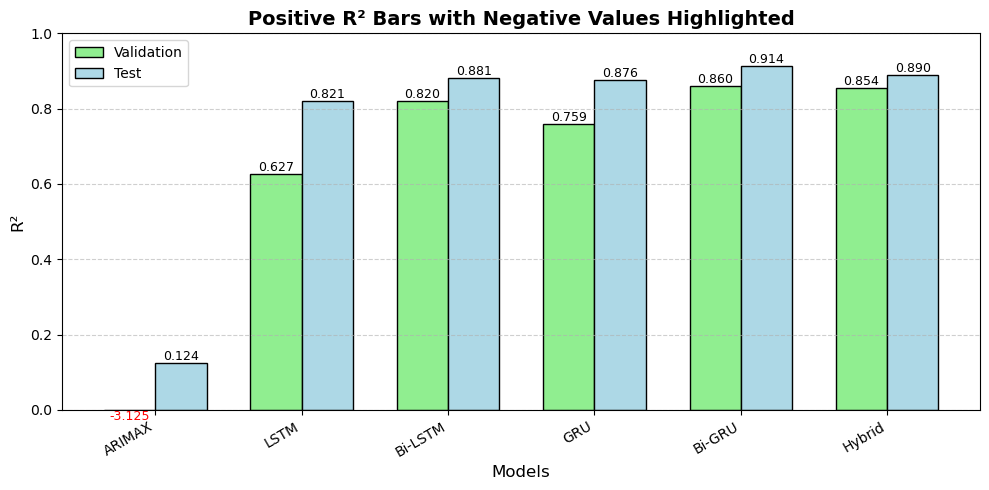

In [92]:
import matplotlib.pyplot as plt
import numpy as np

# Models
models = metrics_val_df['Model']
x = np.arange(len(models))
width = 0.35

# Clip R² to zero for plotting bars
r2_val_pos = metrics_val_df['R²'].clip(lower=0)
r2_test_pos = metrics_df['R²'].clip(lower=0)

# Original R² values for annotation (including negatives)
r2_val_orig = metrics_val_df['R²']
r2_test_orig = metrics_df['R²']

plt.figure(figsize=(10, 5))

# Plot bars
bars_val = plt.bar(x - width/2, r2_val_pos, width, label='Validation', color='lightgreen', edgecolor='black')
bars_test = plt.bar(x + width/2, r2_test_pos, width, label='Test', color='lightblue', edgecolor='black')

# Annotate bars with original values
for i, bar in enumerate(bars_val):
    height = r2_val_orig[i]
    va = 'bottom' if height >= 0 else 'top'
    color = 'red' if height < 0 else 'black'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{height:.3f}', ha='center', va=va, fontsize=9, color=color)

for i, bar in enumerate(bars_test):
    height = r2_test_orig[i]
    va = 'bottom' if height >= 0 else 'top'
    color = 'red' if height < 0 else 'black'
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f'{height:.3f}', ha='center', va=va, fontsize=9, color=color)

# Titles and labels
plt.title('Positive R² Bars with Negative Values Highlighted', fontsize=14, weight='bold')
plt.xlabel('Models', fontsize=12)
plt.ylabel('R²', fontsize=12)
plt.xticks(x, models, rotation=30, ha='right')
plt.ylim(0, 1)  # positive bars only
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend()
plt.tight_layout()
plt.show()


# walk-forward validation

In [93]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pandas as pd
import numpy as np

def walk_forward_sarimax(order, y_train_df, X_train_df, y_val_df, X_val_df, y_test_df, X_test_df):
    """
    Walk-forward validation for SARIMAX.
    """
    # --- Fit model on training set ---
    model = SARIMAX(
        endog=y_train_df,
        exog=X_train_df,
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    result = model.fit(method="powell", disp=False)
    
    # --- Forecast validation set ---
    val_forecast = result.get_forecast(steps=len(y_val_df), exog=X_val_df)
    y_val_pred = val_forecast.predicted_mean.values
    
    # --- Forecast test set ---
    full_model = SARIMAX(
        endog=pd.concat([y_train_df, y_val_df]),
        exog=pd.concat([X_train_df, X_val_df]),
        order=order,
        enforce_stationarity=False,
        enforce_invertibility=False
    )
    
    full_result = full_model.fit(method="powell", disp=False)
    
    test_forecast = full_result.get_forecast(steps=len(y_test_df), exog=X_test_df)
    y_test_pred = test_forecast.predicted_mean.values
    
    # --- Wrap into DataFrames with indices ---
    val_preds_df = pd.DataFrame({
        "y_true": y_val_df.values.flatten(),
        "y_pred": y_val_pred.flatten()
    }, index=y_val_df.index)

    test_preds_df = pd.DataFrame({
        "y_true": y_test_df.values.flatten(),
        "y_pred": y_test_pred.flatten()
    }, index=y_test_df.index)
    
    return val_preds_df, test_preds_df, result


# Sarimax + Validation

In [94]:
# Choose SARIMAX order
sarimax_order = (2,0,1)

# Run walk-forward
val_preds_sarimax, test_preds_sarimax, sarimax_model = walk_forward_sarimax(
    order=sarimax_order,
    y_train_df=y_train_df, X_train_df=X_train_df,
    y_val_df=y_val_df, X_val_df=X_val_df,
    y_test_df=y_test_df, X_test_df=X_test_df
)

# --- Evaluate ---
metrics_val_sarimax = evaluate_predictions(val_preds_sarimax["y_true"], val_preds_sarimax["y_pred"], set_name="Validation")
metrics_test_sarimax = evaluate_predictions(test_preds_sarimax["y_true"], test_preds_sarimax["y_pred"], set_name="Test")

# Extract metrics
rmse_sarimax_val, mae_sarimax_val, r2_sarimax_val = metrics_val_sarimax.values()
rmse_sarimax, mae_sarimax, r2_sarimax = metrics_test_sarimax.values()


c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

c:\Users\mareg\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



Evaluation Metrics for Validation Set:
MAE: 0.3052
RMSE: 0.3765
R2: -2.7199
Evaluation Metrics for Test Set:
MAE: 0.1170
RMSE: 0.1571
R2: 0.8396


In [95]:
def walk_forward_corrected(model_fn, 
                          X_train_seq, y_train_seq, 
                          X_val_seq, y_val_seq, 
                          X_test_seq, y_test_seq,
                          seq_length, 
                          epochs=50, batch_size=32, 
                          verbose=0, retrain_frequency=5):
    """
    Corrected walk-forward validation with proper time series handling.
    
    Args:
        retrain_frequency: How often to retrain model (reduces overfitting)
    """
    
    n_features = X_train_seq.shape[2]
    
    # Initialize model once
    model = model_fn(seq_length, n_features)
    
    # Early stopping for initial training only
    early_stop = EarlyStopping(
        monitor="val_loss",
        patience=5,
        restore_best_weights=True,
        verbose=verbose
    )
    
    # --- Initial Training ---
    print("Initial training on base dataset...")
    history = model.fit(
        X_train_seq, y_train_seq,
        validation_data=(X_val_seq, y_val_seq),  # Use explicit validation
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose,
        callbacks=[early_stop],
        shuffle=False  # CRITICAL: No shuffling for time series
    )
    
    # --- Walk-forward Validation ---
    val_preds = []
    train_X_current = X_train_seq.copy()
    train_y_current = y_train_seq.copy()
    
    for i in range(len(X_val_seq)):
        if verbose > 0:
            print(f"Validation step {i+1}/{len(X_val_seq)}")
        
        # Predict before expanding training set
        y_pred = model.predict(X_val_seq[i:i+1], verbose=0)[0, 0]
        val_preds.append(y_pred)
        
        # Only retrain periodically to prevent overfitting
        if (i % retrain_frequency == 0) or (i == len(X_val_seq) - 1):
            if verbose > 0:
                print(f"Retraining model at step {i}...")
            
            # Expand training window
            train_X_current = np.vstack([train_X_current, X_val_seq[:i+1]])
            train_y_current = np.vstack([train_y_current, y_val_seq[:i+1]])
            
            # Retrain with very few epochs to adapt gradually
            model.fit(
                train_X_current, train_y_current,
                epochs=3,  # Few epochs to prevent overfitting
                batch_size=batch_size,
                verbose=0,
                shuffle=False
            )
    
    val_preds = np.array(val_preds)
    
    # --- Walk-forward Test ---
    test_preds = []
    
    # Include validation data in final training
    train_X_final = np.vstack([X_train_seq, X_val_seq])
    train_y_final = np.vstack([y_train_seq, y_val_seq])
    
    # Final training before test
    model.fit(
        train_X_final, train_y_final,
        epochs=10,  # Final tuning
        batch_size=batch_size,
        verbose=verbose,
        shuffle=False
    )
    
    # Test walk-forward (usually you wouldn't retrain during test in real scenarios)
    for i in range(len(X_test_seq)):
        y_pred = model.predict(X_test_seq[i:i+1], verbose=0)[0, 0]
        test_preds.append(y_pred)
        
        # In real testing, you typically don't retrain on test data
        # This maintains the integrity of your test set evaluation
    
    test_preds = np.array(test_preds)
    
    # Calculate metrics
    val_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_val_seq, val_preds)),
        "MAE": mean_absolute_error(y_val_seq, val_preds),
        "R2": r2_score(y_val_seq, val_preds),
        "MAPE": np.mean(np.abs((y_val_seq - val_preds) / y_val_seq)) * 100
    }
    
    test_metrics = {
        "RMSE": np.sqrt(mean_squared_error(y_test_seq, test_preds)),
        "MAE": mean_absolute_error(y_test_seq, test_preds),
        "R2": r2_score(y_test_seq, test_preds),
        "MAPE": np.mean(np.abs((y_test_seq - test_preds) / y_test_seq)) * 100
    }
    
    return {
        "Validation": {"metrics": val_metrics, "preds": val_preds},
        "Test": {"metrics": test_metrics, "preds": test_preds},
        "model": model,
        "final_train_size": train_X_final.shape[0]
    }

In [96]:
def walk_forward_named(model_name, model_fn,
                       X_train_seq, y_train_seq,
                       X_val_seq, y_val_seq,
                       X_test_seq, y_test_seq,
                       seq_length,
                       epochs=50, batch_size=32,
                       retrain_frequency=5, verbose=0):
    """
    Walk-forward validation + test with automatic named metrics.

    Returns:
        metrics_df: DataFrame with Validation & Test metrics
        val_preds: array of validation predictions
        test_preds: array of test predictions
        trained_model: final trained model
        metrics_named: dict with named metrics (e.g., rmse_lstm_val)
    """
    results = walk_forward_corrected(
        model_fn=model_fn,
        X_train_seq=X_train_seq, y_train_seq=y_train_seq,
        X_val_seq=X_val_seq, y_val_seq=y_val_seq,
        X_test_seq=X_test_seq, y_test_seq=y_test_seq,
        seq_length=seq_length,
        epochs=epochs,
        batch_size=batch_size,
        verbose=verbose
    )

    val_metrics = results["Validation"]["metrics"]
    test_metrics = results["Test"]["metrics"]
    
    # Create metrics DataFrame
    metrics_df = pd.DataFrame([
        {
            "Model": model_name,
            "Dataset": "Validation",
            "RMSE": val_metrics["RMSE"],
            "MAE": val_metrics["MAE"],
            "R2": val_metrics["R2"],
            "MAPE": val_metrics.get("MAPE", np.nan)
        },
        {
            "Model": model_name,
            "Dataset": "Test",
            "RMSE": test_metrics["RMSE"],
            "MAE": test_metrics["MAE"],
            "R2": test_metrics["R2"],
            "MAPE": test_metrics.get("MAPE", np.nan)
        }
    ])

    # Create named metrics for easy access
    prefix = model_name.lower().replace("-", "_")
    metrics_named = {
        f"rmse_{prefix}_val": val_metrics["RMSE"],
        f"mae_{prefix}_val": val_metrics["MAE"],
        f"r2_{prefix}_val": val_metrics["R2"],
        f"rmse_{prefix}_test": test_metrics["RMSE"],
        f"mae_{prefix}_test": test_metrics["MAE"],
        f"r2_{prefix}_test": test_metrics["R2"]
    }
    
    return metrics_df, results["Validation"]["preds"], results["Test"]["preds"], results["model"], metrics_named


# a. LSTM + Validation

In [97]:
metrics_df_lstm, val_preds_lstm, test_preds_lstm, model_lstm, metrics_named_lstm = walk_forward_named(
    model_name="LSTM",
    model_fn=build_lstm,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_lstm)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 26s 147ms/step - loss: 0.0778 - mae: 0.2278 - val_loss: 0.0358 - val_mae: 0.1261
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0297 - mae: 0.1107 - val_loss: 0.0275 - val_mae: 0.1229
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0341 - mae: 0.1318 - val_loss: 0.0268 - val_mae: 0.1194
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.0312 - mae: 0.1273 - val_loss: 0.0256 - val_mae: 0.1172
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0294 - mae: 0.1244 - val_loss: 0.0246 - val_mae: 0.1157
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0279 - mae: 0.1225 - val_loss: 0.0240 - val_mae: 0.1147
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0276 - mae: 0.1212 - val_loss: 0.0232 - val_mae: 0.1141
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0264 - mae: 0.1179 - val_loss: 0.0232 - val_mae: 0.1131
Epoch 9/100
27/27 

In [98]:
# --- Extract LSTM metrics from metrics_named_lstm ---
rmse_lstm_val = metrics_named_lstm['rmse_lstm_val']
mae_lstm_val  = metrics_named_lstm['mae_lstm_val']
r2_lstm_val   = metrics_named_lstm['r2_lstm_val']

rmse_lstm     = metrics_named_lstm['rmse_lstm_test']
mae_lstm      = metrics_named_lstm['mae_lstm_test']
r2_lstm       = metrics_named_lstm['r2_lstm_test']

# print metrics
print(f"Validation - RMSE: {rmse_lstm_val:.4f}, MAE: {mae_lstm_val:.4f}, R2: {r2_lstm_val:.4f}")
print(f"Test       - RMSE: {rmse_lstm:.4f}, MAE: {mae_lstm:.4f}, R2: {r2_lstm:.4f}")


Validation - RMSE: 0.0841, MAE: 0.0658, R2: 0.8202
Test       - RMSE: 0.1343, MAE: 0.1046, R2: 0.8708


# Bi-LSTM + validation 

In [99]:
metrics_df_bilstm, val_preds_bilstm, test_preds_bilstm, model_bilstm, metrics_named_bilstm = walk_forward_named(
    model_name="BI-LSTM",
    model_fn=build_bilstm,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_bilstm)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 14s 98ms/step - loss: 0.0859 - mae: 0.2087 - val_loss: 0.0637 - val_mae: 0.1582
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0359 - mae: 0.0972 - val_loss: 0.0369 - val_mae: 0.1177
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0361 - mae: 0.1129 - val_loss: 0.0298 - val_mae: 0.1139
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0343 - mae: 0.1198 - val_loss: 0.0264 - val_mae: 0.1103
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0325 - mae: 0.1206 - val_loss: 0.0242 - val_mae: 0.1061
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0296 - mae: 0.1150 - val_loss: 0.0231 - val_mae: 0.1043
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0264 - mae: 0.1098 - val_loss: 0.0216 - val_mae: 0.1015
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0260 - mae: 0.1089 - val_loss: 0.0209 - val_mae: 0.0996
Epoch 9/100
27/27 ━

In [100]:
# --- Extract Bi-LSTM metrics from metrics_named_bilstm ---
rmse_bi_lstm_val = metrics_named_bilstm['rmse_bi_lstm_val']
mae_bi_lstm_val  = metrics_named_bilstm['mae_bi_lstm_val']
r2_bi_lstm_val   = metrics_named_bilstm['r2_bi_lstm_val']

rmse_bi_lstm    = metrics_named_bilstm['rmse_bi_lstm_test']
mae_bi_lstm      = metrics_named_bilstm['mae_bi_lstm_test']
r2_bi_lstm       = metrics_named_bilstm['r2_bi_lstm_test']

# print metrics
print(f"Validation - RMSE: {rmse_bi_lstm_val:.4f}, MAE: {mae_bi_lstm_val:.4f}, R2: {r2_bi_lstm_val:.4f}")
print(f"Test       - RMSE: {rmse_bi_lstm:.4f}, MAE: {mae_bi_lstm:.4f}, R2: {r2_bi_lstm:.4f}")


Validation - RMSE: 0.0789, MAE: 0.0574, R2: 0.8419
Test       - RMSE: 0.1765, MAE: 0.1395, R2: 0.7771


# GRU + Validation

In [101]:
metrics_df_gru, val_preds_gru, test_preds_gru, model_gru, metrics_named_gru = walk_forward_named(
    model_name="gru",
    model_fn=build_gru,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_gru)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 58ms/step - loss: 0.0586 - mae: 0.1832 - val_loss: 0.0516 - val_mae: 0.1580
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0254 - mae: 0.1005 - val_loss: 0.0279 - val_mae: 0.1196
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0286 - mae: 0.1165 - val_loss: 0.0228 - val_mae: 0.1157
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0305 - mae: 0.1283 - val_loss: 0.0213 - val_mae: 0.1115
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0279 - mae: 0.1239 - val_loss: 0.0203 - val_mae: 0.1073
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0262 - mae: 0.1182 - val_loss: 0.0194 - val_mae: 0.1055
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0257 - mae: 0.1175 - val_loss: 0.0188 - val_mae: 0.1036
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0247 - mae: 0.1162 - val_loss: 0.0183 - val_mae: 0.1018
Epoch 9/100
27/27 ━━━

In [102]:
# --- Extract GRU metrics from metrics_named_gru ---
rmse_gru_val = metrics_named_gru['rmse_gru_val']
mae_gru_val  = metrics_named_gru['mae_gru_val']
r2_gru_val   = metrics_named_gru['r2_gru_val']

rmse_gru     = metrics_named_gru['rmse_gru_test']
mae_gru      = metrics_named_gru['mae_gru_test']
r2_gru       = metrics_named_gru['r2_gru_test']

# print metrics
print(f"Validation - RMSE: {rmse_gru_val:.4f}, MAE: {mae_gru_val:.4f}, R2: {r2_gru_val:.4f}")
print(f"Test       - RMSE: {rmse_gru:.4f}, MAE: {mae_gru:.4f}, R2: {r2_gru:.4f}")


Validation - RMSE: 0.0748, MAE: 0.0576, R2: 0.8577
Test       - RMSE: 0.1208, MAE: 0.0949, R2: 0.8956


In [103]:
metrics_df_bigru, val_preds_bigru, test_preds_bigru, model_bigru, metrics_named_bigru = walk_forward_named(
    model_name="BI-GRU",
    model_fn=build_bigru,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_bigru)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 18s 123ms/step - loss: 0.0639 - mae: 0.1574 - val_loss: 0.0468 - val_mae: 0.1275
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0341 - mae: 0.1001 - val_loss: 0.0386 - val_mae: 0.1187
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0311 - mae: 0.0990 - val_loss: 0.0287 - val_mae: 0.1065
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0298 - mae: 0.1041 - val_loss: 0.0246 - val_mae: 0.1046
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0298 - mae: 0.1138 - val_loss: 0.0219 - val_mae: 0.1000
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0275 - mae: 0.1101 - val_loss: 0.0209 - val_mae: 0.0984
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0266 - mae: 0.1086 - val_loss: 0.0204 - val_mae: 0.0979
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0256 - mae: 0.1094 - val_loss: 0.0193 - val_mae: 0.0951
Epoch 9/100
27/27 

In [104]:
# Extract metrics from metrics_named_bigru
rmse_bi_gru_val = metrics_named_bigru['rmse_bi_gru_val']
mae_bi_gru_val  = metrics_named_bigru['mae_bi_gru_val']
r2_bi_gru_val   = metrics_named_bigru['r2_bi_gru_val']

rmse_bi_gru     = metrics_named_bigru['rmse_bi_gru_test']
mae_bi_gru      = metrics_named_bigru['mae_bi_gru_test']
r2_bi_gru       = metrics_named_bigru['r2_bi_gru_test']

# Print metrics
print(f"Bi-GRU Validation - RMSE: {rmse_bi_gru_val:.4f}, MAE: {mae_bi_gru_val:.4f}, R2: {r2_bi_gru_val:.4f}")
print(f"Bi-GRU Test       - RMSE: {rmse_bi_gru:.4f}, MAE: {mae_bi_gru:.4f}, R2: {r2_bi_gru:.4f}")


Bi-GRU Validation - RMSE: 0.0769, MAE: 0.0603, R2: 0.8499
Bi-GRU Test       - RMSE: 0.1488, MAE: 0.1211, R2: 0.8415


# hybrid + Validation

In [105]:
metrics_df_hybrid, val_preds_hybrid, test_preds_hybrid, model_hybrid, metrics_named_hybrid = walk_forward_named(
    model_name=" hybrid",
    model_fn= build_bilstm_bigru_hybrid,
    X_train_seq=X_train_seq, y_train_seq=y_train_seq,
    X_val_seq=X_val_seq, y_val_seq=y_val_seq,
    X_test_seq=X_test_seq, y_test_seq=y_test_seq,
    seq_length=SEQ_LENGTH,
    epochs=Epochs,
    batch_size=Batch_size,
    retrain_frequency=5,
    verbose=1
)

print(metrics_named_hybrid)


Initial training on base dataset...
Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 20s 106ms/step - loss: 0.1090 - mae: 0.1685 - val_loss: 0.0934 - val_mae: 0.1579
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0649 - mae: 0.1095 - val_loss: 0.0907 - val_mae: 0.1793
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0507 - mae: 0.0995 - val_loss: 0.0734 - val_mae: 0.1606
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0446 - mae: 0.1028 - val_loss: 0.0650 - val_mae: 0.1543
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0412 - mae: 0.1056 - val_loss: 0.0535 - val_mae: 0.1390
Epoch 6/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0385 - mae: 0.1057 - val_loss: 0.0460 - val_mae: 0.1311
Epoch 7/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0386 - mae: 0.1132 - val_loss: 0.0372 - val_mae: 0.1201
Epoch 8/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0364 - mae: 0.1124 - val_loss: 0.0337 - val_mae: 0.1155
Epoch 9/100
27/27 

In [106]:
# --- Extract Hybrid model metrics from metrics_named_hybrid ---
rmse_hybrid_val = metrics_named_hybrid['rmse_ hybrid_val']
mae_hybrid_val  = metrics_named_hybrid['mae_ hybrid_val']
r2_hybrid_val   = metrics_named_hybrid['r2_ hybrid_val']

rmse_hybrid     = metrics_named_hybrid['rmse_ hybrid_test']
mae_hybrid      = metrics_named_hybrid['mae_ hybrid_test']
r2_hybrid       = metrics_named_hybrid['r2_ hybrid_test']

# print metrics
print(f"Validation - RMSE: {rmse_hybrid_val:.4f}, MAE: {mae_hybrid_val:.4f}, R2: {r2_hybrid_val:.4f}")
print(f"Test       - RMSE: {rmse_hybrid:.4f}, MAE: {mae_hybrid:.4f}, R2: {r2_hybrid:.4f}")


Validation - RMSE: 0.0918, MAE: 0.0673, R2: 0.7857
Test       - RMSE: 0.2003, MAE: 0.1665, R2: 0.7126


In [107]:
# --- Compile results for all models with updated Bi-GRU metrics ---
metrics_df = pd.DataFrame([
    {"Model": "SARIMAX", "RMSE_Val": rmse_sarimax_val, "MAE_Val": mae_sarimax_val, "R2_Val": r2_sarimax_val,
                          "RMSE_Test": rmse_sarimax,    "MAE_Test": mae_sarimax,    "R2_Test": r2_sarimax},
    {"Model": "LSTM",    "RMSE_Val": rmse_lstm_val,    "MAE_Val": mae_lstm_val,    "R2_Val": r2_lstm_val,
                          "RMSE_Test": rmse_lstm,       "MAE_Test": mae_lstm,       "R2_Test": r2_lstm},

    {"Model": "Bi-LSTM", "RMSE_Val": rmse_bi_lstm_val, "MAE_Val": mae_bi_lstm_val, "R2_Val": r2_bi_lstm_val,
                          "RMSE_Test": rmse_bi_lstm,    "MAE_Test": mae_bi_lstm,    "R2_Test": r2_bi_lstm},

    {"Model": "GRU",     "RMSE_Val": rmse_gru_val,    "MAE_Val": mae_gru_val,    "R2_Val": r2_gru_val,
                          "RMSE_Test": rmse_gru,       "MAE_Test": mae_gru,       "R2_Test": r2_gru},

    {"Model": "Bi-GRU",  "RMSE_Val": rmse_bi_gru_val, "MAE_Val": mae_bi_gru_val, "R2_Val": r2_bi_gru_val,
                          "RMSE_Test": rmse_bi_gru,    "MAE_Test": mae_bi_gru,    "R2_Test": r2_bi_gru},

    {"Model": "Hybrid",  "RMSE_Val": rmse_hybrid_val, "MAE_Val": mae_hybrid_val, "R2_Val": r2_hybrid_val,
                          "RMSE_Test": rmse_hybrid,    "MAE_Test": mae_hybrid,    "R2_Test": r2_hybrid}

    
])

# Display the updated metrics
metrics_df


Model  RMSE_Val   MAE_Val    R2_Val  RMSE_Test  MAE_Test   R2_Test
0  SARIMAX  0.305156  0.376459 -2.719877   0.116957  0.157125  0.839551
1     LSTM  0.084125  0.065761  0.820188   0.134347  0.104611  0.870772
2  Bi-LSTM  0.078878  0.057414  0.841921   0.176452  0.139498  0.777078
3      GRU  0.074828  0.057596  0.857735   0.120771  0.094899  0.895570
4   Bi-GRU  0.076869  0.060342  0.849870   0.148777  0.121132  0.841521
5   Hybrid  0.091841  0.067341  0.785691   0.200343  0.166461  0.712628

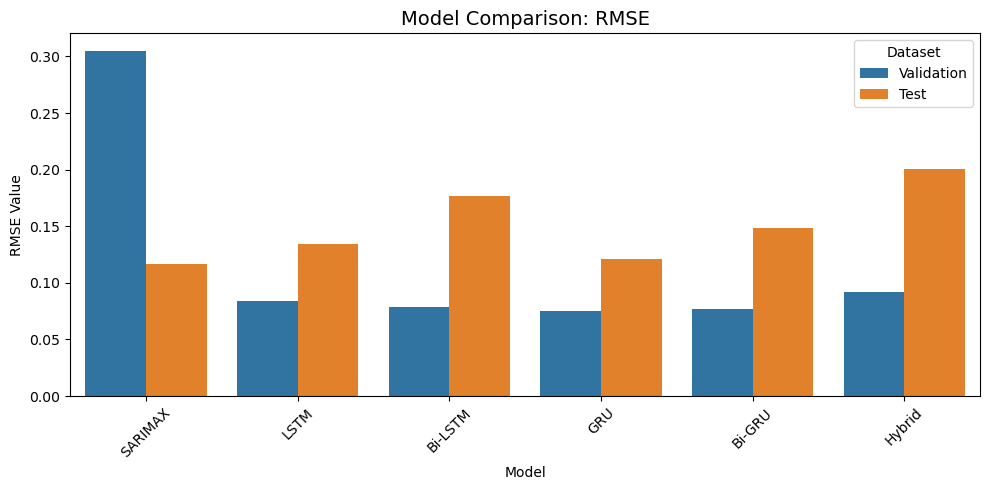

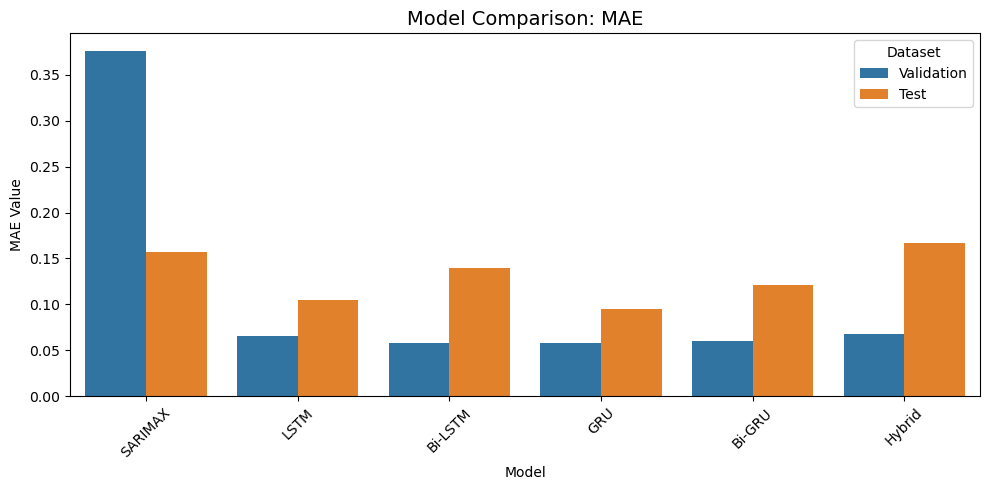

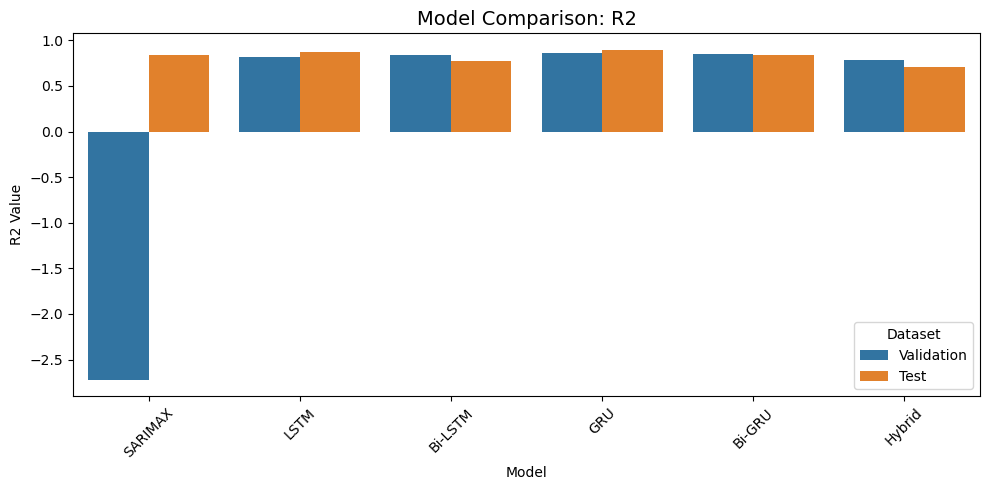

In [108]:
# --- Melt the DataFrame for seaborn ---
metrics_long = metrics_df.melt(
    id_vars='Model', 
    value_vars=['RMSE_Val', 'MAE_Val', 'R2_Val', 'RMSE_Test', 'MAE_Test', 'R2_Test'],
    var_name='Metric', 
    value_name='Value'
)

# --- Add dataset column ---
metrics_long['Dataset'] = metrics_long['Metric'].apply(lambda x: 'Validation' if '_Val' in x else 'Test')
metrics_long['Metric'] = (
    metrics_long['Metric']
    .str.replace('_Val', '', regex=False)
    .str.replace('_Test', '', regex=False)
)

# --- Plot separate figures for each metric ---
metrics = ['RMSE', 'MAE', 'R2']

for metric in metrics:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=metrics_long[metrics_long['Metric'] == metric],
        x='Model', 
        y='Value', 
        hue='Dataset', 
        ci=None
    )
    plt.title(f'Model Comparison: {metric}', fontsize=14)
    plt.ylabel(f'{metric} Value')
    plt.xlabel('Model')
    plt.xticks(rotation=45)
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()


# Forecasting 

In [109]:
# --- Concatenate all historical data ---
y_full = pd.concat([y_train_df, y_val_df, y_test_df])
y_full_rescaled = scaler_y.inverse_transform(y_full.values.reshape(-1,1)).flatten()

# --- Create date index ---
full_dates = pd.date_range(start=y_train_df.index[0], end=y_test_df.index[-1], freq='D')

# --- Parameters ---
future_steps = 30
last_sequence = X_test_seq[-1]
predictions_future = []

# --- Walk-forward prediction ---
current_seq = last_sequence.copy()
for _ in range(future_steps):
    next_pred = model_gru.predict(current_seq[np.newaxis, :, :], verbose=0)[0, 0]
    predictions_future.append(next_pred)
    current_seq = np.roll(current_seq, -1)
    current_seq[-1, 0] = next_pred

# --- Rescale forecast ---
predictions_future_rescaled = scaler_y.inverse_transform(np.array(predictions_future).reshape(-1,1)).flatten()

# --- Future date index ---
future_dates = pd.date_range(start=y_test_df.index[-1] + pd.Timedelta(days=1), periods=future_steps, freq='D')

# Calculate indices for different phases
train_end = len(y_train_df)
val_end = train_end + len(y_val_df)
historical_end = len(y_full_rescaled)

# --- Create interactive subplots with Plotly ---
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(
        'GRU Model: Complete Historical Data and Forecast',
        'Zoomed View: Validation + Test + Forecast Periods'
    ),
    vertical_spacing=0.1,
    specs=[[{"secondary_y": False}], [{"secondary_y": False}]]
)

# ---  Full historical view ---
# Training data
fig.add_trace(
    go.Scatter(
        x=full_dates[:train_end],
        y=y_full_rescaled[:train_end],
        name='Training Data',
        line=dict(color='#1f77b4', width=2),
        opacity=0.7,
        hovertemplate='<b>Training</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Validation data
fig.add_trace(
    go.Scatter(
        x=full_dates[train_end:val_end],
        y=y_full_rescaled[train_end:val_end],
        name='Validation Data',
        line=dict(color='#ff7f0e', width=2),
        opacity=0.7,
        hovertemplate='<b>Validation</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Test data
fig.add_trace(
    go.Scatter(
        x=full_dates[val_end:historical_end],
        y=y_full_rescaled[val_end:historical_end],
        name='Test Data',
        line=dict(color='#2ca02c', width=3),
        opacity=0.9,
        hovertemplate='<b>Test</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Forecast data
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=predictions_future_rescaled,
        name=f'GRU Forecast ({future_steps} days)',
        line=dict(color='#d62728', width=3),
        mode='lines+markers',
        marker=dict(size=4),
        hovertemplate='<b>Forecast</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=1, col=1
)

# Add vertical lines for phase separators
fig.add_vline(
    x=full_dates[train_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=1,
    opacity=0.7,
    row=1, col=1
)

fig.add_vline(
    x=full_dates[val_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=1,
    opacity=0.7,
    row=1, col=1
)

fig.add_vline(
    x=full_dates[historical_end-1], 
    line_dash="solid", 
    line_color="red", 
    line_width=2,
    opacity=0.8,
    row=1, col=1
)

# --- Plot 2: Zoomed-in view (Validation + Test + Forecast) ---
# Determine windows for zoomed view
val_window = min(30, len(y_val_df))
test_window = min(30, len(y_test_df))

val_start_idx = val_end - val_window
test_start_idx = historical_end - test_window

# Validation data (zoomed)
val_dates_zoom = full_dates[val_start_idx:val_end]
val_values_zoom = y_full_rescaled[val_start_idx:val_end]

# Test data (zoomed)
test_dates_zoom = full_dates[val_end:historical_end]
test_values_zoom = y_full_rescaled[val_end:historical_end]

# Plot validation data (zoomed)
fig.add_trace(
    go.Scatter(
        x=val_dates_zoom,
        y=val_values_zoom,
        name=f'Validation (Last {val_window} days)',
        line=dict(color='#ff7f0e', width=3),
        mode='lines+markers',
        marker=dict(size=5, symbol='triangle-up'),
        opacity=0.9,
        hovertemplate='<b>Validation</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Plot test data (zoomed)
fig.add_trace(
    go.Scatter(
        x=test_dates_zoom,
        y=test_values_zoom,
        name=f'Test Data ({len(test_values_zoom)} days)',
        line=dict(color='#2ca02c', width=3),
        mode='lines+markers',
        marker=dict(size=5, symbol='square'),
        opacity=0.9,
        hovertemplate='<b>Test</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Plot forecast (zoomed)
fig.add_trace(
    go.Scatter(
        x=future_dates,
        y=predictions_future_rescaled,
        name=f'Forecast ({future_steps} days)',
        line=dict(color='#d62728', width=4),
        mode='lines+markers',
        marker=dict(size=6, symbol='circle'),
        hovertemplate='<b>Forecast</b><br>Date: %{x|%Y-%m-%d}<br>Value: %{y:.2f}<extra></extra>'
    ),
    row=2, col=1
)

# Add key transition points with annotations
last_val_value = y_full_rescaled[val_end-1]
first_test_value = y_full_rescaled[val_end]
last_test_value = y_full_rescaled[historical_end-1]
first_forecast_value = predictions_future_rescaled[0]

# Key points for zoomed view
key_points = [
    (full_dates[val_end-1], last_val_value, 'Last Validation', '#ff7f0e'),
    (full_dates[val_end], first_test_value, 'First Test', '#2ca02c'),
    (full_dates[historical_end-1], last_test_value, 'Last Test', '#2ca02c'),
    (future_dates[0], first_forecast_value, 'First Forecast', '#d62728')
]

for date, value, name, color in key_points:
    fig.add_trace(
        go.Scatter(
            x=[date],
            y=[value],
            name=name,
            mode='markers',
            marker=dict(size=10, color=color, symbol='diamond'),
            hovertemplate=f'<b>{name}</b><br>Date: %{{x|%Y-%m-%d}}<br>Value: %{{y:.2f}}<extra></extra>',
            showlegend=True
        ),
        row=2, col=1
    )

# Add vertical lines for zoomed view
fig.add_vline(
    x=full_dates[val_end], 
    line_dash="dash", 
    line_color="gray", 
    line_width=2,
    opacity=0.8,
    row=2, col=1
)

fig.add_vline(
    x=full_dates[historical_end-1], 
    line_dash="solid", 
    line_color="red", 
    line_width=3,
    opacity=0.8,
    row=2, col=1
)

# --- Update layout for better appearance ---
fig.update_layout(
    height=1000,
    title_text=" GRU Model Forecasting Analysis\n",
    title_x=0.5,
    title_font=dict(size=24, color='darkblue'),
    template='plotly_white',
    hovermode='x unified',
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

# Update x-axis properties
fig.update_xaxes(
    title_text="Date",
    tickformat="%Y-%m-%d",
    tickangle=45,
    row=1, col=1
)

fig.update_xaxes(
    title_text="Date",
    tickformat="%Y-%m-%d",
    tickangle=45,
    row=2, col=1
)

# Update y-axis properties
fig.update_yaxes(title_text="Value", row=1, col=1)
fig.update_yaxes(title_text="Value", row=2, col=1)

# Add annotations for transitions
val_test_change = ((first_test_value - last_val_value) / last_val_value * 100)
test_forecast_change = ((first_forecast_value - last_test_value) / last_test_value * 100)

fig.add_annotation(
    x=full_dates[val_end],
    y=(first_test_value + last_val_value) / 2,
    text=f"Δ = {val_test_change:+.1f}%",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=0,
    bgcolor="orange",
    opacity=0.8,
    row=2, col=1
)

fig.add_annotation(
    x=future_dates[0],
    y=(first_forecast_value + last_test_value) / 2,
    text=f"Δ = {test_forecast_change:+.1f}%",
    showarrow=True,
    arrowhead=2,
    ax=50,
    ay=0,
    bgcolor="red",
    opacity=0.8,
    row=2, col=1
)

# Show the plot
fig.show()

# --- Additional interactive statistics display ---
print(f"\n{'='*80}")
print(f"INTERACTIVE FORECASTING SUMMARY")
print(f"{'='*80}")
print(f"    Model Performance Overview:")
print(f"   • Validation Period: {val_dates_zoom[0].strftime('%Y-%m-%d')} to {val_dates_zoom[-1].strftime('%Y-%m-%d')}")
print(f"   • Test Period: {test_dates_zoom[0].strftime('%Y-%m-%d')} to {test_dates_zoom[-1].strftime('%Y-%m-%d')}")
print(f"   • Forecast Period: {future_dates[0].strftime('%Y-%m-%d')} to {future_dates[-1].strftime('%Y-%m-%d')}")

print(f"\n  Key Statistics:")
print(f"   • Validation Range: {val_values_zoom.min():.2f} - {val_values_zoom.max():.2f}")
print(f"   • Test Range: {test_values_zoom.min():.2f} - {test_values_zoom.max():.2f}")
print(f"   • Forecast Range: {predictions_future_rescaled.min():.2f} - {predictions_future_rescaled.max():.2f}")

print(f"\n  Transition Analysis:")
print(f"   • Validation → Test: {val_test_change:+.2f}%")
print(f"   • Test → Forecast: {test_forecast_change:+.2f}%")
print(f"   • Overall Trend: {((predictions_future_rescaled[-1] - val_values_zoom[0]) / val_values_zoom[0] * 100):+.2f}%")

print(f"{'='*80}")

# Create a summary DataFrame for additional analysis
summary_df = pd.DataFrame({
    'Phase': ['Validation', 'Test', 'Forecast'],
    'Start_Date': [val_dates_zoom[0], test_dates_zoom[0], future_dates[0]],
    'End_Date': [val_dates_zoom[-1], test_dates_zoom[-1], future_dates[-1]],
    'Min_Value': [val_values_zoom.min(), test_values_zoom.min(), predictions_future_rescaled.min()],
    'Max_Value': [val_values_zoom.max(), test_values_zoom.max(), predictions_future_rescaled.max()],
    'Mean_Value': [val_values_zoom.mean(), test_values_zoom.mean(), predictions_future_rescaled.mean()]
})

print("\n" + summary_df.to_string(index=False))


INTERACTIVE FORECASTING SUMMARY
    Model Performance Overview:
   • Validation Period: 2024-02-04 to 2024-03-04
   • Test Period: 2024-03-05 to 2025-06-20
   • Forecast Period: 2025-07-05 to 2025-08-03

  Key Statistics:
   • Validation Range: 111486.11 - 186622.83
   • Test Range: 13405.52 - 259062.28
   • Forecast Range: -478157.44 - 41017.30

  Transition Analysis:
   • Validation → Test: +31.62%
   • Test → Forecast: +65.15%
   • Overall Trend: -457.93%

     Phase Start_Date   End_Date      Min_Value     Max_Value     Mean_Value
Validation 2024-02-04 2024-03-04  111486.110644 186622.833023  143345.267542
      Test 2024-03-05 2025-06-20   13405.519427 259062.277145   84606.870857
  Forecast 2025-07-05 2025-08-03 -478157.437500  41017.300781 -175262.984375


# XAI

In [110]:
# Get feature names from X_train_df columns
if hasattr(X_train_df, 'columns'):
    feature_names = X_train_df.columns.tolist()
    print("Feature names from X_train_df:")
    print(feature_names)
    print(f"Number of features: {len(feature_names)}")
else:
    # If X_train_df is not a DataFrame, create generic names
    n_features = X_train_df.shape[1] if hasattr(X_train_df, 'shape') else n_features
    feature_names = [f'Feature_{i}' for i in range(n_features)]
    print("Created generic feature names:")
    print(feature_names)

# Verify the number matches your sequence data
print(f"n_features used in model: {n_features}")
print(f"Features from X_train_df: {len(feature_names)}")

# Ensure consistency
if len(feature_names) != n_features:
    print(f"Warning: Feature count mismatch! Using first {n_features} features.")
    feature_names = feature_names[:n_features]

Feature names from X_train_df:
['Value_lag1', 'Value_lag2']
Number of features: 2
n_features used in model: 2
Features from X_train_df: 2


Created 14 time-aware feature names
Sample feature names: ['t-6_Value_lag1', 't-6_Value_lag2', 't-5_Value_lag1', 't-5_Value_lag2', 't-4_Value_lag1']
Starting XAI analysis with real feature names...

ANALYZING SAMPLE 0
Intercept 0.4422039279633253
Prediction_local [0.42886035]
Right: 0.46899045


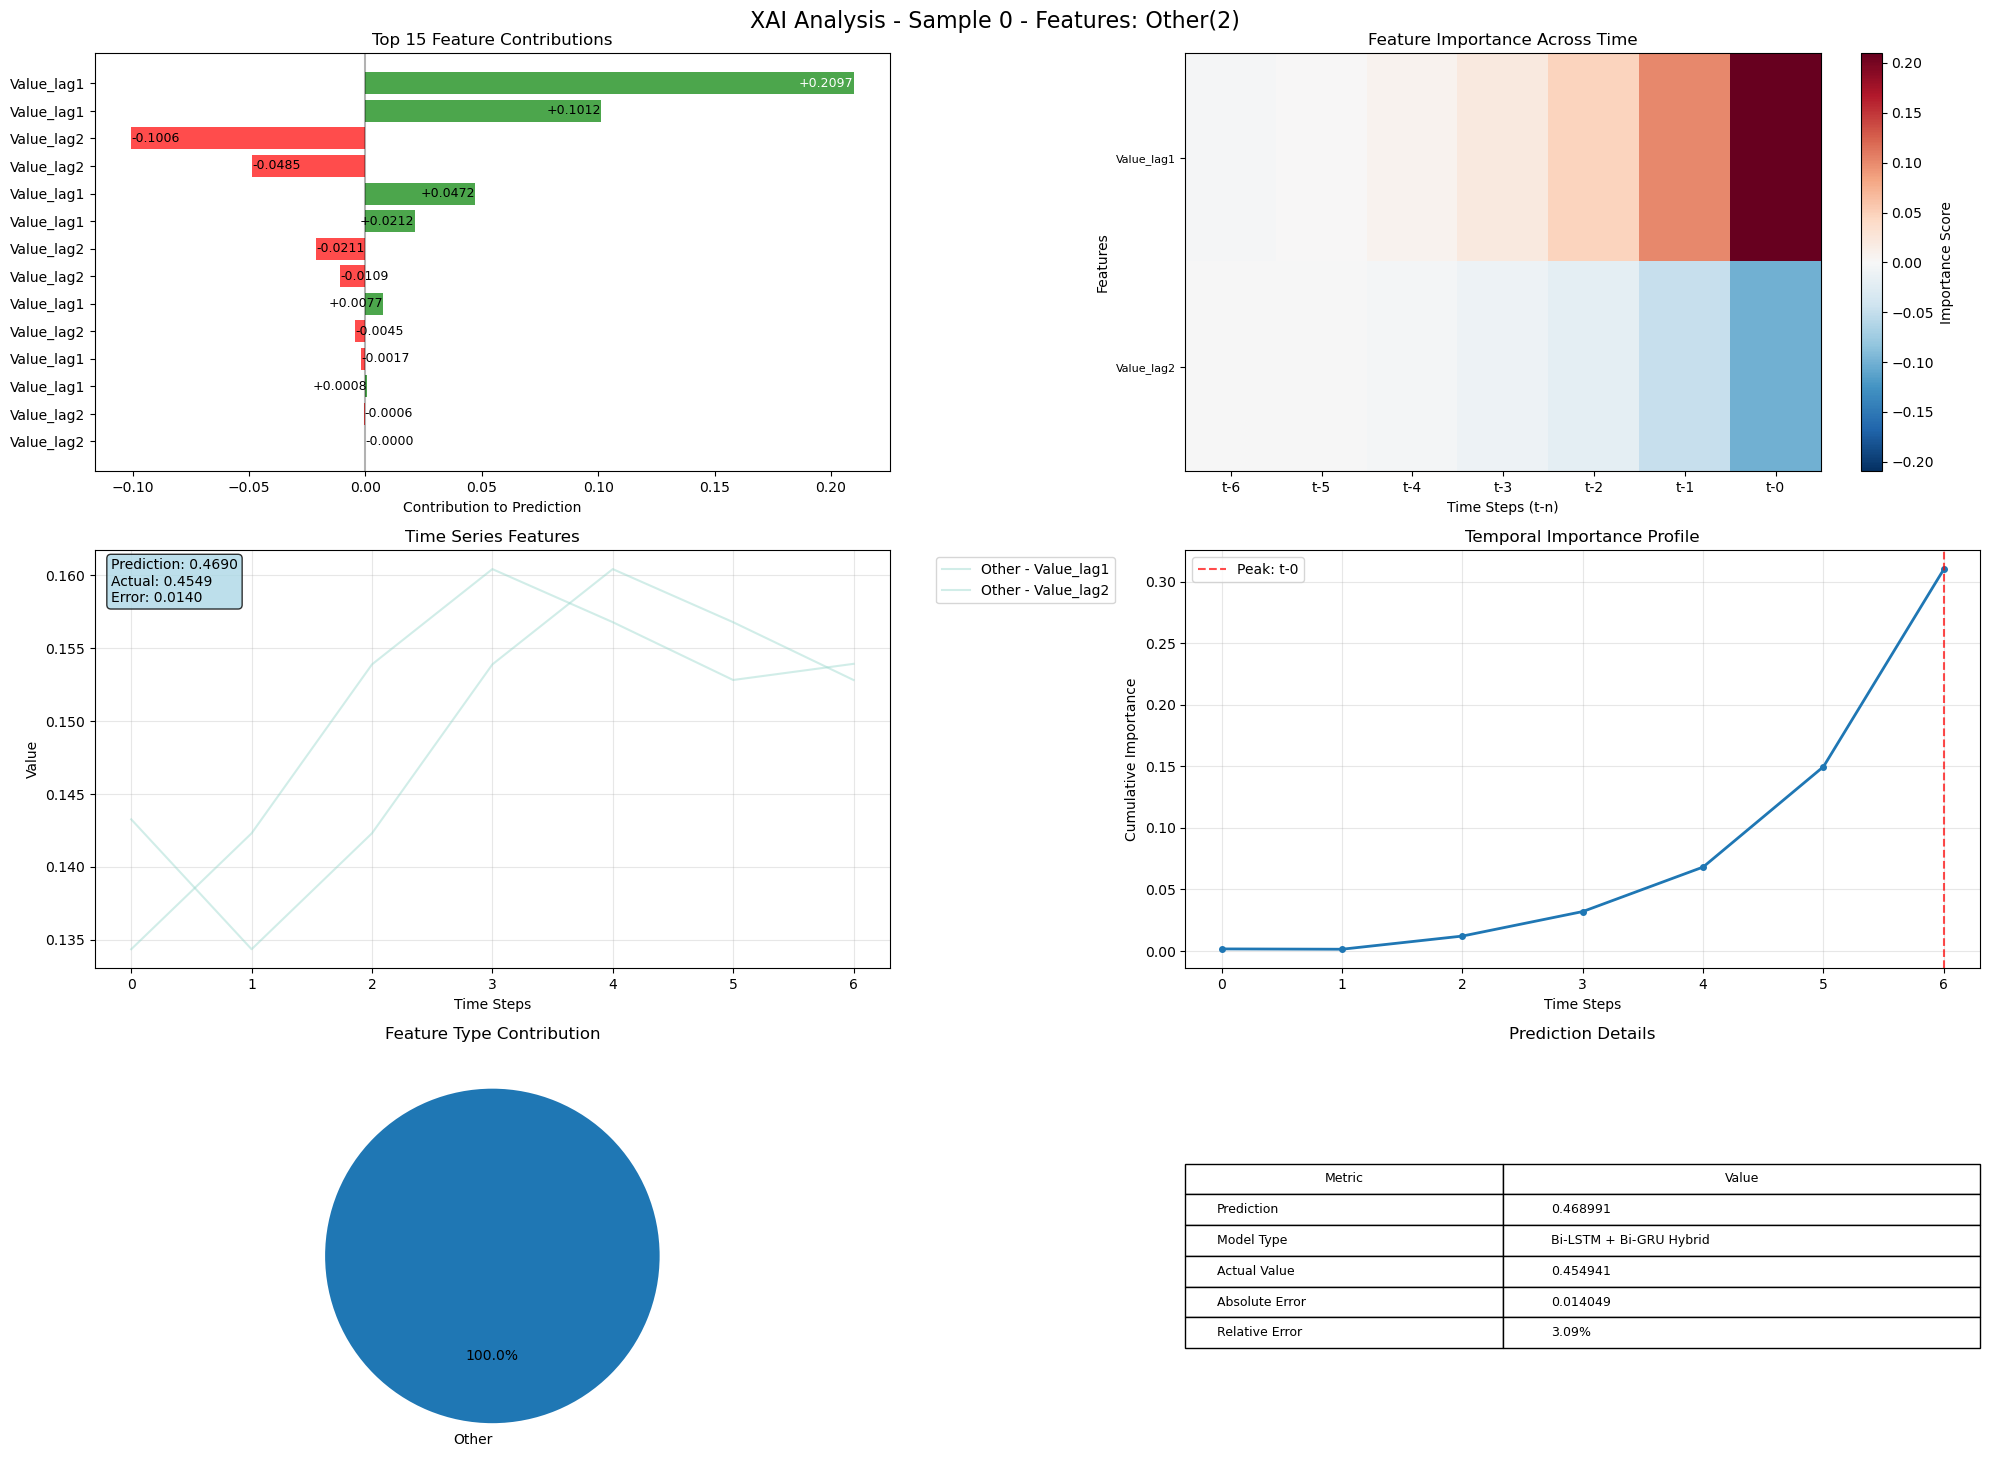

Saved: lime_explanation_sample_0.html

ANALYZING SAMPLE 1
Intercept 0.4428390353644411
Prediction_local [0.43070141]
Right: 0.47060794


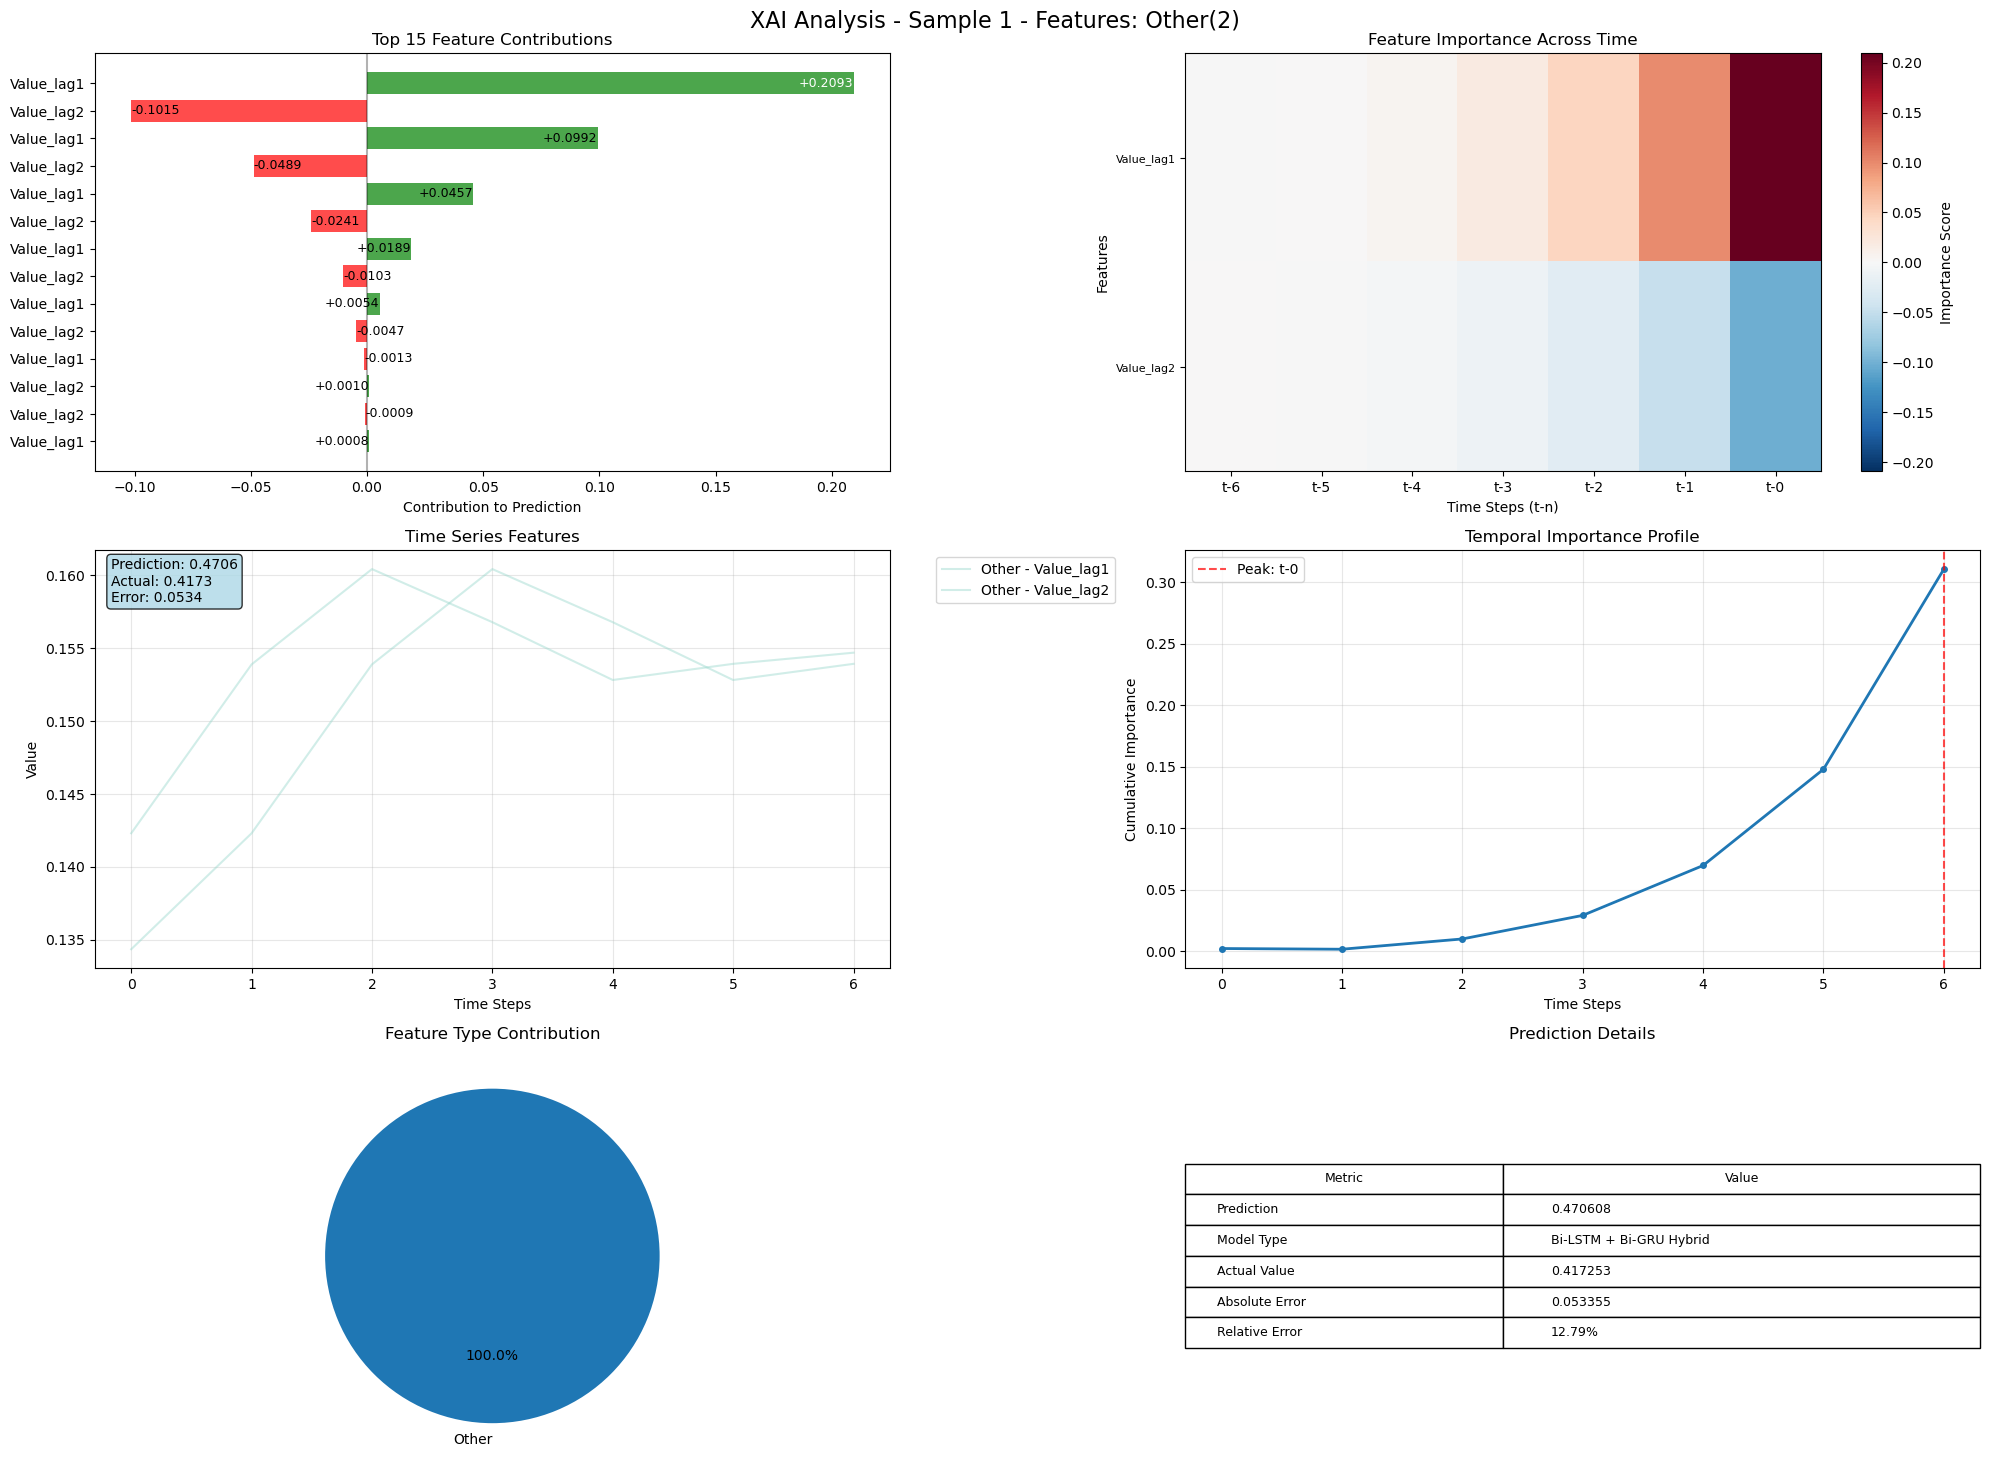

Saved: lime_explanation_sample_1.html

ANALYZING SAMPLE 2
Intercept 0.4435207476785421
Prediction_local [0.4294252]
Right: 0.4690523


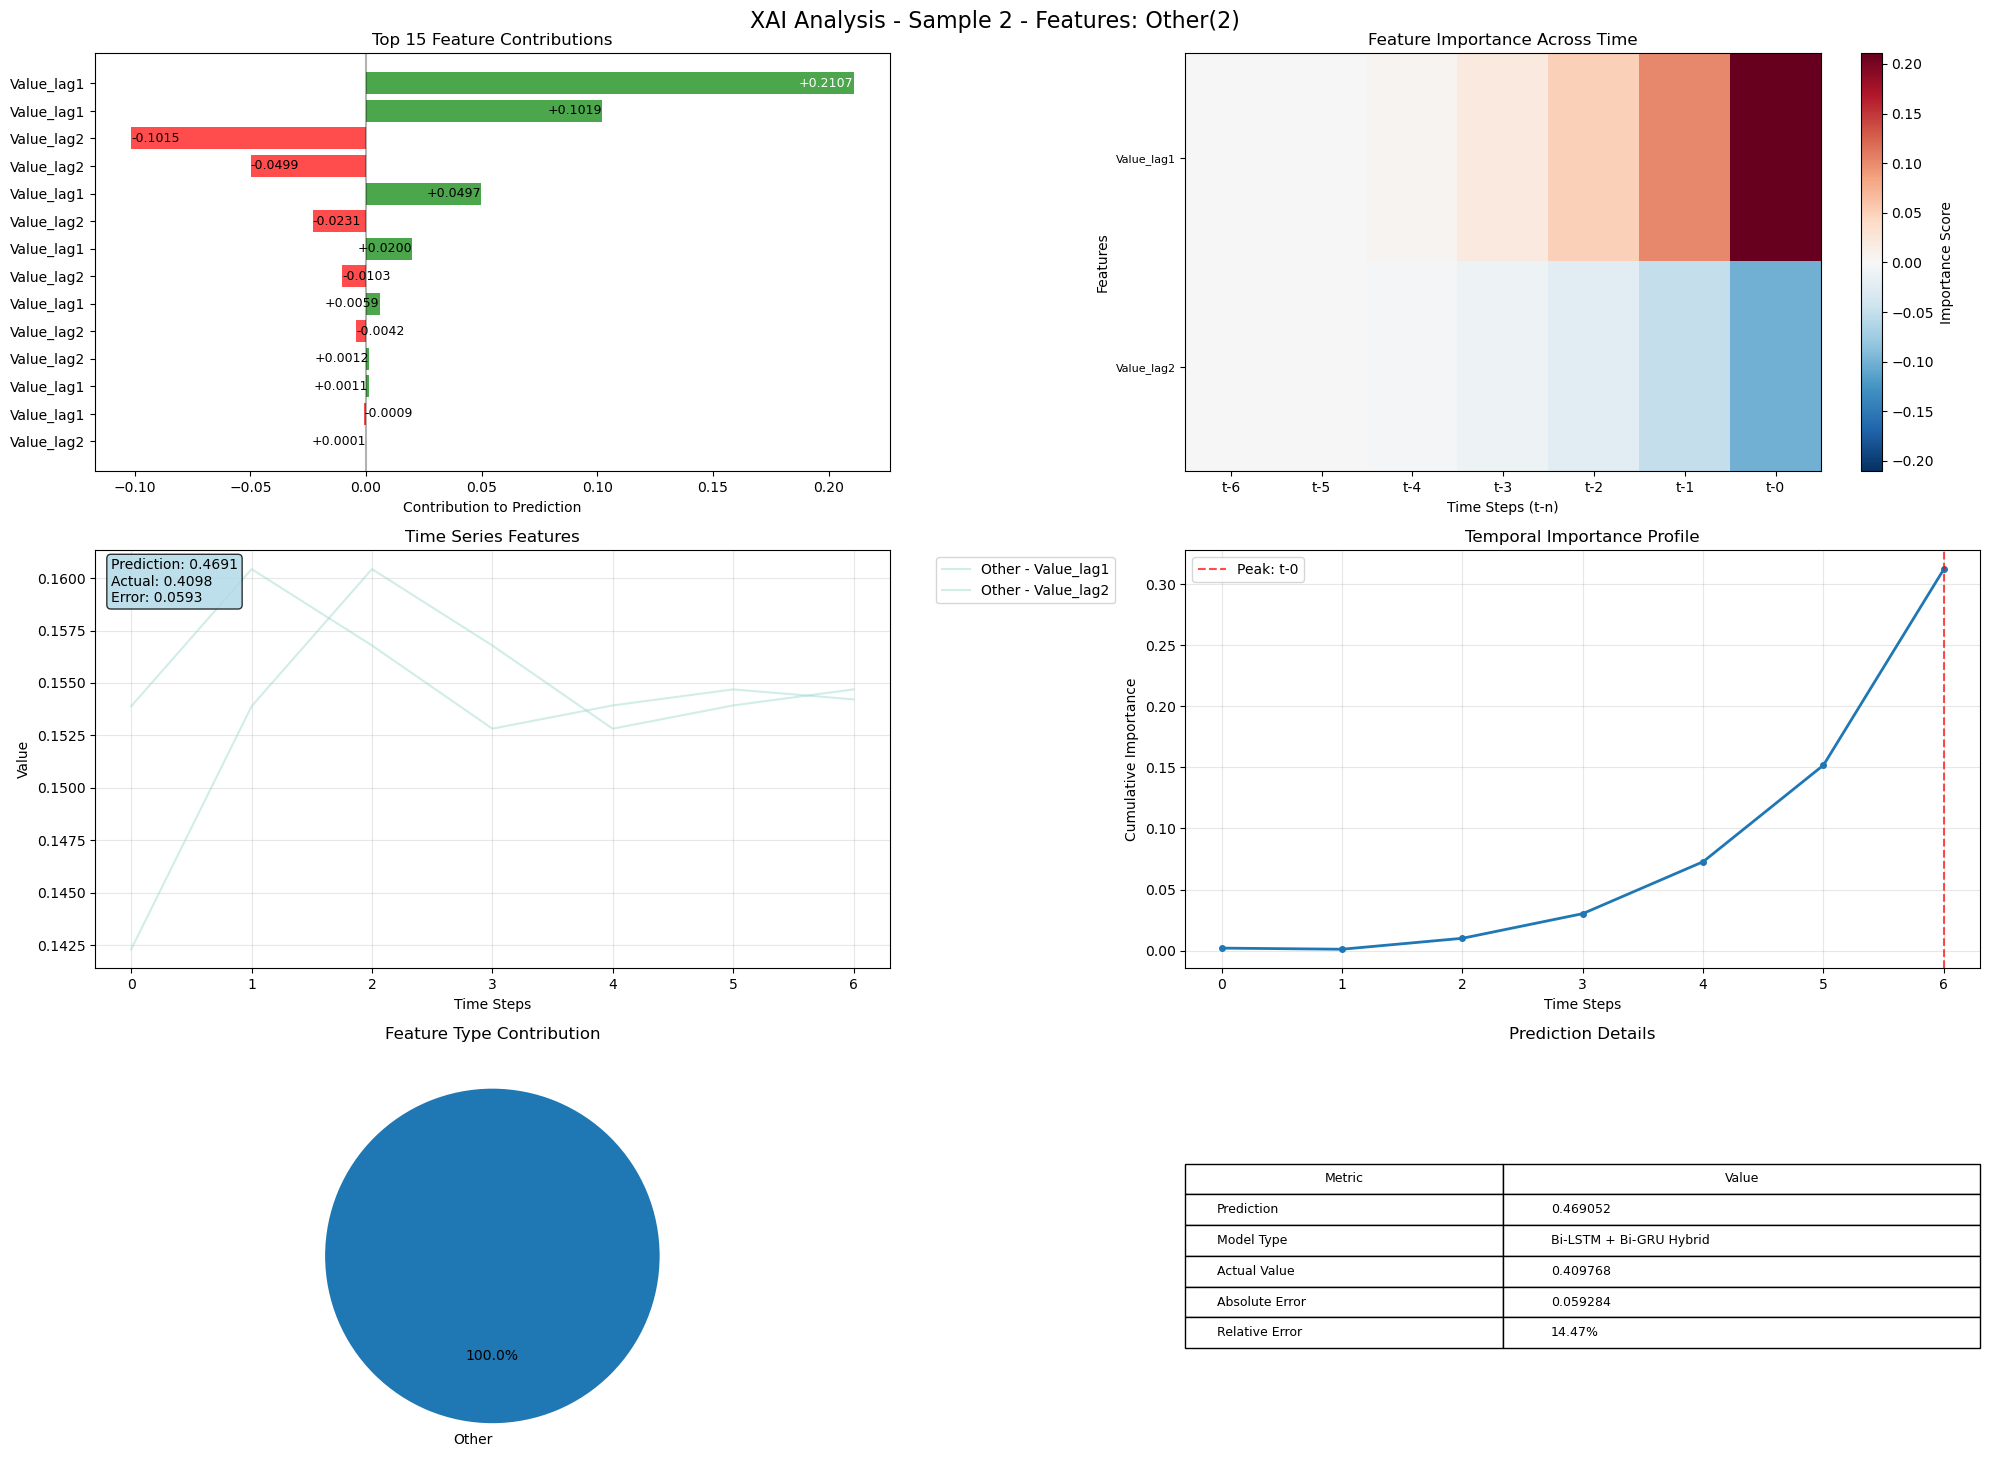

Saved: lime_explanation_sample_2.html


In [111]:
import numpy as np
import matplotlib.pyplot as plt
from lime import lime_tabular
import seaborn as sns
from matplotlib.gridspec import GridSpec
import pandas as pd

# Get feature names from X_train_df
feature_names = X_train_df.columns.tolist()[:n_features]  # Take first n_features

class AdvancedTimeSeriesLIME:
    def __init__(self, model, X_train_seq, feature_names, seq_length):
        self.model = model
        self.seq_length = seq_length
        self.n_features = len(feature_names)
        self.feature_names = feature_names
        self.X_train_flat = X_train_seq.reshape(X_train_seq.shape[0], -1)
        
        # Create descriptive time-aware feature names
        self.time_feature_names = [
            f"t-{self.seq_length-t-1}_{feature_names[f]}" 
            for t in range(self.seq_length) 
            for f in range(self.n_features)
        ]
        
        print(f"Created {len(self.time_feature_names)} time-aware feature names")
        print("Sample feature names:", self.time_feature_names[:5])
        
        self.explainer = lime_tabular.LimeTabularExplainer(
            training_data=self.X_train_flat,
            mode="regression",
            feature_names=self.time_feature_names,
            discretize_continuous=False,
            random_state=42,
            verbose=True
        )
    
    def predict_fn(self, x):
        """Prediction function with error handling"""
        try:
            x_reshaped = x.reshape(-1, self.seq_length, self.n_features)
            predictions = self.model.predict(x_reshaped, verbose=0)
            return predictions
        except Exception as e:
            print(f"Prediction error: {e}")
            return np.zeros((x.shape[0], 1))
    
    def explain_instance(self, sample_flat, num_features=20, num_samples=5000):
        """Enhanced explanation with real feature names"""
        exp = self.explainer.explain_instance(
            data_row=sample_flat,
            predict_fn=self.predict_fn,
            num_features=num_features,
            num_samples=num_samples
        )
        return exp
    
    def create_comprehensive_visualization(self, exp, original_sequence, prediction, actual=None, sample_idx=0):
        """Create visualization with real feature names"""
        fig = plt.figure(figsize=(20, 15))
        gs = GridSpec(3, 2, figure=fig)
        
        # 1. Feature Importance Bar Plot
        ax1 = fig.add_subplot(gs[0, 0])
        self._plot_feature_importance(exp, ax1, top_k=15)
        
        # 2. Temporal Heatmap
        ax2 = fig.add_subplot(gs[0, 1])
        self._plot_temporal_heatmap(exp, original_sequence, ax2)
        
        # 3. Original Time Series
        ax3 = fig.add_subplot(gs[1, 0])
        self._plot_original_timeseries(original_sequence, prediction, actual, ax3)
        
        # 4. Feature Importance Over Time
        ax4 = fig.add_subplot(gs[1, 1])
        self._plot_feature_importance_time(exp, ax4)
        
        # 5. Feature Type Analysis
        ax5 = fig.add_subplot(gs[2, 0])
        self._plot_feature_type_analysis(exp, ax5)
        
        # 6. Prediction Analysis
        ax6 = fig.add_subplot(gs[2, 1])
        self._plot_prediction_analysis(prediction, actual, ax6)
        
        plt.suptitle(f'XAI Analysis - Sample {sample_idx} - {self._get_feature_categories()}', fontsize=16)
        plt.tight_layout()
        plt.show()
    
    def _plot_feature_importance(self, exp, ax, top_k=15):
        """Plot feature importance with real names"""
        features = exp.as_list()[:top_k]
        features.reverse()
        
        # Extract time step and feature name from the combined string
        simplified_names = []
        for full_name, value in features:
            # Extract feature name from "t-X_FeatureName"
            feature_name = full_name.split('_', 1)[1] if '_' in full_name else full_name
            simplified_names.append(feature_name)
        
        values = [f[1] for f in features]
        colors = ['red' if x < 0 else 'green' for x in values]
        y_pos = np.arange(len(simplified_names))
        
        bars = ax.barh(y_pos, values, color=colors, alpha=0.7)
        ax.set_yticks(y_pos)
        ax.set_yticklabels(simplified_names, fontsize=10)
        ax.set_xlabel('Contribution to Prediction')
        ax.set_title(f'Top {top_k} Feature Contributions')
        ax.axvline(x=0, color='black', linestyle='-', alpha=0.3)
        
        # Add value annotations
        for i, (v, name) in enumerate(zip(values, simplified_names)):
            ax.text(v, i, f'{v:+.4f}', va='center', 
                   ha='left' if v < 0 else 'right', 
                   fontsize=9, color='black' if abs(v) < max(abs(np.array(values))) * 0.5 else 'white')
    
    def _plot_temporal_heatmap(self, exp, original_sequence, ax):
        """Enhanced heatmap with feature names"""
        weights = dict(exp.as_list())
        
        importance = np.zeros((self.seq_length, self.n_features))
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                importance[t, f] = weights.get(feat_name, 0)
        
        # Create heatmap
        im = ax.imshow(importance.T, aspect='auto', cmap='RdBu_r', 
                      vmin=-np.max(np.abs(importance)), vmax=np.max(np.abs(importance)))
        
        ax.set_xlabel('Time Steps (t-n)')
        ax.set_ylabel('Features')
        ax.set_title('Feature Importance Across Time')
        
        # Set y-axis labels with feature names
        ax.set_yticks(range(self.n_features))
        ax.set_yticklabels(self.feature_names, fontsize=8)
        
        # Add time labels
        time_labels = [f't-{i}' for i in range(self.seq_length-1, -1, -max(1, self.seq_length//10))]
        ax.set_xticks(range(0, self.seq_length, max(1, self.seq_length//10)))
        ax.set_xticklabels(time_labels[:len(ax.get_xticks())])
        
        plt.colorbar(im, ax=ax, label='Importance Score')
        
        # Add feature category annotations
        if self._has_technical_indicators():
            ax.text(0.02, 0.98, self._get_feature_categories(), transform=ax.transAxes,
                   fontsize=8, verticalalignment='top', 
                   bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    def _plot_original_timeseries(self, original_sequence, prediction, actual, ax):
        """Plot time series with feature grouping"""
        time_steps = range(self.seq_length)
        
        # Group features by type if possible
        feature_groups = self._group_features_by_type()
        
        colors = plt.cm.Set3(np.linspace(0, 1, len(feature_groups)))
        
        for group_idx, (group_name, feature_indices) in enumerate(feature_groups.items()):
            for f_idx in feature_indices:
                if f_idx < self.n_features:
                    alpha = 0.7 if len(feature_indices) == 1 else 0.4
                    label = f"{group_name} - {self.feature_names[f_idx]}" if len(feature_indices) > 1 else self.feature_names[f_idx]
                    ax.plot(time_steps, original_sequence[:, f_idx], 
                           color=colors[group_idx], alpha=alpha, label=label, linewidth=1.5)
        
        # Prediction info
        pred_text = f'Prediction: {prediction:.4f}'
        if actual is not None:
            pred_text += f'\nActual: {actual:.4f}\nError: {abs(prediction-actual):.4f}'
        
        ax.text(0.02, 0.98, pred_text, transform=ax.transAxes, 
               verticalalignment='top', bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
        
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Value')
        ax.set_title('Time Series Features')
        if len(feature_groups) <= 8:  # Only show legend if not too many groups
            ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        ax.grid(True, alpha=0.3)
    
    def _plot_feature_importance_time(self, exp, ax):
        """Plot temporal importance with feature categories"""
        weights = dict(exp.as_list())
        
        time_importance = np.zeros(self.seq_length)
        feature_importance = np.zeros(self.n_features)
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                if feat_name in weights:
                    importance = abs(weights[feat_name])
                    time_importance[t] += importance
                    feature_importance[f] += importance
        
        ax.plot(range(self.seq_length), time_importance, marker='o', linewidth=2, markersize=4)
        ax.set_xlabel('Time Steps')
        ax.set_ylabel('Cumulative Importance')
        ax.set_title('Temporal Importance Profile')
        ax.grid(True, alpha=0.3)
        
        # Highlight important time steps
        max_idx = np.argmax(time_importance)
        ax.axvline(x=max_idx, color='red', linestyle='--', alpha=0.7, 
                  label=f'Peak: t-{self.seq_length-max_idx-1}')
        ax.legend()
    
    def _plot_feature_type_analysis(self, exp, ax):
        """Analyze feature types contribution"""
        weights = dict(exp.as_list())
        
        feature_groups = self._group_features_by_type()
        group_contributions = {group: 0 for group in feature_groups.keys()}
        
        for t in range(self.seq_length):
            for f in range(self.n_features):
                feat_name = f"t-{self.seq_length-t-1}_{self.feature_names[f]}"
                if feat_name in weights:
                    # Find which group this feature belongs to
                    for group_name, indices in feature_groups.items():
                        if f in indices:
                            group_contributions[group_name] += abs(weights[feat_name])
                            break
        
        # Plot pie chart
        if sum(group_contributions.values()) > 0:
            labels = list(group_contributions.keys())
            sizes = [group_contributions[label] for label in labels]
            ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
            ax.set_title('Feature Type Contribution')
        else:
            ax.text(0.5, 0.5, 'No contribution data', ha='center', va='center', transform=ax.transAxes)
            ax.set_title('Feature Type Contribution')
    
    def _plot_prediction_analysis(self, prediction, actual, ax):
        """Enhanced prediction analysis"""
        metrics = {
            'Prediction': f'{prediction:.6f}',
            'Model Type': 'Bi-LSTM + Bi-GRU Hybrid'
        }
        
        if actual is not None:
            metrics.update({
                'Actual Value': f'{actual:.6f}',
                'Absolute Error': f'{abs(prediction - actual):.6f}',
                'Relative Error': f'{abs(prediction - actual) / abs(actual) * 100:.2f}%'
            })
        
        ax.axis('off')
        table_data = [[k, v] for k, v in metrics.items()]
        table = ax.table(cellText=table_data, 
                        colLabels=['Metric', 'Value'], 
                        loc='center', 
                        cellLoc='left',
                        colWidths=[0.4, 0.6])
        
        table.auto_set_font_size(False)
        table.set_fontsize(9)
        table.scale(1, 1.5)
        ax.set_title('Prediction Details')
    
    def _group_features_by_type(self):
        """Intelligently group features by their names"""
        groups = {}
        
        # Common financial feature patterns
        price_patterns = ['open', 'high', 'low', 'close', 'price']
        volume_patterns = ['volume', 'vol']
        technical_patterns = ['rsi', 'macd', 'sma', 'ema', 'atr', 'bollinger', 'vwap', 'momentum']
        volatility_patterns = ['volatility', 'std', 'variance']
        change_patterns = ['change', 'return', 'delta']
        
        for i, feature_name in enumerate(self.feature_names):
            feature_lower = feature_name.lower()
            
            if any(pattern in feature_lower for pattern in price_patterns):
                group = 'Price'
            elif any(pattern in feature_lower for pattern in volume_patterns):
                group = 'Volume'
            elif any(pattern in feature_lower for pattern in technical_patterns):
                group = 'Technical'
            elif any(pattern in feature_lower for pattern in volatility_patterns):
                group = 'Volatility'
            elif any(pattern in feature_lower for pattern in change_patterns):
                group = 'Changes'
            else:
                group = 'Other'
            
            if group not in groups:
                groups[group] = []
            groups[group].append(i)
        
        return groups
    
    def _has_technical_indicators(self):
        """Check if features include technical indicators"""
        return any(any(pattern in name.lower() for pattern in ['rsi', 'macd', 'sma', 'ema']) 
                  for name in self.feature_names)
    
    def _get_feature_categories(self):
        """Get feature categories summary"""
        groups = self._group_features_by_type()
        return f"Features: {', '.join(f'{k}({len(v)})' for k, v in groups.items())}"

# Initialize with real feature names
advanced_lime = AdvancedTimeSeriesLIME(
    model=hybrid_model,
    X_train_seq=X_train_seq,
    feature_names=feature_names,  # From X_train_df.columns
    seq_length=SEQ_LENGTH
)

# Generate comprehensive analysis
print("Starting XAI analysis with real feature names...")
X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)

for i in range(min(3, len(X_val_seq))):  # Analyze first 3 samples
    print(f"\n{'='*60}")
    print(f"ANALYZING SAMPLE {i}")
    print(f"{'='*60}")
    
    exp = advanced_lime.explain_instance(X_val_flat[i])
    prediction = advanced_lime.predict_fn(X_val_flat[i:i+1])[0][0]
    actual = y_val_seq[i][0] if y_val_seq is not None else None
    
    # Create visualization
    advanced_lime.create_comprehensive_visualization(
        exp, X_val_seq[i], prediction, actual, i
    )
    
    # Save HTML report
    html_content = exp.as_html()
    with open(f"lime_explanation_sample_{i}.html", "w", encoding='utf-8') as f:
        f.write(html_content)
    print(f"Saved: lime_explanation_sample_{i}.html")

In [112]:
# Models and names
models_dict = {
    "LSTM": lstm_model,
    "Bi-LSTM": bi_lstm_model,
    "GRU": gru_model,
    "Bi-GRU": bigru_model,
    "Hybrid": hybrid_model
}

# Number of validation samples to explain
n_samples_to_explain = 3  

# Main folder for all LIME reports
base_folder = "lime_reports_value"
os.makedirs(base_folder, exist_ok=True)

for model_name, model in models_dict.items():
    print(f"\n{'='*80}\nProcessing XAI for {model_name}\n{'='*80}")
    
    # Create folder for the current model
    model_folder = os.path.join(base_folder, model_name.replace(" ", "_"))
    os.makedirs(model_folder, exist_ok=True)
    
    # Initialize LIME
    lime_xai = AdvancedTimeSeriesLIME(
        model=model,
        X_train_seq=X_train_seq,
        feature_names=feature_names,
        seq_length=seq_length
    )
    
    # Flatten validation data
    X_val_flat = X_val_seq.reshape(X_val_seq.shape[0], -1)
    
    # Run LIME explanations for first n_samples_to_explain
    for i in range(min(n_samples_to_explain, len(X_val_seq))):
        print(f"\nAnalyzing sample {i} for {model_name}...")
        
        exp = lime_xai.explain_instance(X_val_flat[i])
        prediction = lime_xai.predict_fn(X_val_flat[i:i+1])[0][0]
        actual = y_val_seq[i][0] if y_val_seq is not None else None
        
        # Visualization
        lime_xai.create_comprehensive_visualization(
            exp, X_val_seq[i], prediction, actual, sample_idx=i
        )
        
        # Save HTML report
        html_path = os.path.join(model_folder, f"lime_explanation_sample_{i}.html")
        with open(html_path, "w", encoding='utf-8') as f:
            f.write(exp.as_html())
        print(f"Saved LIME explanation: {html_path}")


NameError: name 'bi_lstm_model' is not defined